## Imports

In [1]:
import yaml
import torch
import torch.nn as nn
import numpy as np
import tqdm
import os
import argparse
from utils import get_prior
from torch.backends import cudnn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

cudnn.benchmark = True

def delete_module(name):
    import sys
    del sys.modules[name]
    
    
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load the config

In [3]:
config_file = './test_config.yaml'

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

with open(config_file, 'r') as f:
    config = yaml.load(f)
        
cfg = dict2namespace(config)
cfg

/nfs/rhea.dgp/u6/a/mrsalehi/.virtualenvs/base/lib/python3.6/site-packages/ipykernel_launcher.py:14: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


Namespace(data=Namespace(batch_size=1, cates=['airplane'], data_dir='data/toy-airplane-data', dataset_scale=1, dataset_type='shapenet15k', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=4, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='datasets.pointflow_datasets'), inference=Namespace(num_points=2048, num_steps=10, step_size_ratio=1, weight=1), log=Namespace(log_freq=10, save_dir='log/sigma-begin-1', save_freq=200, val_freq=100, viz_freq=100), models=Namespace(scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128)), trainer=Namespace(c_iters=10, epochs=2000, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_e

In [4]:
cfg.data

Namespace(batch_size=1, cates=['airplane'], data_dir='data/toy-airplane-data', dataset_scale=1, dataset_type='shapenet15k', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=4, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='datasets.pointflow_datasets')

In [5]:
cfg.trainer

Namespace(c_iters=10, epochs=2000, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), s_iters=10, seed=100, sigma_begin=1, sigma_end=0.01, sigma_num=10, type='trainers.ae_trainer_3D')

In [6]:
cfg.models

Namespace(scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128))

In [7]:
cfg.inference

Namespace(num_points=2048, num_steps=10, step_size_ratio=1, weight=1)

In [8]:
cfg.log

Namespace(log_freq=10, save_dir='log/sigma-begin-1', save_freq=200, val_freq=100, viz_freq=100)

# Train

In [9]:
from scorenet import Scorenet
from critic import Criticnet, SmallMLP
from utils import get_opt, set_random_seed, exact_jacobian_trace, langevin_dynamics, visualize
from datasets.data_loader import get_data
import random
import torch.nn.utils.spectral_norm as spectral_norm

In [10]:
set_random_seed(getattr(cfg.trainer, "seed", 666))

# load data
train_data = get_data(cfg.data, 0)
#tr_pts = train_data['tr_points'].unsqueeze(0)
tr_pts = train_data['tr_points']

#te_pts = train_data['te_points'].unsqueeze(0)
te_pts = train_data['te_points']

tr_pts = tr_pts.to(device)
te_pts = te_pts.to(device)
tr_pts.requires_grad_()
te_pts.requires_grad_();

100%|██████████| 1/1 [00:00<00:00, 674.43it/s]


Total number of data:1
Min number of points: (train)2048 (test)2048


### Visualize the data

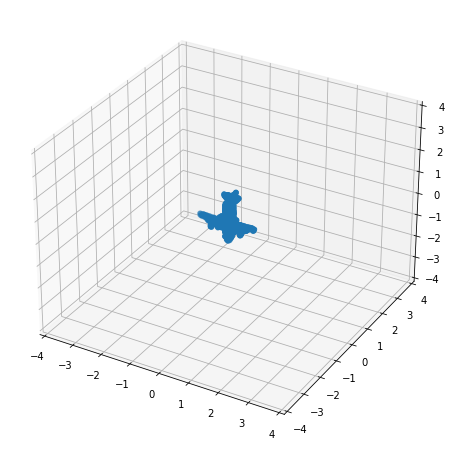

In [11]:
visualize(tr_pts)

In [12]:
# sigmas
if hasattr(cfg.trainer, "sigmas"):
    np_sigmas = cfg.trainer.sigmas
else:
    sigma_begin = float(cfg.trainer.sigma_begin)
    sigma_end = float(cfg.trainer.sigma_end)
    num_classes = int(cfg.trainer.sigma_num)
    np_sigmas = np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_classes))
print("Sigma:, ", np_sigmas)
sigmas = torch.tensor(np.array(np_sigmas)).float().cuda().view(-1, 1)

Sigma:,  [1.         0.59948425 0.35938137 0.21544347 0.12915497 0.07742637
 0.04641589 0.02782559 0.01668101 0.01      ]


In [13]:
def apply_spectral_norm(module):
    norm = nn.BatchNorm1d
    if not isinstance(module, norm) and 'weight' in module._parameters:
        spectral_norm(module)

## Both SmallMLP

In [14]:
# score net
#score_net = Scorenet()
score_net = SmallMLP(in_dim=3)
#critic_net = Criticnet()
critic_net = SmallMLP(in_dim=3)

#critic_net.apply(apply_spectral_norm)
critic_net.to(device)
score_net.to(device)

print(score_net)
print(critic_net)

# optimizer
opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

SmallMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): Swish()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Swish()
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)
SmallMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): Swish()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Swish()
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)


## Just SmallMLP CriticNet

In [15]:
critic_net = SmallMLP(in_dim=3)
score_net = Scorenet()
#critic_net = Criticnet()
#critic_net = SmallMLP(in_dim=3)

#critic_net.apply(apply_spectral_norm)
critic_net.to(device)
score_net.to(device)

print(score_net)
print(critic_net)

# optimizer
opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

Scorenet(
  (conv_p): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
  (blocks): ModuleList(
    (0): ResnetBlockConv1d(
      (bn_0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc_0): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_c): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
      (actvn): ReLU()
    )
    (1): ResnetBlockConv1d(
      (bn_0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc_0): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_c): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
      (actvn): ReLU()
    )
    (2): ResnetBlockConv1d(
      (bn_0): BatchN

In [16]:
sigmas

tensor([[1.0000],
        [0.5995],
        [0.3594],
        [0.2154],
        [0.1292],
        [0.0774],
        [0.0464],
        [0.0278],
        [0.0167],
        [0.0100]], device='cuda:0')

In [17]:
# training
start_epoch = 0
n_epochs = 25000
print("Start epoch: %d End epoch: %d" % (start_epoch, cfg.trainer.epochs))
k_iters = 5
e_iters = 1
# for epoch in range(start_epoch, cfg.trainer.epochs):
sigmas = sigmas[-1:]

losses = []

for epoch in range(start_epoch, n_epochs):
    score_net.train()
    critic_net.train()
    opt_scorenet.zero_grad()
    opt_criticnet.zero_grad()
    
    perturbed_points = tr_pts + torch.randn_like(tr_pts) * sigmas[..., None]
    
    score_pred = score_net(perturbed_points, sigmas)
    critic_output = critic_net(perturbed_points, sigmas)
    
    t1 = (score_pred * critic_output).sum(-1)
    t2 = exact_jacobian_trace(critic_output, perturbed_points)
    
    stein = t1 + t2
    l2_penalty = (critic_output * critic_output).sum(-1).mean()
    loss = stein.mean()
    losses.append(loss)
    
    cycle_iter = epoch % (k_iters + e_iters)
    cpu_loss = loss.detach().cpu().item()
    cpu_t1 = t1.mean().detach().cpu().item()
    cpu_t2 = t2.mean().detach().cpu().item()
    if cycle_iter < k_iters:
        (-loss + l2_penalty).backward()
        opt_criticnet.step()
        print("Epoch (critic) %d Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2))
    else:
        loss.backward()
        opt_scorenet.step()
        print("Epoch (score) %d Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2))

Start epoch: 0 End epoch: 2000
Epoch (critic) 0 Loss=0.01473 t1=0.00613 t2=0.00860
Epoch (critic) 1 Loss=0.29044 t1=0.01969 t2=0.27076
Epoch (critic) 2 Loss=0.56720 t1=0.03248 t2=0.53472
Epoch (critic) 3 Loss=0.84729 t1=0.04451 t2=0.80277
Epoch (critic) 4 Loss=1.13318 t1=0.05595 t2=1.07724
Epoch (score) 5 Loss=1.42724 t1=0.06692 t2=1.36032
Epoch (critic) 6 Loss=0.85454 t1=-0.50576 t2=1.36030
Epoch (critic) 7 Loss=1.03396 t1=-0.60368 t2=1.63764
Epoch (critic) 8 Loss=1.21764 t1=-0.69553 t2=1.91317
Epoch (critic) 9 Loss=1.40723 t1=-0.78244 t2=2.18968
Epoch (critic) 10 Loss=1.60264 t1=-0.86668 t2=2.46932
Epoch (score) 11 Loss=1.80567 t1=-0.94835 t2=2.75402
Epoch (critic) 12 Loss=1.30044 t1=-1.45358 t2=2.75403
Epoch (critic) 13 Loss=1.46571 t1=-1.56347 t2=3.02918
Epoch (critic) 14 Loss=1.64183 t1=-1.65603 t2=3.29786
Epoch (critic) 15 Loss=1.82758 t1=-1.73553 t2=3.56311
Epoch (critic) 16 Loss=2.02241 t1=-1.80564 t2=3.82805
Epoch (score) 17 Loss=2.22679 t1=-1.86875 t2=4.09554
Epoch (critic) 1

Epoch (critic) 146 Loss=16.12299 t1=-19.15477 t2=35.27776
Epoch (critic) 147 Loss=16.30733 t1=-19.32623 t2=35.63356
Epoch (critic) 148 Loss=16.61308 t1=-19.36792 t2=35.98100
Epoch (score) 149 Loss=16.78441 t1=-19.50654 t2=36.29095
Epoch (critic) 150 Loss=16.14742 t1=-20.13476 t2=36.28218
Epoch (critic) 151 Loss=16.35348 t1=-20.21094 t2=36.56441
Epoch (critic) 152 Loss=16.62573 t1=-20.17906 t2=36.80479
Epoch (critic) 153 Loss=16.81171 t1=-20.22765 t2=37.03937
Epoch (critic) 154 Loss=16.96294 t1=-20.22382 t2=37.18677
Epoch (score) 155 Loss=17.07926 t1=-20.24469 t2=37.32395
Epoch (critic) 156 Loss=16.46202 t1=-20.89439 t2=37.35641
Epoch (critic) 157 Loss=16.63599 t1=-20.81852 t2=37.45451
Epoch (critic) 158 Loss=16.77955 t1=-20.69507 t2=37.47462
Epoch (critic) 159 Loss=16.94473 t1=-20.56147 t2=37.50620
Epoch (critic) 160 Loss=17.09228 t1=-20.34987 t2=37.44215
Epoch (score) 161 Loss=17.08614 t1=-20.30407 t2=37.39020
Epoch (critic) 162 Loss=16.75437 t1=-20.65017 t2=37.40454
Epoch (critic) 16

Epoch (critic) 294 Loss=26.86374 t1=-28.32153 t2=55.18527
Epoch (critic) 295 Loss=26.92132 t1=-28.21754 t2=55.13885
Epoch (critic) 296 Loss=27.29119 t1=-27.44238 t2=54.73357
Epoch (critic) 297 Loss=27.17019 t1=-27.18386 t2=54.35404
Epoch (critic) 298 Loss=27.21010 t1=-26.70292 t2=53.91302
Epoch (score) 299 Loss=27.20073 t1=-26.59586 t2=53.79659
Epoch (critic) 300 Loss=23.58950 t1=-30.04233 t2=53.63183
Epoch (critic) 301 Loss=23.98297 t1=-29.13460 t2=53.11757
Epoch (critic) 302 Loss=23.60951 t1=-28.76652 t2=52.37603
Epoch (critic) 303 Loss=23.58657 t1=-28.10507 t2=51.69164
Epoch (critic) 304 Loss=23.43294 t1=-27.92340 t2=51.35634
Epoch (score) 305 Loss=23.14901 t1=-28.05982 t2=51.20883
Epoch (critic) 306 Loss=21.01135 t1=-30.20383 t2=51.21519
Epoch (critic) 307 Loss=21.14869 t1=-29.45320 t2=50.60190
Epoch (critic) 308 Loss=21.79848 t1=-28.55035 t2=50.34883
Epoch (critic) 309 Loss=21.51055 t1=-28.63262 t2=50.14317
Epoch (critic) 310 Loss=21.77463 t1=-28.48814 t2=50.26277
Epoch (score) 31

Epoch (critic) 442 Loss=29.49332 t1=-33.28363 t2=62.77696
Epoch (score) 443 Loss=29.97767 t1=-32.95151 t2=62.92918
Epoch (critic) 444 Loss=29.02440 t1=-33.93985 t2=62.96425
Epoch (critic) 445 Loss=28.96422 t1=-34.10947 t2=63.07369
Epoch (critic) 446 Loss=29.49287 t1=-33.52043 t2=63.01330
Epoch (critic) 447 Loss=30.30844 t1=-32.54561 t2=62.85404
Epoch (critic) 448 Loss=30.01120 t1=-32.76169 t2=62.77289
Epoch (score) 449 Loss=30.29506 t1=-32.36853 t2=62.66358
Epoch (critic) 450 Loss=29.60555 t1=-33.28323 t2=62.88878
Epoch (critic) 451 Loss=29.13991 t1=-33.86040 t2=63.00031
Epoch (critic) 452 Loss=29.93351 t1=-33.67975 t2=63.61327
Epoch (critic) 453 Loss=30.29520 t1=-33.89244 t2=64.18764
Epoch (critic) 454 Loss=31.02141 t1=-33.55507 t2=64.57647
Epoch (score) 455 Loss=31.56218 t1=-33.10195 t2=64.66412
Epoch (critic) 456 Loss=30.54412 t1=-34.06459 t2=64.60870
Epoch (critic) 457 Loss=30.93717 t1=-33.43813 t2=64.37529
Epoch (critic) 458 Loss=31.60544 t1=-32.37629 t2=63.98172
Epoch (critic) 45

Epoch (critic) 592 Loss=64.88531 t1=-26.06207 t2=90.94739
Epoch (score) 593 Loss=64.81485 t1=-24.12645 t2=88.94130
Epoch (critic) 594 Loss=62.00645 t1=-26.89255 t2=88.89900
Epoch (critic) 595 Loss=62.83129 t1=-26.87286 t2=89.70414
Epoch (critic) 596 Loss=63.65662 t1=-26.87665 t2=90.53328
Epoch (critic) 597 Loss=65.73372 t1=-26.85472 t2=92.58843
Epoch (critic) 598 Loss=67.48150 t1=-26.88729 t2=94.36879
Epoch (score) 599 Loss=68.75034 t1=-26.99684 t2=95.74719
Epoch (critic) 600 Loss=65.12656 t1=-30.99816 t2=96.12471
Epoch (critic) 601 Loss=64.33318 t1=-31.48720 t2=95.82037
Epoch (critic) 602 Loss=65.89014 t1=-28.72737 t2=94.61752
Epoch (critic) 603 Loss=65.98219 t1=-28.48838 t2=94.47057
Epoch (critic) 604 Loss=66.38448 t1=-25.68660 t2=92.07109
Epoch (score) 605 Loss=67.06847 t1=-25.27995 t2=92.34842
Epoch (critic) 606 Loss=66.90727 t1=-26.18144 t2=93.08871
Epoch (critic) 607 Loss=66.02712 t1=-27.65020 t2=93.67733
Epoch (critic) 608 Loss=67.52867 t1=-29.16191 t2=96.69058
Epoch (critic) 60

Epoch (critic) 732 Loss=116.10483 t1=-40.91275 t2=157.01758
Epoch (critic) 733 Loss=117.91279 t1=-39.73312 t2=157.64590
Epoch (critic) 734 Loss=120.16090 t1=-38.53323 t2=158.69412
Epoch (critic) 735 Loss=122.00194 t1=-41.09393 t2=163.09587
Epoch (critic) 736 Loss=123.42539 t1=-41.16021 t2=164.58560
Epoch (score) 737 Loss=127.19786 t1=-36.67513 t2=163.87299
Epoch (critic) 738 Loss=112.07922 t1=-50.34746 t2=162.42667
Epoch (critic) 739 Loss=117.67508 t1=-45.29601 t2=162.97110
Epoch (critic) 740 Loss=120.36364 t1=-40.84413 t2=161.20776
Epoch (critic) 741 Loss=124.83771 t1=-37.09255 t2=161.93025
Epoch (critic) 742 Loss=120.60551 t1=-38.34422 t2=158.94974
Epoch (score) 743 Loss=120.27968 t1=-39.84739 t2=160.12704
Epoch (critic) 744 Loss=117.88962 t1=-43.76825 t2=161.65787
Epoch (critic) 745 Loss=118.63654 t1=-39.64249 t2=158.27902
Epoch (critic) 746 Loss=119.34146 t1=-38.41566 t2=157.75711
Epoch (critic) 747 Loss=124.65271 t1=-30.90544 t2=155.55817
Epoch (critic) 748 Loss=129.47827 t1=-26.8

Epoch (critic) 876 Loss=128.03934 t1=-81.99148 t2=210.03082
Epoch (critic) 877 Loss=138.05894 t1=-74.61691 t2=212.67586
Epoch (critic) 878 Loss=144.75269 t1=-63.11898 t2=207.87166
Epoch (critic) 879 Loss=146.64825 t1=-65.69930 t2=212.34755
Epoch (critic) 880 Loss=150.71146 t1=-63.53158 t2=214.24303
Epoch (score) 881 Loss=157.10367 t1=-57.95870 t2=215.06238
Epoch (critic) 882 Loss=146.75455 t1=-65.34972 t2=212.10426
Epoch (critic) 883 Loss=153.76283 t1=-61.29697 t2=215.05980
Epoch (critic) 884 Loss=162.79219 t1=-57.61261 t2=220.40479
Epoch (critic) 885 Loss=160.85645 t1=-55.83260 t2=216.68903
Epoch (critic) 886 Loss=165.63885 t1=-50.09068 t2=215.72952
Epoch (score) 887 Loss=164.70891 t1=-44.75494 t2=209.46387
Epoch (critic) 888 Loss=149.30045 t1=-62.35374 t2=211.65419
Epoch (critic) 889 Loss=156.48099 t1=-58.57479 t2=215.05579
Epoch (critic) 890 Loss=152.02512 t1=-58.48277 t2=210.50787
Epoch (critic) 891 Loss=147.84161 t1=-63.24614 t2=211.08775
Epoch (critic) 892 Loss=156.09705 t1=-61.4

Epoch (critic) 1020 Loss=188.88745 t1=-81.89281 t2=270.78027
Epoch (critic) 1021 Loss=197.62630 t1=-74.57637 t2=272.20267
Epoch (critic) 1022 Loss=191.43918 t1=-70.09174 t2=261.53088
Epoch (critic) 1023 Loss=195.45978 t1=-66.34779 t2=261.80756
Epoch (critic) 1024 Loss=191.31596 t1=-68.55737 t2=259.87335
Epoch (score) 1025 Loss=199.89705 t1=-62.35554 t2=262.25256
Epoch (critic) 1026 Loss=175.93307 t1=-81.14785 t2=257.08093
Epoch (critic) 1027 Loss=182.92365 t1=-75.07271 t2=257.99634
Epoch (critic) 1028 Loss=178.97452 t1=-75.69250 t2=254.66701
Epoch (critic) 1029 Loss=184.38556 t1=-65.47440 t2=249.85995
Epoch (critic) 1030 Loss=180.18640 t1=-72.45294 t2=252.63934
Epoch (score) 1031 Loss=182.41595 t1=-72.15601 t2=254.57196
Epoch (critic) 1032 Loss=171.39041 t1=-86.03931 t2=257.42972
Epoch (critic) 1033 Loss=168.32443 t1=-81.43160 t2=249.75604
Epoch (critic) 1034 Loss=170.37636 t1=-82.68050 t2=253.05685
Epoch (critic) 1035 Loss=177.96809 t1=-74.77377 t2=252.74187
Epoch (critic) 1036 Loss=1

Epoch (critic) 1155 Loss=201.98523 t1=-17.67887 t2=219.66412
Epoch (critic) 1156 Loss=195.46597 t1=-18.59834 t2=214.06433
Epoch (score) 1157 Loss=203.18088 t1=-11.00328 t2=214.18417
Epoch (critic) 1158 Loss=172.06622 t1=-44.66800 t2=216.73422
Epoch (critic) 1159 Loss=172.34245 t1=-41.36776 t2=213.71022
Epoch (critic) 1160 Loss=190.64952 t1=-26.07430 t2=216.72382
Epoch (critic) 1161 Loss=197.36017 t1=-18.50658 t2=215.86673
Epoch (critic) 1162 Loss=207.52057 t1=-13.24179 t2=220.76237
Epoch (score) 1163 Loss=206.28815 t1=-16.85425 t2=223.14240
Epoch (critic) 1164 Loss=150.27538 t1=-72.68753 t2=222.96291
Epoch (critic) 1165 Loss=157.15552 t1=-67.01188 t2=224.16739
Epoch (critic) 1166 Loss=156.86543 t1=-68.78282 t2=225.64825
Epoch (critic) 1167 Loss=166.88623 t1=-62.08722 t2=228.97343
Epoch (critic) 1168 Loss=161.65010 t1=-63.60070 t2=225.25082
Epoch (score) 1169 Loss=175.27557 t1=-52.71136 t2=227.98694
Epoch (critic) 1170 Loss=144.88727 t1=-82.90363 t2=227.79089
Epoch (critic) 1171 Loss=14

Epoch (score) 1295 Loss=337.83179 t1=69.33112 t2=268.50064
Epoch (critic) 1296 Loss=335.25507 t1=62.16552 t2=273.08954
Epoch (critic) 1297 Loss=340.40689 t1=66.24824 t2=274.15866
Epoch (critic) 1298 Loss=343.57898 t1=66.07065 t2=277.50833
Epoch (critic) 1299 Loss=345.20691 t1=68.69162 t2=276.51529
Epoch (critic) 1300 Loss=358.12476 t1=79.91098 t2=278.21381
Epoch (score) 1301 Loss=365.24966 t1=87.27202 t2=277.97766
Epoch (critic) 1302 Loss=349.35956 t1=64.39165 t2=284.96793
Epoch (critic) 1303 Loss=362.24500 t1=80.52324 t2=281.72174
Epoch (critic) 1304 Loss=360.70322 t1=74.69154 t2=286.01163
Epoch (critic) 1305 Loss=371.38202 t1=88.49676 t2=282.88528
Epoch (critic) 1306 Loss=373.07947 t1=88.34992 t2=284.72955
Epoch (score) 1307 Loss=374.16772 t1=83.65860 t2=290.50909
Epoch (critic) 1308 Loss=354.98331 t1=64.39970 t2=290.58362
Epoch (critic) 1309 Loss=358.22995 t1=62.84958 t2=295.38040
Epoch (critic) 1310 Loss=370.75244 t1=76.62552 t2=294.12695
Epoch (critic) 1311 Loss=369.61145 t1=75.11

Epoch (critic) 1435 Loss=279.96344 t1=-95.68626 t2=375.64969
Epoch (critic) 1436 Loss=297.08292 t1=-87.50421 t2=384.58710
Epoch (critic) 1437 Loss=292.63788 t1=-82.03901 t2=374.67691
Epoch (critic) 1438 Loss=309.40402 t1=-76.71440 t2=386.11841
Epoch (score) 1439 Loss=303.99774 t1=-77.30240 t2=381.30011
Epoch (critic) 1440 Loss=288.12894 t1=-94.93166 t2=383.06061
Epoch (critic) 1441 Loss=282.52118 t1=-96.27349 t2=378.79465
Epoch (critic) 1442 Loss=298.07593 t1=-83.28679 t2=381.36273
Epoch (critic) 1443 Loss=293.60272 t1=-90.60609 t2=384.20883
Epoch (critic) 1444 Loss=294.57361 t1=-89.00934 t2=383.58292
Epoch (score) 1445 Loss=309.77530 t1=-74.87727 t2=384.65253
Epoch (critic) 1446 Loss=303.29681 t1=-86.07632 t2=389.37314
Epoch (critic) 1447 Loss=297.46890 t1=-85.89445 t2=383.36334
Epoch (critic) 1448 Loss=311.77390 t1=-81.13589 t2=392.90982
Epoch (critic) 1449 Loss=314.39844 t1=-73.97456 t2=388.37299
Epoch (critic) 1450 Loss=292.15952 t1=-89.75178 t2=381.91129
Epoch (score) 1451 Loss=30

Epoch (critic) 1575 Loss=410.69821 t1=128.67000 t2=282.02823
Epoch (critic) 1576 Loss=446.82507 t1=156.91031 t2=289.91476
Epoch (score) 1577 Loss=442.17493 t1=157.25363 t2=284.92133
Epoch (critic) 1578 Loss=428.89914 t1=141.53210 t2=287.36700
Epoch (critic) 1579 Loss=422.27484 t1=136.53316 t2=285.74170
Epoch (critic) 1580 Loss=433.71127 t1=149.19633 t2=284.51492
Epoch (critic) 1581 Loss=441.11081 t1=162.11342 t2=278.99738
Epoch (critic) 1582 Loss=433.70752 t1=156.33057 t2=277.37695
Epoch (score) 1583 Loss=451.92029 t1=173.35806 t2=278.56223
Epoch (critic) 1584 Loss=317.16058 t1=31.16527 t2=285.99533
Epoch (critic) 1585 Loss=357.90942 t1=72.12514 t2=285.78430
Epoch (critic) 1586 Loss=337.06689 t1=48.03910 t2=289.02783
Epoch (critic) 1587 Loss=323.30731 t1=34.44110 t2=288.86621
Epoch (critic) 1588 Loss=324.44730 t1=34.39377 t2=290.05353
Epoch (score) 1589 Loss=322.87482 t1=19.95168 t2=302.92313
Epoch (critic) 1590 Loss=253.49487 t1=-43.39544 t2=296.89032
Epoch (critic) 1591 Loss=268.4718

Epoch (critic) 1714 Loss=381.24655 t1=-9.39196 t2=390.63852
Epoch (score) 1715 Loss=381.77731 t1=-6.02188 t2=387.79919
Epoch (critic) 1716 Loss=362.73090 t1=-23.80144 t2=386.53235
Epoch (critic) 1717 Loss=354.73703 t1=-32.64565 t2=387.38266
Epoch (critic) 1718 Loss=362.69177 t1=-29.72392 t2=392.41568
Epoch (critic) 1719 Loss=353.79749 t1=-36.50745 t2=390.30493
Epoch (critic) 1720 Loss=343.08429 t1=-48.60280 t2=391.68707
Epoch (score) 1721 Loss=362.38531 t1=-42.90774 t2=405.29309
Epoch (critic) 1722 Loss=348.70816 t1=-58.06428 t2=406.77246
Epoch (critic) 1723 Loss=338.88953 t1=-65.35107 t2=404.24060
Epoch (critic) 1724 Loss=341.61145 t1=-69.59086 t2=411.20233
Epoch (critic) 1725 Loss=326.62424 t1=-78.94913 t2=405.57336
Epoch (critic) 1726 Loss=330.37726 t1=-75.56905 t2=405.94629
Epoch (score) 1727 Loss=340.39392 t1=-76.79198 t2=417.18591
Epoch (critic) 1728 Loss=320.46689 t1=-95.78207 t2=416.24896
Epoch (critic) 1729 Loss=333.30554 t1=-80.99794 t2=414.30353
Epoch (critic) 1730 Loss=328.

Epoch (score) 1853 Loss=364.54932 t1=-46.57982 t2=411.12915
Epoch (critic) 1854 Loss=346.42462 t1=-66.52547 t2=412.95010
Epoch (critic) 1855 Loss=351.27075 t1=-63.05189 t2=414.32263
Epoch (critic) 1856 Loss=332.95004 t1=-70.99271 t2=403.94275
Epoch (critic) 1857 Loss=385.05896 t1=-28.62553 t2=413.68451
Epoch (critic) 1858 Loss=373.49890 t1=-42.53423 t2=416.03308
Epoch (score) 1859 Loss=377.14618 t1=-35.70754 t2=412.85376
Epoch (critic) 1860 Loss=317.35486 t1=-92.16286 t2=409.51770
Epoch (critic) 1861 Loss=328.60001 t1=-78.39485 t2=406.99484
Epoch (critic) 1862 Loss=335.78781 t1=-77.60371 t2=413.39154
Epoch (critic) 1863 Loss=361.35266 t1=-55.20028 t2=416.55295
Epoch (critic) 1864 Loss=380.84778 t1=-41.50402 t2=422.35178
Epoch (score) 1865 Loss=398.23438 t1=-28.18780 t2=426.42218
Epoch (critic) 1866 Loss=365.20410 t1=-59.12983 t2=424.33398
Epoch (critic) 1867 Loss=383.79282 t1=-52.09809 t2=435.89093
Epoch (critic) 1868 Loss=358.44849 t1=-68.43332 t2=426.88177
Epoch (critic) 1869 Loss=37

Epoch (critic) 1993 Loss=395.97717 t1=32.85670 t2=363.12048
Epoch (critic) 1994 Loss=402.13861 t1=41.24176 t2=360.89685
Epoch (critic) 1995 Loss=425.58820 t1=58.45148 t2=367.13672
Epoch (critic) 1996 Loss=432.19415 t1=64.92299 t2=367.27115
Epoch (score) 1997 Loss=435.69632 t1=63.56776 t2=372.12854
Epoch (critic) 1998 Loss=389.78284 t1=22.16693 t2=367.61591
Epoch (critic) 1999 Loss=390.97385 t1=8.28694 t2=382.68692
Epoch (critic) 2000 Loss=407.49377 t1=24.97649 t2=382.51727
Epoch (critic) 2001 Loss=399.58319 t1=7.09377 t2=392.48941
Epoch (critic) 2002 Loss=410.20917 t1=7.06443 t2=403.14474
Epoch (score) 2003 Loss=423.18549 t1=18.38496 t2=404.80054
Epoch (critic) 2004 Loss=404.60510 t1=4.26946 t2=400.33563
Epoch (critic) 2005 Loss=425.69165 t1=15.64453 t2=410.04712
Epoch (critic) 2006 Loss=415.21631 t1=-2.69537 t2=417.91168
Epoch (critic) 2007 Loss=430.69653 t1=3.48974 t2=427.20679
Epoch (critic) 2008 Loss=420.47424 t1=-9.45384 t2=429.92810
Epoch (score) 2009 Loss=450.60580 t1=7.79277 t2

Epoch (critic) 2133 Loss=481.60739 t1=52.19437 t2=429.41302
Epoch (critic) 2134 Loss=482.09232 t1=46.77318 t2=435.31915
Epoch (score) 2135 Loss=505.41089 t1=59.15063 t2=446.26025
Epoch (critic) 2136 Loss=484.67676 t1=41.27094 t2=443.40582
Epoch (critic) 2137 Loss=477.76996 t1=38.34147 t2=439.42847
Epoch (critic) 2138 Loss=486.39612 t1=48.34888 t2=438.04724
Epoch (critic) 2139 Loss=490.29724 t1=53.78297 t2=436.51425
Epoch (critic) 2140 Loss=482.39886 t1=52.00207 t2=430.39679
Epoch (score) 2141 Loss=494.14258 t1=54.19481 t2=439.94778
Epoch (critic) 2142 Loss=475.56235 t1=41.02340 t2=434.53894
Epoch (critic) 2143 Loss=452.01575 t1=14.43566 t2=437.58008
Epoch (critic) 2144 Loss=474.83740 t1=25.09380 t2=449.74359
Epoch (critic) 2145 Loss=480.72083 t1=40.72910 t2=439.99173
Epoch (critic) 2146 Loss=467.87854 t1=17.32020 t2=450.55835
Epoch (score) 2147 Loss=464.18036 t1=12.09247 t2=452.08789
Epoch (critic) 2148 Loss=461.09253 t1=11.40459 t2=449.68793
Epoch (critic) 2149 Loss=449.49130 t1=-1.96

Epoch (critic) 2272 Loss=446.41968 t1=-36.64759 t2=483.06726
Epoch (score) 2273 Loss=434.94891 t1=-58.75726 t2=493.70618
Epoch (critic) 2274 Loss=421.72638 t1=-61.76806 t2=483.49445
Epoch (critic) 2275 Loss=436.90814 t1=-58.42398 t2=495.33212
Epoch (critic) 2276 Loss=417.88354 t1=-72.54002 t2=490.42355
Epoch (critic) 2277 Loss=434.56177 t1=-60.95325 t2=495.51501
Epoch (critic) 2278 Loss=439.40710 t1=-53.65102 t2=493.05817
Epoch (score) 2279 Loss=460.40591 t1=-40.59349 t2=500.99939
Epoch (critic) 2280 Loss=427.43976 t1=-69.28250 t2=496.72223
Epoch (critic) 2281 Loss=452.19278 t1=-54.94431 t2=507.13708
Epoch (critic) 2282 Loss=449.51700 t1=-53.47382 t2=502.99084
Epoch (critic) 2283 Loss=455.08002 t1=-60.02715 t2=515.10718
Epoch (critic) 2284 Loss=448.73325 t1=-57.32841 t2=506.06165
Epoch (score) 2285 Loss=452.35873 t1=-71.74583 t2=524.10455
Epoch (critic) 2286 Loss=439.71918 t1=-68.58355 t2=508.30273
Epoch (critic) 2287 Loss=429.52209 t1=-70.38618 t2=499.90829
Epoch (critic) 2288 Loss=45

Epoch (critic) 2412 Loss=386.23837 t1=-95.70438 t2=481.94275
Epoch (critic) 2413 Loss=419.59708 t1=-68.24326 t2=487.84033
Epoch (critic) 2414 Loss=437.38965 t1=-55.70344 t2=493.09311
Epoch (critic) 2415 Loss=427.36206 t1=-62.99333 t2=490.35541
Epoch (critic) 2416 Loss=458.27136 t1=-32.84819 t2=491.11957
Epoch (score) 2417 Loss=460.98962 t1=-38.06985 t2=499.05948
Epoch (critic) 2418 Loss=451.74902 t1=-48.22690 t2=499.97595
Epoch (critic) 2419 Loss=477.12445 t1=-27.87992 t2=505.00439
Epoch (critic) 2420 Loss=507.78802 t1=7.34326 t2=500.44476
Epoch (critic) 2421 Loss=541.07178 t1=32.95203 t2=508.11975
Epoch (critic) 2422 Loss=540.97858 t1=36.66175 t2=504.31683
Epoch (score) 2423 Loss=577.39905 t1=70.94569 t2=506.45337
Epoch (critic) 2424 Loss=570.08923 t1=57.00816 t2=513.08105
Epoch (critic) 2425 Loss=571.24005 t1=54.87305 t2=516.36694
Epoch (critic) 2426 Loss=581.74268 t1=65.13728 t2=516.60547
Epoch (critic) 2427 Loss=580.61285 t1=57.89399 t2=522.71887
Epoch (critic) 2428 Loss=609.05115 

Epoch (critic) 2551 Loss=494.54700 t1=-23.44746 t2=517.99451
Epoch (critic) 2552 Loss=487.63815 t1=-35.59101 t2=523.22919
Epoch (critic) 2553 Loss=500.67957 t1=-26.81905 t2=527.49860
Epoch (critic) 2554 Loss=502.74573 t1=-36.28852 t2=539.03418
Epoch (score) 2555 Loss=517.73657 t1=-23.65490 t2=541.39148
Epoch (critic) 2556 Loss=464.75018 t1=-69.18042 t2=533.93054
Epoch (critic) 2557 Loss=465.89890 t1=-76.88498 t2=542.78387
Epoch (critic) 2558 Loss=476.57385 t1=-64.41815 t2=540.99200
Epoch (critic) 2559 Loss=482.56381 t1=-61.77223 t2=544.33606
Epoch (critic) 2560 Loss=458.81354 t1=-82.27829 t2=541.09180
Epoch (score) 2561 Loss=488.03787 t1=-51.25282 t2=539.29071
Epoch (critic) 2562 Loss=430.18585 t1=-100.54913 t2=530.73499
Epoch (critic) 2563 Loss=449.42969 t1=-98.28056 t2=547.71027
Epoch (critic) 2564 Loss=447.61426 t1=-86.67104 t2=534.28528
Epoch (critic) 2565 Loss=446.62320 t1=-86.97408 t2=533.59723
Epoch (critic) 2566 Loss=455.41803 t1=-87.84676 t2=543.26477
Epoch (score) 2567 Loss=4

Epoch (critic) 2691 Loss=489.20728 t1=-44.58178 t2=533.78906
Epoch (critic) 2692 Loss=482.06989 t1=-44.49416 t2=526.56409
Epoch (score) 2693 Loss=502.10172 t1=-23.30836 t2=525.41010
Epoch (critic) 2694 Loss=463.84985 t1=-47.62971 t2=511.47958
Epoch (critic) 2695 Loss=483.66782 t1=-37.27772 t2=520.94556
Epoch (critic) 2696 Loss=497.74014 t1=-41.86204 t2=539.60217
Epoch (critic) 2697 Loss=483.21866 t1=-41.13102 t2=524.34967
Epoch (critic) 2698 Loss=485.74457 t1=-33.68902 t2=519.43359
Epoch (score) 2699 Loss=481.65424 t1=-44.00292 t2=525.65723
Epoch (critic) 2700 Loss=438.01486 t1=-93.31432 t2=531.32922
Epoch (critic) 2701 Loss=452.67090 t1=-73.26363 t2=525.93457
Epoch (critic) 2702 Loss=459.10651 t1=-67.78207 t2=526.88861
Epoch (critic) 2703 Loss=459.48169 t1=-70.10329 t2=529.58496
Epoch (critic) 2704 Loss=474.88361 t1=-62.20841 t2=537.09204
Epoch (score) 2705 Loss=483.79120 t1=-49.49563 t2=533.28680
Epoch (critic) 2706 Loss=424.08261 t1=-109.06818 t2=533.15082
Epoch (critic) 2707 Loss=4

Epoch (critic) 2830 Loss=521.40576 t1=-36.29672 t2=557.70245
Epoch (score) 2831 Loss=532.10315 t1=-26.39190 t2=558.49500
Epoch (critic) 2832 Loss=517.29187 t1=-50.75161 t2=568.04346
Epoch (critic) 2833 Loss=516.30316 t1=-47.52458 t2=563.82770
Epoch (critic) 2834 Loss=532.80719 t1=-28.66080 t2=561.46796
Epoch (critic) 2835 Loss=520.56226 t1=-47.25154 t2=567.81384
Epoch (critic) 2836 Loss=525.43762 t1=-42.38636 t2=567.82397
Epoch (score) 2837 Loss=520.14417 t1=-52.21550 t2=572.35968
Epoch (critic) 2838 Loss=494.68668 t1=-70.72881 t2=565.41541
Epoch (critic) 2839 Loss=491.60602 t1=-66.72239 t2=558.32837
Epoch (critic) 2840 Loss=482.82391 t1=-61.34706 t2=544.17096
Epoch (critic) 2841 Loss=486.82269 t1=-71.24720 t2=558.06989
Epoch (critic) 2842 Loss=479.86276 t1=-62.82694 t2=542.68970
Epoch (score) 2843 Loss=506.98569 t1=-59.92880 t2=566.91443
Epoch (critic) 2844 Loss=487.46442 t1=-78.71683 t2=566.18127
Epoch (critic) 2845 Loss=474.41858 t1=-95.22883 t2=569.64746
Epoch (critic) 2846 Loss=48

Epoch (critic) 2970 Loss=455.84717 t1=-89.24486 t2=545.09204
Epoch (critic) 2971 Loss=458.06580 t1=-75.75198 t2=533.81775
Epoch (critic) 2972 Loss=470.22427 t1=-66.63508 t2=536.85938
Epoch (critic) 2973 Loss=467.75476 t1=-70.74996 t2=538.50476
Epoch (critic) 2974 Loss=487.36807 t1=-64.08244 t2=551.45050
Epoch (score) 2975 Loss=484.38403 t1=-67.36836 t2=551.75244
Epoch (critic) 2976 Loss=483.65723 t1=-76.15084 t2=559.80811
Epoch (critic) 2977 Loss=465.85065 t1=-91.82904 t2=557.67969
Epoch (critic) 2978 Loss=500.90515 t1=-55.69754 t2=556.60272
Epoch (critic) 2979 Loss=498.56567 t1=-58.92331 t2=557.48901
Epoch (critic) 2980 Loss=510.01794 t1=-62.02929 t2=572.04724
Epoch (score) 2981 Loss=505.66592 t1=-46.94638 t2=552.61230
Epoch (critic) 2982 Loss=498.63403 t1=-60.31640 t2=558.95044
Epoch (critic) 2983 Loss=485.45648 t1=-77.02408 t2=562.48059
Epoch (critic) 2984 Loss=482.87997 t1=-80.87971 t2=563.75964
Epoch (critic) 2985 Loss=481.46936 t1=-76.52708 t2=557.99640
Epoch (critic) 2986 Loss=4

Epoch (critic) 3110 Loss=621.98486 t1=76.95633 t2=545.02856
Epoch (critic) 3111 Loss=597.45276 t1=65.43923 t2=532.01355
Epoch (critic) 3112 Loss=609.43848 t1=59.25937 t2=550.17908
Epoch (score) 3113 Loss=626.66406 t1=103.35564 t2=523.30841
Epoch (critic) 3114 Loss=597.96808 t1=70.00267 t2=527.96539
Epoch (critic) 3115 Loss=590.86035 t1=64.29890 t2=526.56152
Epoch (critic) 3116 Loss=645.05243 t1=112.58209 t2=532.47034
Epoch (critic) 3117 Loss=622.07434 t1=99.80000 t2=522.27429
Epoch (critic) 3118 Loss=632.84344 t1=116.07172 t2=516.77173
Epoch (score) 3119 Loss=642.05011 t1=136.33199 t2=505.71811
Epoch (critic) 3120 Loss=634.09326 t1=120.62859 t2=513.46466
Epoch (critic) 3121 Loss=617.60645 t1=105.53021 t2=512.07623
Epoch (critic) 3122 Loss=630.35388 t1=129.68137 t2=500.67255
Epoch (critic) 3123 Loss=578.56250 t1=74.16399 t2=504.39847
Epoch (critic) 3124 Loss=597.03406 t1=105.20174 t2=491.83231
Epoch (score) 3125 Loss=596.97900 t1=97.88046 t2=499.09854
Epoch (critic) 3126 Loss=539.43347 

Epoch (critic) 3250 Loss=495.21692 t1=-70.68684 t2=565.90375
Epoch (score) 3251 Loss=477.65921 t1=-69.46870 t2=547.12787
Epoch (critic) 3252 Loss=475.14908 t1=-79.28288 t2=554.43201
Epoch (critic) 3253 Loss=476.98911 t1=-69.08701 t2=546.07617
Epoch (critic) 3254 Loss=503.84918 t1=-48.58232 t2=552.43146
Epoch (critic) 3255 Loss=488.54721 t1=-63.84509 t2=552.39227
Epoch (critic) 3256 Loss=494.70023 t1=-71.15707 t2=565.85730
Epoch (score) 3257 Loss=497.00687 t1=-55.87850 t2=552.88538
Epoch (critic) 3258 Loss=480.54968 t1=-74.60751 t2=555.15723
Epoch (critic) 3259 Loss=493.93405 t1=-59.01838 t2=552.95245
Epoch (critic) 3260 Loss=493.92337 t1=-53.00607 t2=546.92944
Epoch (critic) 3261 Loss=500.14636 t1=-32.43370 t2=532.58008
Epoch (critic) 3262 Loss=510.43668 t1=-38.34108 t2=548.77777
Epoch (score) 3263 Loss=504.30273 t1=-33.91828 t2=538.22101
Epoch (critic) 3264 Loss=507.71320 t1=-42.11018 t2=549.82336
Epoch (critic) 3265 Loss=489.29608 t1=-53.69844 t2=542.99451
Epoch (critic) 3266 Loss=49

Epoch (critic) 3390 Loss=495.01318 t1=-46.97934 t2=541.99255
Epoch (critic) 3391 Loss=479.75507 t1=-61.53129 t2=541.28638
Epoch (critic) 3392 Loss=475.74689 t1=-68.02310 t2=543.76996
Epoch (critic) 3393 Loss=477.25000 t1=-52.07169 t2=529.32172
Epoch (critic) 3394 Loss=469.26422 t1=-75.57456 t2=544.83881
Epoch (score) 3395 Loss=492.55191 t1=-38.95806 t2=531.51001
Epoch (critic) 3396 Loss=459.11319 t1=-72.29347 t2=531.40668
Epoch (critic) 3397 Loss=490.25989 t1=-55.96782 t2=546.22772
Epoch (critic) 3398 Loss=486.68585 t1=-46.49532 t2=533.18115
Epoch (critic) 3399 Loss=472.56830 t1=-65.08569 t2=537.65393
Epoch (critic) 3400 Loss=465.21997 t1=-60.13072 t2=525.35071
Epoch (score) 3401 Loss=475.10205 t1=-51.60847 t2=526.71057
Epoch (critic) 3402 Loss=467.08005 t1=-67.88760 t2=534.96765
Epoch (critic) 3403 Loss=460.10168 t1=-62.43521 t2=522.53687
Epoch (critic) 3404 Loss=467.07401 t1=-56.67649 t2=523.75049
Epoch (critic) 3405 Loss=469.81879 t1=-61.69078 t2=531.50952
Epoch (critic) 3406 Loss=4

Epoch (critic) 3530 Loss=448.10657 t1=-125.50062 t2=573.60718
Epoch (critic) 3531 Loss=455.13000 t1=-116.41808 t2=571.54810
Epoch (critic) 3532 Loss=439.10046 t1=-130.73907 t2=569.83960
Epoch (score) 3533 Loss=477.28094 t1=-96.12032 t2=573.40125
Epoch (critic) 3534 Loss=449.73077 t1=-126.58920 t2=576.32001
Epoch (critic) 3535 Loss=450.60730 t1=-112.95035 t2=563.55762
Epoch (critic) 3536 Loss=463.46356 t1=-91.18546 t2=554.64905
Epoch (critic) 3537 Loss=469.07382 t1=-75.21524 t2=544.28906
Epoch (critic) 3538 Loss=475.81183 t1=-52.19828 t2=528.01013
Epoch (score) 3539 Loss=485.87000 t1=-54.32736 t2=540.19733
Epoch (critic) 3540 Loss=464.98355 t1=-70.85532 t2=535.83887
Epoch (critic) 3541 Loss=469.39716 t1=-62.17399 t2=531.57111
Epoch (critic) 3542 Loss=471.58548 t1=-62.07500 t2=533.66052
Epoch (critic) 3543 Loss=491.26544 t1=-31.70181 t2=522.96729
Epoch (critic) 3544 Loss=468.41757 t1=-44.38750 t2=512.80505
Epoch (score) 3545 Loss=504.64209 t1=-19.46499 t2=524.10706
Epoch (critic) 3546 Lo

Epoch (critic) 3666 Loss=526.61755 t1=-9.14834 t2=535.76587
Epoch (critic) 3667 Loss=525.63947 t1=-17.34082 t2=542.98035
Epoch (critic) 3668 Loss=518.81879 t1=-0.84620 t2=519.66498
Epoch (critic) 3669 Loss=564.84583 t1=23.03111 t2=541.81476
Epoch (critic) 3670 Loss=556.81091 t1=20.84748 t2=535.96344
Epoch (score) 3671 Loss=584.71381 t1=56.91741 t2=527.79645
Epoch (critic) 3672 Loss=552.72015 t1=21.33208 t2=531.38812
Epoch (critic) 3673 Loss=523.43994 t1=-1.96025 t2=525.40021
Epoch (critic) 3674 Loss=559.09357 t1=32.89465 t2=526.19891
Epoch (critic) 3675 Loss=524.05499 t1=1.61171 t2=522.44330
Epoch (critic) 3676 Loss=550.17657 t1=30.67721 t2=519.49939
Epoch (score) 3677 Loss=533.76160 t1=17.24919 t2=516.51245
Epoch (critic) 3678 Loss=530.05066 t1=16.96173 t2=513.08899
Epoch (critic) 3679 Loss=536.54919 t1=26.48052 t2=510.06866
Epoch (critic) 3680 Loss=546.80432 t1=44.97518 t2=501.82916
Epoch (critic) 3681 Loss=558.79053 t1=40.32612 t2=518.46442
Epoch (critic) 3682 Loss=526.03101 t1=26.4

Epoch (critic) 3801 Loss=463.13492 t1=-60.97659 t2=524.11151
Epoch (critic) 3802 Loss=443.81738 t1=-79.02733 t2=522.84473
Epoch (score) 3803 Loss=456.89664 t1=-58.13389 t2=515.03052
Epoch (critic) 3804 Loss=410.13373 t1=-98.03107 t2=508.16483
Epoch (critic) 3805 Loss=446.02582 t1=-82.86961 t2=528.89545
Epoch (critic) 3806 Loss=445.09305 t1=-64.84981 t2=509.94290
Epoch (critic) 3807 Loss=437.60480 t1=-68.50746 t2=506.11224
Epoch (critic) 3808 Loss=449.04181 t1=-55.91949 t2=504.96130
Epoch (score) 3809 Loss=438.27606 t1=-89.08144 t2=527.35754
Epoch (critic) 3810 Loss=420.28552 t1=-92.83332 t2=513.11884
Epoch (critic) 3811 Loss=437.57373 t1=-96.31328 t2=533.88708
Epoch (critic) 3812 Loss=443.79956 t1=-90.59775 t2=534.39734
Epoch (critic) 3813 Loss=437.92578 t1=-88.66572 t2=526.59149
Epoch (critic) 3814 Loss=451.29895 t1=-64.39624 t2=515.69519
Epoch (score) 3815 Loss=447.95148 t1=-84.34142 t2=532.29291
Epoch (critic) 3816 Loss=430.59698 t1=-103.67211 t2=534.26904
Epoch (critic) 3817 Loss=4

Epoch (score) 3935 Loss=363.36743 t1=-128.50288 t2=491.87033
Epoch (critic) 3936 Loss=328.61902 t1=-173.94226 t2=502.56128
Epoch (critic) 3937 Loss=357.23721 t1=-155.50490 t2=512.74213
Epoch (critic) 3938 Loss=387.59982 t1=-129.14375 t2=516.74359
Epoch (critic) 3939 Loss=382.51218 t1=-129.03482 t2=511.54700
Epoch (critic) 3940 Loss=409.00269 t1=-101.97275 t2=510.97540
Epoch (score) 3941 Loss=441.85773 t1=-81.24208 t2=523.09979
Epoch (critic) 3942 Loss=421.69217 t1=-96.89780 t2=518.58997
Epoch (critic) 3943 Loss=442.79871 t1=-81.20299 t2=524.00171
Epoch (critic) 3944 Loss=477.23563 t1=-62.06720 t2=539.30286
Epoch (critic) 3945 Loss=486.58905 t1=-34.10187 t2=520.69092
Epoch (critic) 3946 Loss=503.32812 t1=-9.63173 t2=512.95984
Epoch (score) 3947 Loss=494.21445 t1=-15.67968 t2=509.89410
Epoch (critic) 3948 Loss=488.14581 t1=-36.54847 t2=524.69421
Epoch (critic) 3949 Loss=484.74152 t1=-35.49247 t2=520.23401
Epoch (critic) 3950 Loss=520.51007 t1=-9.14682 t2=529.65686
Epoch (critic) 3951 Los

Epoch (critic) 4075 Loss=729.79773 t1=183.73224 t2=546.06555
Epoch (critic) 4076 Loss=742.28467 t1=211.95111 t2=530.33350
Epoch (critic) 4077 Loss=746.17389 t1=207.43713 t2=538.73676
Epoch (critic) 4078 Loss=762.68768 t1=231.57710 t2=531.11060
Epoch (score) 4079 Loss=774.07874 t1=229.96255 t2=544.11621
Epoch (critic) 4080 Loss=708.62262 t1=164.77872 t2=543.84393
Epoch (critic) 4081 Loss=723.57623 t1=172.61676 t2=550.95941
Epoch (critic) 4082 Loss=688.88879 t1=151.82336 t2=537.06543
Epoch (critic) 4083 Loss=703.41278 t1=174.02765 t2=529.38513
Epoch (critic) 4084 Loss=727.82507 t1=199.55620 t2=528.26886
Epoch (score) 4085 Loss=685.30493 t1=162.16696 t2=523.13800
Epoch (critic) 4086 Loss=578.98010 t1=62.32498 t2=516.65515
Epoch (critic) 4087 Loss=575.41711 t1=57.03462 t2=518.38251
Epoch (critic) 4088 Loss=595.62286 t1=70.14563 t2=525.47717
Epoch (critic) 4089 Loss=583.54553 t1=56.31779 t2=527.22772
Epoch (critic) 4090 Loss=585.50525 t1=57.86924 t2=527.63605
Epoch (score) 4091 Loss=598.213

Epoch (critic) 4215 Loss=624.89380 t1=45.76618 t2=579.12756
Epoch (critic) 4216 Loss=626.35516 t1=56.62815 t2=569.72705
Epoch (score) 4217 Loss=638.41638 t1=49.52256 t2=588.89374
Epoch (critic) 4218 Loss=590.34656 t1=1.76296 t2=588.58362
Epoch (critic) 4219 Loss=619.07642 t1=35.81380 t2=583.26263
Epoch (critic) 4220 Loss=609.76880 t1=24.86207 t2=584.90674
Epoch (critic) 4221 Loss=610.24274 t1=41.81388 t2=568.42883
Epoch (critic) 4222 Loss=599.02332 t1=30.92608 t2=568.09717
Epoch (score) 4223 Loss=623.21143 t1=43.72088 t2=579.49054
Epoch (critic) 4224 Loss=583.05029 t1=17.98429 t2=565.06598
Epoch (critic) 4225 Loss=591.91003 t1=3.61826 t2=588.29187
Epoch (critic) 4226 Loss=590.11523 t1=1.65877 t2=588.45654
Epoch (critic) 4227 Loss=585.16028 t1=17.40862 t2=567.75159
Epoch (critic) 4228 Loss=596.41840 t1=18.06752 t2=578.35089
Epoch (score) 4229 Loss=592.35883 t1=10.00848 t2=582.35034
Epoch (critic) 4230 Loss=555.51270 t1=-16.72949 t2=572.24219
Epoch (critic) 4231 Loss=574.18182 t1=-13.573

Epoch (score) 4355 Loss=507.72192 t1=-88.72055 t2=596.44250
Epoch (critic) 4356 Loss=452.51053 t1=-136.41327 t2=588.92383
Epoch (critic) 4357 Loss=487.39703 t1=-114.16196 t2=601.55902
Epoch (critic) 4358 Loss=458.02063 t1=-134.67084 t2=592.69147
Epoch (critic) 4359 Loss=476.94574 t1=-129.80554 t2=606.75128
Epoch (critic) 4360 Loss=470.37326 t1=-129.51898 t2=599.89227
Epoch (score) 4361 Loss=469.29208 t1=-123.46410 t2=592.75623
Epoch (critic) 4362 Loss=468.16455 t1=-127.61995 t2=595.78455
Epoch (critic) 4363 Loss=468.72647 t1=-127.79586 t2=596.52234
Epoch (critic) 4364 Loss=471.69601 t1=-138.99341 t2=610.68945
Epoch (critic) 4365 Loss=475.72461 t1=-110.75085 t2=586.47546
Epoch (critic) 4366 Loss=475.45602 t1=-121.20413 t2=596.66016
Epoch (score) 4367 Loss=506.85468 t1=-94.71099 t2=601.56567
Epoch (critic) 4368 Loss=455.95782 t1=-128.52200 t2=584.47986
Epoch (critic) 4369 Loss=462.12177 t1=-143.57939 t2=605.70117
Epoch (critic) 4370 Loss=474.07236 t1=-119.71140 t2=593.78375
Epoch (critic

Epoch (score) 4493 Loss=401.09692 t1=-58.18097 t2=459.27792
Epoch (critic) 4494 Loss=380.75800 t1=-77.18693 t2=457.94492
Epoch (critic) 4495 Loss=372.60199 t1=-81.97615 t2=454.57812
Epoch (critic) 4496 Loss=383.88193 t1=-72.75874 t2=456.64066
Epoch (critic) 4497 Loss=393.82373 t1=-68.11757 t2=461.94131
Epoch (critic) 4498 Loss=393.31909 t1=-78.86407 t2=472.18317
Epoch (score) 4499 Loss=405.65448 t1=-58.93255 t2=464.58704
Epoch (critic) 4500 Loss=393.91055 t1=-65.84320 t2=459.75375
Epoch (critic) 4501 Loss=384.03122 t1=-87.17987 t2=471.21112
Epoch (critic) 4502 Loss=400.89841 t1=-46.38967 t2=447.28809
Epoch (critic) 4503 Loss=422.33624 t1=-23.48438 t2=445.82062
Epoch (critic) 4504 Loss=407.15216 t1=-42.11275 t2=449.26489
Epoch (score) 4505 Loss=414.04443 t1=-29.45190 t2=443.49631
Epoch (critic) 4506 Loss=419.69397 t1=-13.31407 t2=433.00806
Epoch (critic) 4507 Loss=422.16885 t1=-16.37606 t2=438.54492
Epoch (critic) 4508 Loss=405.40613 t1=-39.70078 t2=445.10687
Epoch (critic) 4509 Loss=40

Epoch (critic) 4633 Loss=496.47305 t1=-36.83651 t2=533.30957
Epoch (critic) 4634 Loss=488.09833 t1=-24.77340 t2=512.87170
Epoch (critic) 4635 Loss=474.99402 t1=-25.09093 t2=500.08493
Epoch (critic) 4636 Loss=517.07263 t1=13.93640 t2=503.13623
Epoch (score) 4637 Loss=496.10638 t1=0.72398 t2=495.38242
Epoch (critic) 4638 Loss=469.92450 t1=-17.18397 t2=487.10849
Epoch (critic) 4639 Loss=492.60315 t1=-16.22499 t2=508.82816
Epoch (critic) 4640 Loss=462.49811 t1=-31.32784 t2=493.82593
Epoch (critic) 4641 Loss=477.38409 t1=-21.02116 t2=498.40524
Epoch (critic) 4642 Loss=497.84927 t1=1.36540 t2=496.48386
Epoch (score) 4643 Loss=469.01135 t1=-18.74349 t2=487.75488
Epoch (critic) 4644 Loss=432.52075 t1=-68.85449 t2=501.37521
Epoch (critic) 4645 Loss=451.24933 t1=-50.96667 t2=502.21600
Epoch (critic) 4646 Loss=476.18481 t1=-17.60941 t2=493.79425
Epoch (critic) 4647 Loss=465.32452 t1=-23.93251 t2=489.25702
Epoch (critic) 4648 Loss=493.36383 t1=-7.51840 t2=500.88226
Epoch (score) 4649 Loss=502.7849

Epoch (critic) 4771 Loss=423.93417 t1=-64.95943 t2=488.89355
Epoch (critic) 4772 Loss=444.38000 t1=-37.22343 t2=481.60339
Epoch (critic) 4773 Loss=442.67334 t1=-45.04713 t2=487.72049
Epoch (critic) 4774 Loss=451.81622 t1=-48.27767 t2=500.09387
Epoch (score) 4775 Loss=450.99857 t1=-41.76627 t2=492.76483
Epoch (critic) 4776 Loss=424.56964 t1=-56.48519 t2=481.05484
Epoch (critic) 4777 Loss=426.49619 t1=-71.22621 t2=497.72238
Epoch (critic) 4778 Loss=441.89127 t1=-54.21019 t2=496.10147
Epoch (critic) 4779 Loss=447.30444 t1=-51.59074 t2=498.89517
Epoch (critic) 4780 Loss=483.55905 t1=-33.69408 t2=517.25311
Epoch (score) 4781 Loss=476.78143 t1=-50.86797 t2=527.64935
Epoch (critic) 4782 Loss=451.84018 t1=-66.23061 t2=518.07080
Epoch (critic) 4783 Loss=472.14383 t1=-48.50021 t2=520.64404
Epoch (critic) 4784 Loss=471.04858 t1=-41.04319 t2=512.09180
Epoch (critic) 4785 Loss=462.58075 t1=-43.01464 t2=505.59537
Epoch (critic) 4786 Loss=498.58630 t1=-26.14618 t2=524.73254
Epoch (score) 4787 Loss=49

Epoch (critic) 4910 Loss=591.52301 t1=97.98544 t2=493.53754
Epoch (critic) 4911 Loss=614.55701 t1=112.57261 t2=501.98444
Epoch (critic) 4912 Loss=611.91455 t1=115.44434 t2=496.47021
Epoch (score) 4913 Loss=594.21497 t1=107.42734 t2=486.78760
Epoch (critic) 4914 Loss=602.28479 t1=93.79668 t2=508.48810
Epoch (critic) 4915 Loss=593.73157 t1=77.66895 t2=516.06262
Epoch (critic) 4916 Loss=601.80914 t1=82.63956 t2=519.16956
Epoch (critic) 4917 Loss=587.05627 t1=85.18103 t2=501.87524
Epoch (critic) 4918 Loss=613.53876 t1=101.33666 t2=512.20209
Epoch (score) 4919 Loss=578.24280 t1=78.20184 t2=500.04099
Epoch (critic) 4920 Loss=580.83398 t1=84.51676 t2=496.31723
Epoch (critic) 4921 Loss=581.87781 t1=66.40393 t2=515.47388
Epoch (critic) 4922 Loss=588.62134 t1=64.99096 t2=523.63037
Epoch (critic) 4923 Loss=577.42816 t1=50.41830 t2=527.00989
Epoch (critic) 4924 Loss=573.69373 t1=49.17582 t2=524.51794
Epoch (score) 4925 Loss=585.80975 t1=54.13780 t2=531.67194
Epoch (critic) 4926 Loss=590.14929 t1=3

Epoch (critic) 5050 Loss=469.12637 t1=-119.28721 t2=588.41357
Epoch (score) 5051 Loss=497.73749 t1=-89.91970 t2=587.65717
Epoch (critic) 5052 Loss=479.11438 t1=-95.15810 t2=574.27252
Epoch (critic) 5053 Loss=502.60645 t1=-99.71844 t2=602.32489
Epoch (critic) 5054 Loss=493.82074 t1=-90.70804 t2=584.52881
Epoch (critic) 5055 Loss=488.91229 t1=-79.86972 t2=568.78198
Epoch (critic) 5056 Loss=484.29340 t1=-79.48924 t2=563.78259
Epoch (score) 5057 Loss=474.44971 t1=-79.46321 t2=553.91296
Epoch (critic) 5058 Loss=484.46399 t1=-89.41397 t2=573.87793
Epoch (critic) 5059 Loss=467.90161 t1=-108.19588 t2=576.09753
Epoch (critic) 5060 Loss=470.73553 t1=-111.89387 t2=582.62939
Epoch (critic) 5061 Loss=473.02322 t1=-96.63432 t2=569.65759
Epoch (critic) 5062 Loss=477.51901 t1=-81.54179 t2=559.06079
Epoch (score) 5063 Loss=494.16925 t1=-45.22815 t2=539.39746
Epoch (critic) 5064 Loss=472.74863 t1=-63.69646 t2=536.44507
Epoch (critic) 5065 Loss=459.04663 t1=-90.36846 t2=549.41504
Epoch (critic) 5066 Loss

Epoch (score) 5189 Loss=444.72406 t1=-70.13834 t2=514.86243
Epoch (critic) 5190 Loss=378.41965 t1=-115.66748 t2=494.08713
Epoch (critic) 5191 Loss=400.81415 t1=-93.04890 t2=493.86304
Epoch (critic) 5192 Loss=425.30719 t1=-95.21580 t2=520.52295
Epoch (critic) 5193 Loss=427.13568 t1=-94.64652 t2=521.78223
Epoch (critic) 5194 Loss=418.55832 t1=-89.72025 t2=508.27859
Epoch (score) 5195 Loss=434.01550 t1=-71.74888 t2=505.76437
Epoch (critic) 5196 Loss=434.12347 t1=-92.77248 t2=526.89594
Epoch (critic) 5197 Loss=423.08698 t1=-82.53288 t2=505.61984
Epoch (critic) 5198 Loss=401.27850 t1=-88.43118 t2=489.70969
Epoch (critic) 5199 Loss=417.70398 t1=-80.61223 t2=498.31616
Epoch (critic) 5200 Loss=423.44543 t1=-68.02350 t2=491.46896
Epoch (score) 5201 Loss=446.34528 t1=-63.49763 t2=509.84286
Epoch (critic) 5202 Loss=409.18268 t1=-79.21832 t2=488.40100
Epoch (critic) 5203 Loss=404.26630 t1=-89.09311 t2=493.35938
Epoch (critic) 5204 Loss=410.25592 t1=-86.14137 t2=496.39728
Epoch (critic) 5205 Loss=4

Epoch (critic) 5329 Loss=446.01361 t1=1.08907 t2=444.92456
Epoch (critic) 5330 Loss=462.31750 t1=26.39655 t2=435.92096
Epoch (critic) 5331 Loss=451.53607 t1=19.55455 t2=431.98157
Epoch (critic) 5332 Loss=446.29907 t1=7.49034 t2=438.80872
Epoch (score) 5333 Loss=522.57025 t1=56.19941 t2=466.37085
Epoch (critic) 5334 Loss=426.42047 t1=-14.98361 t2=441.40405
Epoch (critic) 5335 Loss=479.74280 t1=27.57349 t2=452.16931
Epoch (critic) 5336 Loss=501.25214 t1=68.61588 t2=432.63629
Epoch (critic) 5337 Loss=507.06082 t1=71.28355 t2=435.77728
Epoch (critic) 5338 Loss=501.67108 t1=81.09756 t2=420.57349
Epoch (score) 5339 Loss=486.85156 t1=68.13010 t2=418.72150
Epoch (critic) 5340 Loss=459.77386 t1=17.53615 t2=442.23773
Epoch (critic) 5341 Loss=484.08453 t1=41.68246 t2=442.40207
Epoch (critic) 5342 Loss=496.92218 t1=63.45340 t2=433.46875
Epoch (critic) 5343 Loss=492.97720 t1=56.53703 t2=436.44019
Epoch (critic) 5344 Loss=523.07312 t1=97.84937 t2=425.22382
Epoch (score) 5345 Loss=557.37439 t1=127.42

Epoch (critic) 5468 Loss=526.02832 t1=32.95939 t2=493.06891
Epoch (critic) 5469 Loss=500.59296 t1=2.66266 t2=497.93030
Epoch (critic) 5470 Loss=523.40820 t1=23.19218 t2=500.21600
Epoch (score) 5471 Loss=518.83923 t1=21.55382 t2=497.28540
Epoch (critic) 5472 Loss=467.25406 t1=-29.90019 t2=497.15424
Epoch (critic) 5473 Loss=522.46606 t1=31.31735 t2=491.14874
Epoch (critic) 5474 Loss=499.89029 t1=22.70090 t2=477.18942
Epoch (critic) 5475 Loss=546.24738 t1=47.40047 t2=498.84692
Epoch (critic) 5476 Loss=503.98386 t1=17.14082 t2=486.84302
Epoch (score) 5477 Loss=519.63660 t1=15.65064 t2=503.98599
Epoch (critic) 5478 Loss=511.83493 t1=9.11689 t2=502.71802
Epoch (critic) 5479 Loss=466.78479 t1=-19.59690 t2=486.38171
Epoch (critic) 5480 Loss=520.52649 t1=19.46377 t2=501.06271
Epoch (critic) 5481 Loss=521.40942 t1=34.38330 t2=487.02612
Epoch (critic) 5482 Loss=562.72174 t1=71.26302 t2=491.45874
Epoch (score) 5483 Loss=522.16766 t1=37.72441 t2=484.44327
Epoch (critic) 5484 Loss=505.09091 t1=21.12

Epoch (critic) 5607 Loss=557.30658 t1=109.32790 t2=447.97867
Epoch (critic) 5608 Loss=554.76605 t1=112.60542 t2=442.16058
Epoch (score) 5609 Loss=573.67908 t1=124.75435 t2=448.92477
Epoch (critic) 5610 Loss=562.86365 t1=94.59187 t2=468.27173
Epoch (critic) 5611 Loss=524.32172 t1=67.36316 t2=456.95859
Epoch (critic) 5612 Loss=534.25513 t1=88.30614 t2=445.94901
Epoch (critic) 5613 Loss=539.93158 t1=80.91133 t2=459.02026
Epoch (critic) 5614 Loss=542.47223 t1=78.25624 t2=464.21597
Epoch (score) 5615 Loss=556.53784 t1=92.25387 t2=464.28400
Epoch (critic) 5616 Loss=519.82910 t1=36.13245 t2=483.69669
Epoch (critic) 5617 Loss=486.86517 t1=15.78317 t2=471.08203
Epoch (critic) 5618 Loss=473.58167 t1=11.81802 t2=461.76367
Epoch (critic) 5619 Loss=471.40063 t1=-4.45077 t2=475.85144
Epoch (critic) 5620 Loss=485.34518 t1=20.36003 t2=464.98514
Epoch (score) 5621 Loss=505.62317 t1=36.97278 t2=468.65039
Epoch (critic) 5622 Loss=491.92566 t1=0.30305 t2=491.62262
Epoch (critic) 5623 Loss=483.23901 t1=6.9

Epoch (score) 5747 Loss=514.85242 t1=35.13723 t2=479.71521
Epoch (critic) 5748 Loss=492.76947 t1=6.31203 t2=486.45746
Epoch (critic) 5749 Loss=498.93695 t1=21.27429 t2=477.66266
Epoch (critic) 5750 Loss=505.68118 t1=30.22477 t2=475.45642
Epoch (critic) 5751 Loss=504.79370 t1=18.43445 t2=486.35928
Epoch (critic) 5752 Loss=509.93521 t1=21.85063 t2=488.08459
Epoch (score) 5753 Loss=504.17010 t1=12.16584 t2=492.00427
Epoch (critic) 5754 Loss=448.43549 t1=-13.30098 t2=461.73645
Epoch (critic) 5755 Loss=473.41040 t1=-6.98901 t2=480.39941
Epoch (critic) 5756 Loss=465.87567 t1=-10.67349 t2=476.54913
Epoch (critic) 5757 Loss=466.44971 t1=3.37095 t2=463.07874
Epoch (critic) 5758 Loss=479.69778 t1=-8.71095 t2=488.40872
Epoch (score) 5759 Loss=462.85449 t1=-15.40885 t2=478.26337
Epoch (critic) 5760 Loss=518.16553 t1=5.47500 t2=512.69049
Epoch (critic) 5761 Loss=506.82147 t1=5.36544 t2=501.45602
Epoch (critic) 5762 Loss=486.98615 t1=6.12044 t2=480.86572
Epoch (critic) 5763 Loss=508.74387 t1=12.1485

Epoch (critic) 5887 Loss=485.61603 t1=1.14810 t2=484.46793
Epoch (critic) 5888 Loss=479.60065 t1=10.24736 t2=469.35330
Epoch (critic) 5889 Loss=493.25015 t1=21.70453 t2=471.54565
Epoch (critic) 5890 Loss=482.96082 t1=24.15174 t2=458.80908
Epoch (score) 5891 Loss=515.19946 t1=22.89421 t2=492.30524
Epoch (critic) 5892 Loss=468.83572 t1=-13.50023 t2=482.33597
Epoch (critic) 5893 Loss=496.86694 t1=-1.14456 t2=498.01147
Epoch (critic) 5894 Loss=472.66049 t1=-0.25663 t2=472.91711
Epoch (critic) 5895 Loss=488.07501 t1=7.70119 t2=480.37378
Epoch (critic) 5896 Loss=496.92529 t1=21.26065 t2=475.66467
Epoch (score) 5897 Loss=488.57037 t1=11.96461 t2=476.60574
Epoch (critic) 5898 Loss=457.30493 t1=-24.86436 t2=482.16925
Epoch (critic) 5899 Loss=472.43652 t1=-8.81054 t2=481.24707
Epoch (critic) 5900 Loss=447.11133 t1=-25.81750 t2=472.92886
Epoch (critic) 5901 Loss=466.22809 t1=9.65696 t2=456.57117
Epoch (critic) 5902 Loss=450.16122 t1=-1.74703 t2=451.90826
Epoch (score) 5903 Loss=464.76276 t1=25.61

Epoch (critic) 6024 Loss=477.79413 t1=-44.59611 t2=522.39026
Epoch (critic) 6025 Loss=489.95462 t1=-30.93849 t2=520.89307
Epoch (critic) 6026 Loss=492.43011 t1=-40.81885 t2=533.24896
Epoch (critic) 6027 Loss=505.34909 t1=-4.84875 t2=510.19781
Epoch (critic) 6028 Loss=490.30176 t1=5.73537 t2=484.56641
Epoch (score) 6029 Loss=476.71777 t1=-12.58233 t2=489.30011
Epoch (critic) 6030 Loss=488.46863 t1=-4.90448 t2=493.37311
Epoch (critic) 6031 Loss=509.63547 t1=13.34349 t2=496.29193
Epoch (critic) 6032 Loss=511.51807 t1=21.97866 t2=489.53943
Epoch (critic) 6033 Loss=485.44043 t1=-6.28047 t2=491.72095
Epoch (critic) 6034 Loss=490.17816 t1=1.99784 t2=488.18036
Epoch (score) 6035 Loss=526.47284 t1=12.80733 t2=513.66553
Epoch (critic) 6036 Loss=526.84271 t1=15.19998 t2=511.64270
Epoch (critic) 6037 Loss=495.29974 t1=-29.32541 t2=524.62518
Epoch (critic) 6038 Loss=485.96994 t1=-23.00282 t2=508.97278
Epoch (critic) 6039 Loss=539.29443 t1=22.21322 t2=517.08130
Epoch (critic) 6040 Loss=505.86475 t1=

Epoch (critic) 6164 Loss=613.43823 t1=99.52142 t2=513.91687
Epoch (critic) 6165 Loss=583.38312 t1=88.74802 t2=494.63507
Epoch (critic) 6166 Loss=614.37701 t1=95.90674 t2=518.47028
Epoch (score) 6167 Loss=626.29028 t1=93.18015 t2=533.11017
Epoch (critic) 6168 Loss=540.06012 t1=24.85732 t2=515.20282
Epoch (critic) 6169 Loss=547.21387 t1=36.60069 t2=510.61319
Epoch (critic) 6170 Loss=570.44659 t1=46.07729 t2=524.36926
Epoch (critic) 6171 Loss=547.08264 t1=24.99144 t2=522.09119
Epoch (critic) 6172 Loss=551.22681 t1=28.41824 t2=522.80859
Epoch (score) 6173 Loss=590.28223 t1=74.87053 t2=515.41162
Epoch (critic) 6174 Loss=521.89911 t1=-5.18440 t2=527.08350
Epoch (critic) 6175 Loss=544.84436 t1=18.29248 t2=526.55188
Epoch (critic) 6176 Loss=552.44556 t1=16.24893 t2=536.19666
Epoch (critic) 6177 Loss=561.07092 t1=35.73876 t2=525.33215
Epoch (critic) 6178 Loss=539.72949 t1=19.68547 t2=520.04407
Epoch (score) 6179 Loss=582.98639 t1=41.94690 t2=541.03949
Epoch (critic) 6180 Loss=524.63049 t1=-6.30

Epoch (critic) 6304 Loss=563.89032 t1=70.74802 t2=493.14230
Epoch (score) 6305 Loss=565.82666 t1=68.96489 t2=496.86176
Epoch (critic) 6306 Loss=542.97516 t1=54.29464 t2=488.68054
Epoch (critic) 6307 Loss=556.84088 t1=67.00447 t2=489.83643
Epoch (critic) 6308 Loss=581.63300 t1=82.69279 t2=498.94016
Epoch (critic) 6309 Loss=581.63367 t1=88.63380 t2=492.99988
Epoch (critic) 6310 Loss=591.67053 t1=80.86806 t2=510.80243
Epoch (score) 6311 Loss=590.43689 t1=92.84413 t2=497.59271
Epoch (critic) 6312 Loss=559.70294 t1=74.54003 t2=485.16290
Epoch (critic) 6313 Loss=547.51917 t1=67.99066 t2=479.52850
Epoch (critic) 6314 Loss=571.10992 t1=93.72877 t2=477.38116
Epoch (critic) 6315 Loss=604.26361 t1=101.79720 t2=502.46643
Epoch (critic) 6316 Loss=577.69983 t1=97.96135 t2=479.73846
Epoch (score) 6317 Loss=621.58777 t1=129.96439 t2=491.62341
Epoch (critic) 6318 Loss=591.70764 t1=109.00259 t2=482.70508
Epoch (critic) 6319 Loss=599.24780 t1=106.53035 t2=492.71747
Epoch (critic) 6320 Loss=574.32788 t1=9

Epoch (critic) 6444 Loss=477.27185 t1=-98.11164 t2=575.38354
Epoch (critic) 6445 Loss=496.57721 t1=-89.61555 t2=586.19275
Epoch (critic) 6446 Loss=505.92960 t1=-81.03014 t2=586.95972
Epoch (critic) 6447 Loss=498.34479 t1=-97.75531 t2=596.10016
Epoch (critic) 6448 Loss=481.40689 t1=-109.61397 t2=591.02087
Epoch (score) 6449 Loss=509.75162 t1=-83.15279 t2=592.90436
Epoch (critic) 6450 Loss=460.91779 t1=-138.83887 t2=599.75671
Epoch (critic) 6451 Loss=491.62939 t1=-126.24908 t2=617.87848
Epoch (critic) 6452 Loss=497.45895 t1=-115.74294 t2=613.20190
Epoch (critic) 6453 Loss=493.45526 t1=-128.01614 t2=621.47144
Epoch (critic) 6454 Loss=484.61456 t1=-137.96545 t2=622.58002
Epoch (score) 6455 Loss=483.26675 t1=-129.18042 t2=612.44714
Epoch (critic) 6456 Loss=442.33728 t1=-151.55984 t2=593.89709
Epoch (critic) 6457 Loss=426.32324 t1=-188.79651 t2=615.11975
Epoch (critic) 6458 Loss=474.19037 t1=-118.20795 t2=592.39832
Epoch (critic) 6459 Loss=497.55670 t1=-124.97426 t2=622.53094
Epoch (critic) 

Epoch (critic) 6583 Loss=400.79926 t1=-129.15541 t2=529.95471
Epoch (critic) 6584 Loss=419.32761 t1=-103.44345 t2=522.77112
Epoch (critic) 6585 Loss=392.19543 t1=-129.58359 t2=521.77905
Epoch (critic) 6586 Loss=423.62656 t1=-102.31659 t2=525.94312
Epoch (score) 6587 Loss=386.37027 t1=-145.09857 t2=531.46887
Epoch (critic) 6588 Loss=375.26703 t1=-154.42165 t2=529.68872
Epoch (critic) 6589 Loss=415.04935 t1=-103.23451 t2=518.28381
Epoch (critic) 6590 Loss=393.89713 t1=-116.56084 t2=510.45795
Epoch (critic) 6591 Loss=420.45816 t1=-82.45475 t2=502.91290
Epoch (critic) 6592 Loss=411.52045 t1=-109.85707 t2=521.37750
Epoch (score) 6593 Loss=430.83820 t1=-88.89624 t2=519.73444
Epoch (critic) 6594 Loss=436.26624 t1=-83.26442 t2=519.53064
Epoch (critic) 6595 Loss=418.00397 t1=-98.33524 t2=516.33917
Epoch (critic) 6596 Loss=425.42194 t1=-94.30821 t2=519.73016
Epoch (critic) 6597 Loss=481.65933 t1=-53.63417 t2=535.29352
Epoch (critic) 6598 Loss=419.97498 t1=-98.81624 t2=518.79120
Epoch (score) 659

Epoch (critic) 6723 Loss=443.14490 t1=-101.09976 t2=544.24463
Epoch (critic) 6724 Loss=442.92932 t1=-100.91986 t2=543.84918
Epoch (score) 6725 Loss=418.01758 t1=-133.58429 t2=551.60187
Epoch (critic) 6726 Loss=401.22961 t1=-135.51163 t2=536.74121
Epoch (critic) 6727 Loss=434.75778 t1=-135.61212 t2=570.36987
Epoch (critic) 6728 Loss=416.61029 t1=-140.81851 t2=557.42883
Epoch (critic) 6729 Loss=394.08868 t1=-143.25107 t2=537.33972
Epoch (critic) 6730 Loss=409.13681 t1=-132.57642 t2=541.71326
Epoch (score) 6731 Loss=439.36304 t1=-105.82079 t2=545.18384
Epoch (critic) 6732 Loss=415.13733 t1=-148.48714 t2=563.62445
Epoch (critic) 6733 Loss=382.48016 t1=-158.72186 t2=541.20203
Epoch (critic) 6734 Loss=400.92392 t1=-151.17693 t2=552.10083
Epoch (critic) 6735 Loss=416.28613 t1=-133.96594 t2=550.25208
Epoch (critic) 6736 Loss=426.22153 t1=-115.83801 t2=542.05957
Epoch (score) 6737 Loss=412.10138 t1=-145.58096 t2=557.68237
Epoch (critic) 6738 Loss=387.20953 t1=-144.34012 t2=531.54968
Epoch (crit

Epoch (score) 6863 Loss=572.00000 t1=107.44048 t2=464.55951
Epoch (critic) 6864 Loss=514.46313 t1=38.57605 t2=475.88708
Epoch (critic) 6865 Loss=518.02417 t1=42.08382 t2=475.94031
Epoch (critic) 6866 Loss=513.64325 t1=27.02563 t2=486.61765
Epoch (critic) 6867 Loss=482.15210 t1=18.11696 t2=464.03519
Epoch (critic) 6868 Loss=528.72498 t1=50.14759 t2=478.57733
Epoch (score) 6869 Loss=503.47330 t1=30.65303 t2=472.82028
Epoch (critic) 6870 Loss=407.87079 t1=-55.48003 t2=463.35083
Epoch (critic) 6871 Loss=454.74158 t1=-27.55865 t2=482.30023
Epoch (critic) 6872 Loss=462.58578 t1=-28.48122 t2=491.06702
Epoch (critic) 6873 Loss=422.84396 t1=-72.40198 t2=495.24594
Epoch (critic) 6874 Loss=470.81061 t1=-30.42427 t2=501.23492
Epoch (score) 6875 Loss=449.25897 t1=-59.51096 t2=508.76996
Epoch (critic) 6876 Loss=430.76874 t1=-100.89084 t2=531.65955
Epoch (critic) 6877 Loss=417.11261 t1=-113.61749 t2=530.73010
Epoch (critic) 6878 Loss=426.18097 t1=-112.38717 t2=538.56812
Epoch (critic) 6879 Loss=403.1

Epoch (critic) 7003 Loss=591.29785 t1=116.63277 t2=474.66510
Epoch (critic) 7004 Loss=566.04773 t1=89.00545 t2=477.04230
Epoch (critic) 7005 Loss=621.87415 t1=146.97690 t2=474.89728
Epoch (critic) 7006 Loss=579.43738 t1=109.00143 t2=470.43591
Epoch (score) 7007 Loss=603.99524 t1=126.33886 t2=477.65643
Epoch (critic) 7008 Loss=531.60205 t1=59.26658 t2=472.33545
Epoch (critic) 7009 Loss=592.06372 t1=87.67730 t2=504.38635
Epoch (critic) 7010 Loss=596.96448 t1=105.28590 t2=491.67853
Epoch (critic) 7011 Loss=596.14716 t1=114.43349 t2=481.71368
Epoch (critic) 7012 Loss=608.11621 t1=138.65674 t2=469.45947
Epoch (score) 7013 Loss=596.02051 t1=122.22710 t2=473.79346
Epoch (critic) 7014 Loss=581.93909 t1=99.66577 t2=482.27338
Epoch (critic) 7015 Loss=583.68317 t1=93.40071 t2=490.28241
Epoch (critic) 7016 Loss=597.64069 t1=131.91473 t2=465.72595
Epoch (critic) 7017 Loss=547.00995 t1=92.46836 t2=454.54156
Epoch (critic) 7018 Loss=619.55859 t1=146.89532 t2=472.66327
Epoch (score) 7019 Loss=614.6726

Epoch (critic) 7141 Loss=463.98785 t1=-91.99303 t2=555.98096
Epoch (critic) 7142 Loss=473.05536 t1=-88.76472 t2=561.82007
Epoch (critic) 7143 Loss=471.75089 t1=-90.15351 t2=561.90442
Epoch (critic) 7144 Loss=520.48755 t1=-50.67445 t2=571.16199
Epoch (score) 7145 Loss=502.05997 t1=-55.58513 t2=557.64514
Epoch (critic) 7146 Loss=491.72803 t1=-64.60142 t2=556.32947
Epoch (critic) 7147 Loss=484.59613 t1=-64.12045 t2=548.71655
Epoch (critic) 7148 Loss=494.51474 t1=-50.27268 t2=544.78741
Epoch (critic) 7149 Loss=485.79782 t1=-43.48260 t2=529.28040
Epoch (critic) 7150 Loss=484.28729 t1=-50.53462 t2=534.82190
Epoch (score) 7151 Loss=481.10809 t1=-50.15356 t2=531.26166
Epoch (critic) 7152 Loss=469.51553 t1=-65.31256 t2=534.82812
Epoch (critic) 7153 Loss=465.18686 t1=-58.19539 t2=523.38220
Epoch (critic) 7154 Loss=430.28735 t1=-67.12361 t2=497.41095
Epoch (critic) 7155 Loss=448.96744 t1=-79.28343 t2=528.25085
Epoch (critic) 7156 Loss=456.76971 t1=-81.58875 t2=538.35846
Epoch (score) 7157 Loss=46

Epoch (critic) 7281 Loss=496.19226 t1=14.99829 t2=481.19397
Epoch (critic) 7282 Loss=527.61188 t1=41.01680 t2=486.59509
Epoch (score) 7283 Loss=487.08078 t1=23.69688 t2=463.38391
Epoch (critic) 7284 Loss=470.75494 t1=-19.93026 t2=490.68524
Epoch (critic) 7285 Loss=464.96564 t1=-23.12946 t2=488.09509
Epoch (critic) 7286 Loss=473.16092 t1=-29.31099 t2=502.47189
Epoch (critic) 7287 Loss=511.17651 t1=-5.98267 t2=517.15918
Epoch (critic) 7288 Loss=483.74854 t1=-39.84274 t2=523.59131
Epoch (score) 7289 Loss=482.57065 t1=-31.68714 t2=514.25781
Epoch (critic) 7290 Loss=439.47830 t1=-71.59908 t2=511.07739
Epoch (critic) 7291 Loss=450.05060 t1=-59.48137 t2=509.53192
Epoch (critic) 7292 Loss=390.58060 t1=-118.17227 t2=508.75284
Epoch (critic) 7293 Loss=453.60687 t1=-71.72384 t2=525.33069
Epoch (critic) 7294 Loss=432.26028 t1=-89.51547 t2=521.77576
Epoch (score) 7295 Loss=444.03033 t1=-73.13782 t2=517.16809
Epoch (critic) 7296 Loss=445.63391 t1=-93.58433 t2=539.21826
Epoch (critic) 7297 Loss=406.7

Epoch (score) 7421 Loss=445.37210 t1=-29.07080 t2=474.44287
Epoch (critic) 7422 Loss=447.29242 t1=-28.42891 t2=475.72131
Epoch (critic) 7423 Loss=435.07349 t1=-51.59682 t2=486.67029
Epoch (critic) 7424 Loss=448.64532 t1=-51.50209 t2=500.14740
Epoch (critic) 7425 Loss=430.49213 t1=-71.53241 t2=502.02451
Epoch (critic) 7426 Loss=476.44681 t1=-21.23415 t2=497.68097
Epoch (score) 7427 Loss=491.71243 t1=-12.84422 t2=504.55664
Epoch (critic) 7428 Loss=452.20520 t1=-55.68374 t2=507.88895
Epoch (critic) 7429 Loss=471.90851 t1=-26.56611 t2=498.47461
Epoch (critic) 7430 Loss=486.96298 t1=-18.05085 t2=505.01379
Epoch (critic) 7431 Loss=512.43878 t1=-1.16688 t2=513.60571
Epoch (critic) 7432 Loss=532.70416 t1=28.38043 t2=504.32379
Epoch (score) 7433 Loss=568.81537 t1=55.70665 t2=513.10870
Epoch (critic) 7434 Loss=505.33490 t1=-9.76246 t2=515.09741
Epoch (critic) 7435 Loss=513.28699 t1=19.85076 t2=493.43622
Epoch (critic) 7436 Loss=511.40729 t1=6.97386 t2=504.43344
Epoch (critic) 7437 Loss=517.67273

Epoch (critic) 7561 Loss=439.30914 t1=-52.69576 t2=492.00488
Epoch (critic) 7562 Loss=437.56750 t1=-35.13168 t2=472.69916
Epoch (critic) 7563 Loss=502.91467 t1=-3.81309 t2=506.72778
Epoch (critic) 7564 Loss=509.98206 t1=20.04104 t2=489.94098
Epoch (score) 7565 Loss=495.38275 t1=18.11448 t2=477.26831
Epoch (critic) 7566 Loss=423.74295 t1=-70.40388 t2=494.14685
Epoch (critic) 7567 Loss=474.14297 t1=-26.52467 t2=500.66766
Epoch (critic) 7568 Loss=468.14288 t1=-13.04667 t2=481.18951
Epoch (critic) 7569 Loss=428.24246 t1=-52.93548 t2=481.17795
Epoch (critic) 7570 Loss=447.53662 t1=-17.00044 t2=464.53705
Epoch (score) 7571 Loss=481.57437 t1=-28.68049 t2=510.25488
Epoch (critic) 7572 Loss=435.31906 t1=-68.46336 t2=503.78247
Epoch (critic) 7573 Loss=436.34436 t1=-80.45277 t2=516.79712
Epoch (critic) 7574 Loss=463.26465 t1=-43.83958 t2=507.10425
Epoch (critic) 7575 Loss=472.75668 t1=-34.00421 t2=506.76089
Epoch (critic) 7576 Loss=476.27631 t1=-26.27176 t2=502.54810
Epoch (score) 7577 Loss=506.1

Epoch (critic) 7700 Loss=438.33649 t1=-110.55571 t2=548.89221
Epoch (critic) 7701 Loss=442.18106 t1=-128.12839 t2=570.30945
Epoch (critic) 7702 Loss=504.90729 t1=-66.47211 t2=571.37939
Epoch (score) 7703 Loss=454.22275 t1=-107.31984 t2=561.54260
Epoch (critic) 7704 Loss=442.17484 t1=-122.68166 t2=564.85645
Epoch (critic) 7705 Loss=440.89044 t1=-109.58725 t2=550.47766
Epoch (critic) 7706 Loss=474.83289 t1=-103.55788 t2=578.39075
Epoch (critic) 7707 Loss=467.71033 t1=-101.26784 t2=568.97815
Epoch (critic) 7708 Loss=494.17178 t1=-82.07729 t2=576.24902
Epoch (score) 7709 Loss=473.35626 t1=-114.92593 t2=588.28223
Epoch (critic) 7710 Loss=475.45450 t1=-111.18410 t2=586.63855
Epoch (critic) 7711 Loss=471.81921 t1=-106.31364 t2=578.13281
Epoch (critic) 7712 Loss=480.82544 t1=-100.10254 t2=580.92798
Epoch (critic) 7713 Loss=529.68732 t1=-71.80063 t2=601.48792
Epoch (critic) 7714 Loss=479.62454 t1=-107.38078 t2=587.00531
Epoch (score) 7715 Loss=492.87268 t1=-90.79985 t2=583.67249
Epoch (critic) 

Epoch (critic) 7840 Loss=547.40088 t1=-1.66995 t2=549.07080
Epoch (score) 7841 Loss=529.16711 t1=-9.91313 t2=539.08020
Epoch (critic) 7842 Loss=494.23254 t1=-32.55822 t2=526.79077
Epoch (critic) 7843 Loss=524.73596 t1=-14.92021 t2=539.65619
Epoch (critic) 7844 Loss=482.10419 t1=-51.63957 t2=533.74377
Epoch (critic) 7845 Loss=517.44775 t1=-10.66876 t2=528.11646
Epoch (critic) 7846 Loss=528.54089 t1=-10.45462 t2=538.99554
Epoch (score) 7847 Loss=525.25635 t1=-6.00555 t2=531.26196
Epoch (critic) 7848 Loss=480.24683 t1=-47.34464 t2=527.59149
Epoch (critic) 7849 Loss=530.29529 t1=-29.75694 t2=560.05212
Epoch (critic) 7850 Loss=516.37183 t1=-30.24817 t2=546.62000
Epoch (critic) 7851 Loss=560.38110 t1=1.92356 t2=558.45758
Epoch (critic) 7852 Loss=514.39069 t1=7.04762 t2=507.34308
Epoch (score) 7853 Loss=549.84515 t1=29.20191 t2=520.64325
Epoch (critic) 7854 Loss=516.41144 t1=-10.15797 t2=526.56946
Epoch (critic) 7855 Loss=501.07764 t1=-21.14578 t2=522.22345
Epoch (critic) 7856 Loss=514.07776 

Epoch (critic) 7980 Loss=544.00494 t1=78.16953 t2=465.83545
Epoch (critic) 7981 Loss=544.12408 t1=89.49367 t2=454.63043
Epoch (critic) 7982 Loss=570.03137 t1=103.58388 t2=466.44751
Epoch (critic) 7983 Loss=564.79419 t1=101.84775 t2=462.94644
Epoch (critic) 7984 Loss=583.49219 t1=100.51187 t2=482.98035
Epoch (score) 7985 Loss=587.75720 t1=95.50728 t2=492.24991
Epoch (critic) 7986 Loss=570.78271 t1=83.23582 t2=487.54688
Epoch (critic) 7987 Loss=551.41809 t1=82.61723 t2=468.80087
Epoch (critic) 7988 Loss=561.13245 t1=82.89690 t2=478.23553
Epoch (critic) 7989 Loss=572.06946 t1=87.80501 t2=484.26447
Epoch (critic) 7990 Loss=559.79041 t1=95.19418 t2=464.59625
Epoch (score) 7991 Loss=627.20294 t1=132.57779 t2=494.62518
Epoch (critic) 7992 Loss=513.85950 t1=40.63876 t2=473.22076
Epoch (critic) 7993 Loss=532.81964 t1=49.88286 t2=482.93677
Epoch (critic) 7994 Loss=539.51257 t1=53.90206 t2=485.61053
Epoch (critic) 7995 Loss=534.47803 t1=44.14053 t2=490.33752
Epoch (critic) 7996 Loss=558.11902 t1=

Epoch (critic) 8119 Loss=494.48956 t1=-54.57623 t2=549.06580
Epoch (critic) 8120 Loss=488.06744 t1=-61.82187 t2=549.88928
Epoch (critic) 8121 Loss=500.34625 t1=-53.26862 t2=553.61487
Epoch (critic) 8122 Loss=491.32224 t1=-43.19485 t2=534.51709
Epoch (score) 8123 Loss=508.84634 t1=-53.44885 t2=562.29517
Epoch (critic) 8124 Loss=468.24652 t1=-83.59890 t2=551.84546
Epoch (critic) 8125 Loss=500.75479 t1=-53.58093 t2=554.33569
Epoch (critic) 8126 Loss=518.61243 t1=-40.29417 t2=558.90662
Epoch (critic) 8127 Loss=500.86823 t1=-44.76439 t2=545.63257
Epoch (critic) 8128 Loss=529.53082 t1=-35.74241 t2=565.27319
Epoch (score) 8129 Loss=526.23108 t1=-20.09968 t2=546.33081
Epoch (critic) 8130 Loss=495.95911 t1=-60.95221 t2=556.91132
Epoch (critic) 8131 Loss=542.33167 t1=-15.60795 t2=557.93964
Epoch (critic) 8132 Loss=494.15576 t1=-41.43551 t2=535.59125
Epoch (critic) 8133 Loss=526.81439 t1=-6.13601 t2=532.95044
Epoch (critic) 8134 Loss=564.12054 t1=16.42914 t2=547.69135
Epoch (score) 8135 Loss=559.

Epoch (critic) 8259 Loss=536.15125 t1=-52.45803 t2=588.60925
Epoch (critic) 8260 Loss=559.47314 t1=-26.44744 t2=585.92053
Epoch (score) 8261 Loss=546.87830 t1=-33.54995 t2=580.42822
Epoch (critic) 8262 Loss=573.77338 t1=-15.77852 t2=589.55188
Epoch (critic) 8263 Loss=561.35291 t1=-32.39619 t2=593.74902
Epoch (critic) 8264 Loss=554.21729 t1=-32.90724 t2=587.12457
Epoch (critic) 8265 Loss=554.58545 t1=-47.78320 t2=602.36865
Epoch (critic) 8266 Loss=566.64404 t1=-25.61831 t2=592.26233
Epoch (score) 8267 Loss=612.41364 t1=11.74943 t2=600.66418
Epoch (critic) 8268 Loss=573.17688 t1=-40.49731 t2=613.67419
Epoch (critic) 8269 Loss=571.43970 t1=-30.94543 t2=602.38513
Epoch (critic) 8270 Loss=578.57257 t1=-26.56511 t2=605.13770
Epoch (critic) 8271 Loss=583.02625 t1=-36.74405 t2=619.77026
Epoch (critic) 8272 Loss=566.65295 t1=-48.57684 t2=615.22974
Epoch (score) 8273 Loss=613.54938 t1=-5.42123 t2=618.97058
Epoch (critic) 8274 Loss=601.35321 t1=-24.03296 t2=625.38617
Epoch (critic) 8275 Loss=560.

Epoch (score) 8399 Loss=371.38419 t1=-185.09871 t2=556.48285
Epoch (critic) 8400 Loss=356.41187 t1=-188.69424 t2=545.10614
Epoch (critic) 8401 Loss=403.28751 t1=-159.96727 t2=563.25476
Epoch (critic) 8402 Loss=359.96057 t1=-196.61234 t2=556.57288
Epoch (critic) 8403 Loss=381.45258 t1=-180.25555 t2=561.70813
Epoch (critic) 8404 Loss=404.42905 t1=-157.51181 t2=561.94086
Epoch (score) 8405 Loss=394.29492 t1=-168.16998 t2=562.46484
Epoch (critic) 8406 Loss=387.17499 t1=-177.12592 t2=564.30090
Epoch (critic) 8407 Loss=392.34659 t1=-169.63982 t2=561.98639
Epoch (critic) 8408 Loss=375.97202 t1=-177.43655 t2=553.40857
Epoch (critic) 8409 Loss=393.21936 t1=-158.51787 t2=551.73718
Epoch (critic) 8410 Loss=408.14868 t1=-144.03320 t2=552.18195
Epoch (score) 8411 Loss=403.82147 t1=-135.35269 t2=539.17419
Epoch (critic) 8412 Loss=334.60101 t1=-210.60684 t2=545.20789
Epoch (critic) 8413 Loss=407.67496 t1=-138.07166 t2=545.74664
Epoch (critic) 8414 Loss=374.33929 t1=-150.54941 t2=524.88873
Epoch (crit

Epoch (critic) 8539 Loss=385.28699 t1=-40.04528 t2=425.33228
Epoch (critic) 8540 Loss=379.23730 t1=-22.02352 t2=401.26080
Epoch (critic) 8541 Loss=411.65094 t1=21.02709 t2=390.62387
Epoch (critic) 8542 Loss=433.22668 t1=69.66873 t2=363.55792
Epoch (score) 8543 Loss=464.93390 t1=78.51030 t2=386.42358
Epoch (critic) 8544 Loss=461.77509 t1=82.82364 t2=378.95145
Epoch (critic) 8545 Loss=456.41037 t1=85.95219 t2=370.45816
Epoch (critic) 8546 Loss=486.95688 t1=117.14403 t2=369.81284
Epoch (critic) 8547 Loss=503.78036 t1=119.35354 t2=384.42685
Epoch (critic) 8548 Loss=510.72363 t1=139.90204 t2=370.82159
Epoch (score) 8549 Loss=540.90894 t1=148.92859 t2=391.98029
Epoch (critic) 8550 Loss=495.08722 t1=101.93738 t2=393.14981
Epoch (critic) 8551 Loss=511.42200 t1=118.01363 t2=393.40833
Epoch (critic) 8552 Loss=523.68213 t1=131.26329 t2=392.41885
Epoch (critic) 8553 Loss=497.97296 t1=109.03606 t2=388.93695
Epoch (critic) 8554 Loss=487.42410 t1=125.01228 t2=362.41180
Epoch (score) 8555 Loss=479.914

Epoch (critic) 8677 Loss=431.23087 t1=-16.25940 t2=447.49030
Epoch (critic) 8678 Loss=409.66876 t1=-27.85006 t2=437.51880
Epoch (critic) 8679 Loss=420.65289 t1=-21.24405 t2=441.89694
Epoch (critic) 8680 Loss=409.20355 t1=-17.10411 t2=426.30768
Epoch (score) 8681 Loss=462.84198 t1=19.64740 t2=443.19458
Epoch (critic) 8682 Loss=384.55487 t1=-53.46471 t2=438.01959
Epoch (critic) 8683 Loss=426.63840 t1=-25.48300 t2=452.12140
Epoch (critic) 8684 Loss=431.90503 t1=-26.00288 t2=457.90793
Epoch (critic) 8685 Loss=432.68277 t1=-28.92364 t2=461.60638
Epoch (critic) 8686 Loss=412.66287 t1=-15.58820 t2=428.25110
Epoch (score) 8687 Loss=409.75363 t1=-38.73351 t2=448.48715
Epoch (critic) 8688 Loss=353.80499 t1=-77.17924 t2=430.98419
Epoch (critic) 8689 Loss=366.96918 t1=-69.86382 t2=436.83301
Epoch (critic) 8690 Loss=393.55414 t1=-36.65034 t2=430.20447
Epoch (critic) 8691 Loss=411.44003 t1=-21.45641 t2=432.89645
Epoch (critic) 8692 Loss=409.40356 t1=-27.58516 t2=436.98871
Epoch (score) 8693 Loss=398

Epoch (critic) 8817 Loss=447.38342 t1=-67.87698 t2=515.26044
Epoch (critic) 8818 Loss=462.33957 t1=-57.25597 t2=519.59552
Epoch (score) 8819 Loss=443.35599 t1=-64.87373 t2=508.22974
Epoch (critic) 8820 Loss=420.27039 t1=-98.84781 t2=519.11816
Epoch (critic) 8821 Loss=436.28052 t1=-70.36621 t2=506.64673
Epoch (critic) 8822 Loss=402.73364 t1=-85.30434 t2=488.03802
Epoch (critic) 8823 Loss=435.81339 t1=-47.10617 t2=482.91956
Epoch (critic) 8824 Loss=442.44006 t1=-38.31889 t2=480.75897
Epoch (score) 8825 Loss=437.05045 t1=-48.31023 t2=485.36069
Epoch (critic) 8826 Loss=434.56537 t1=-48.57088 t2=483.13623
Epoch (critic) 8827 Loss=434.49130 t1=-47.58546 t2=482.07675
Epoch (critic) 8828 Loss=420.16956 t1=-42.55386 t2=462.72342
Epoch (critic) 8829 Loss=481.20633 t1=-6.86106 t2=488.06741
Epoch (critic) 8830 Loss=475.52625 t1=-18.81950 t2=494.34576
Epoch (score) 8831 Loss=490.09631 t1=5.04846 t2=485.04785
Epoch (critic) 8832 Loss=444.12701 t1=-48.54433 t2=492.67136
Epoch (critic) 8833 Loss=502.4

Epoch (critic) 8956 Loss=474.92639 t1=-32.21076 t2=507.13715
Epoch (score) 8957 Loss=494.50092 t1=-10.32534 t2=504.82620
Epoch (critic) 8958 Loss=411.75647 t1=-91.14365 t2=502.90012
Epoch (critic) 8959 Loss=442.57111 t1=-56.07328 t2=498.64435
Epoch (critic) 8960 Loss=447.26779 t1=-50.44066 t2=497.70837
Epoch (critic) 8961 Loss=468.66611 t1=-46.13753 t2=514.80365
Epoch (critic) 8962 Loss=503.73523 t1=-24.43377 t2=528.16895
Epoch (score) 8963 Loss=498.74884 t1=-27.02988 t2=525.77869
Epoch (critic) 8964 Loss=494.05072 t1=-34.53625 t2=528.58704
Epoch (critic) 8965 Loss=508.68390 t1=-24.12610 t2=532.81006
Epoch (critic) 8966 Loss=514.02765 t1=-23.27637 t2=537.30402
Epoch (critic) 8967 Loss=492.26523 t1=-31.46260 t2=523.72778
Epoch (critic) 8968 Loss=469.16556 t1=-52.49107 t2=521.65662
Epoch (score) 8969 Loss=507.39038 t1=-18.56719 t2=525.95764
Epoch (critic) 8970 Loss=487.60904 t1=-42.12096 t2=529.72998
Epoch (critic) 8971 Loss=488.94238 t1=-43.44054 t2=532.38293
Epoch (critic) 8972 Loss=49

Epoch (critic) 9096 Loss=408.88919 t1=-40.57352 t2=449.46271
Epoch (critic) 9097 Loss=438.19049 t1=-21.57577 t2=459.76624
Epoch (critic) 9098 Loss=430.62128 t1=-16.99509 t2=447.61636
Epoch (critic) 9099 Loss=455.97562 t1=-1.95796 t2=457.93359
Epoch (critic) 9100 Loss=464.25967 t1=7.31094 t2=456.94876
Epoch (score) 9101 Loss=433.17267 t1=-1.09541 t2=434.26807
Epoch (critic) 9102 Loss=411.54974 t1=-37.30106 t2=448.85077
Epoch (critic) 9103 Loss=406.56476 t1=-31.84414 t2=438.40894
Epoch (critic) 9104 Loss=397.42603 t1=-49.02190 t2=446.44788
Epoch (critic) 9105 Loss=423.95551 t1=-26.17389 t2=450.12939
Epoch (critic) 9106 Loss=453.49774 t1=16.75513 t2=436.74261
Epoch (score) 9107 Loss=447.20639 t1=-0.20065 t2=447.40701
Epoch (critic) 9108 Loss=400.28641 t1=-24.49858 t2=424.78497
Epoch (critic) 9109 Loss=381.26910 t1=-65.60217 t2=446.87128
Epoch (critic) 9110 Loss=426.35782 t1=-33.53432 t2=459.89215
Epoch (critic) 9111 Loss=424.09818 t1=-28.42542 t2=452.52359
Epoch (critic) 9112 Loss=445.721

Epoch (critic) 9235 Loss=422.40460 t1=8.29772 t2=414.10687
Epoch (critic) 9236 Loss=437.73087 t1=38.07470 t2=399.65616
Epoch (critic) 9237 Loss=462.06561 t1=46.95136 t2=415.11426
Epoch (critic) 9238 Loss=456.25580 t1=54.52536 t2=401.73044
Epoch (score) 9239 Loss=448.62903 t1=17.04294 t2=431.58606
Epoch (critic) 9240 Loss=432.72565 t1=1.87585 t2=430.84982
Epoch (critic) 9241 Loss=444.77493 t1=11.09568 t2=433.67926
Epoch (critic) 9242 Loss=441.26077 t1=17.62809 t2=423.63272
Epoch (critic) 9243 Loss=445.32150 t1=-1.98710 t2=447.30859
Epoch (critic) 9244 Loss=448.52838 t1=10.80557 t2=437.72278
Epoch (score) 9245 Loss=470.33493 t1=45.72976 t2=424.60516
Epoch (critic) 9246 Loss=442.06458 t1=-0.56508 t2=442.62964
Epoch (critic) 9247 Loss=450.84375 t1=8.40217 t2=442.44156
Epoch (critic) 9248 Loss=448.27130 t1=6.94277 t2=441.32855
Epoch (critic) 9249 Loss=414.29352 t1=-16.29872 t2=430.59225
Epoch (critic) 9250 Loss=432.66150 t1=3.46973 t2=429.19180
Epoch (score) 9251 Loss=442.37582 t1=19.96733 

Epoch (critic) 9375 Loss=376.43469 t1=-69.94543 t2=446.38013
Epoch (critic) 9376 Loss=369.42120 t1=-39.92526 t2=409.34647
Epoch (score) 9377 Loss=396.93829 t1=-19.96449 t2=416.90277
Epoch (critic) 9378 Loss=378.57367 t1=-56.96012 t2=435.53381
Epoch (critic) 9379 Loss=376.14886 t1=-46.21058 t2=422.35944
Epoch (critic) 9380 Loss=382.36288 t1=-45.82449 t2=428.18738
Epoch (critic) 9381 Loss=369.84622 t1=-51.47848 t2=421.32471
Epoch (critic) 9382 Loss=378.40060 t1=-44.18853 t2=422.58911
Epoch (score) 9383 Loss=386.67993 t1=-39.70255 t2=426.38251
Epoch (critic) 9384 Loss=354.13245 t1=-72.82250 t2=426.95493
Epoch (critic) 9385 Loss=335.42374 t1=-77.87910 t2=413.30283
Epoch (critic) 9386 Loss=365.78690 t1=-46.78427 t2=412.57117
Epoch (critic) 9387 Loss=387.63373 t1=-43.33237 t2=430.96613
Epoch (critic) 9388 Loss=375.15787 t1=-57.85196 t2=433.00983
Epoch (score) 9389 Loss=372.30365 t1=-44.36837 t2=416.67200
Epoch (critic) 9390 Loss=350.24371 t1=-52.36724 t2=402.61096
Epoch (critic) 9391 Loss=37

Epoch (score) 9515 Loss=404.17239 t1=63.16386 t2=341.00851
Epoch (critic) 9516 Loss=404.06024 t1=40.69154 t2=363.36871
Epoch (critic) 9517 Loss=384.13943 t1=9.29980 t2=374.83960
Epoch (critic) 9518 Loss=414.06955 t1=41.04286 t2=373.02667
Epoch (critic) 9519 Loss=423.86224 t1=61.80697 t2=362.05527
Epoch (critic) 9520 Loss=385.67969 t1=54.52501 t2=331.15469
Epoch (score) 9521 Loss=406.23163 t1=60.99754 t2=345.23410
Epoch (critic) 9522 Loss=388.96878 t1=36.57013 t2=352.39862
Epoch (critic) 9523 Loss=396.08542 t1=48.23484 t2=347.85059
Epoch (critic) 9524 Loss=379.19150 t1=38.99939 t2=340.19211
Epoch (critic) 9525 Loss=404.34271 t1=66.69136 t2=337.65131
Epoch (critic) 9526 Loss=396.58160 t1=57.02238 t2=339.55920
Epoch (score) 9527 Loss=429.11420 t1=78.80166 t2=350.31253
Epoch (critic) 9528 Loss=388.20660 t1=50.33248 t2=337.87411
Epoch (critic) 9529 Loss=392.86420 t1=39.39878 t2=353.46539
Epoch (critic) 9530 Loss=427.92688 t1=84.03388 t2=343.89301
Epoch (critic) 9531 Loss=412.90103 t1=71.349

Epoch (critic) 9655 Loss=310.75339 t1=-89.33411 t2=400.08749
Epoch (critic) 9656 Loss=323.86765 t1=-113.45207 t2=437.31970
Epoch (critic) 9657 Loss=331.63098 t1=-96.67108 t2=428.30206
Epoch (critic) 9658 Loss=351.67572 t1=-68.03856 t2=419.71429
Epoch (score) 9659 Loss=342.96613 t1=-83.27881 t2=426.24496
Epoch (critic) 9660 Loss=349.83847 t1=-72.82221 t2=422.66068
Epoch (critic) 9661 Loss=310.58200 t1=-103.18770 t2=413.76971
Epoch (critic) 9662 Loss=349.17084 t1=-76.77770 t2=425.94855
Epoch (critic) 9663 Loss=336.06140 t1=-61.85864 t2=397.92004
Epoch (critic) 9664 Loss=364.38626 t1=-47.96816 t2=412.35443
Epoch (score) 9665 Loss=340.86758 t1=-73.70428 t2=414.57187
Epoch (critic) 9666 Loss=318.36487 t1=-88.78088 t2=407.14575
Epoch (critic) 9667 Loss=312.28473 t1=-93.38188 t2=405.66663
Epoch (critic) 9668 Loss=347.75650 t1=-45.03437 t2=392.79089
Epoch (critic) 9669 Loss=351.21613 t1=-58.13075 t2=409.34686
Epoch (critic) 9670 Loss=390.49124 t1=-22.94021 t2=413.43146
Epoch (score) 9671 Loss=

Epoch (critic) 9795 Loss=485.65436 t1=62.44419 t2=423.21014
Epoch (critic) 9796 Loss=484.64636 t1=45.10484 t2=439.54153
Epoch (score) 9797 Loss=529.26971 t1=86.57541 t2=442.69434
Epoch (critic) 9798 Loss=438.16907 t1=16.49029 t2=421.67877
Epoch (critic) 9799 Loss=461.62512 t1=22.00286 t2=439.62225
Epoch (critic) 9800 Loss=421.75699 t1=1.73970 t2=420.01730
Epoch (critic) 9801 Loss=481.10861 t1=60.59703 t2=420.51157
Epoch (critic) 9802 Loss=472.19919 t1=40.33907 t2=431.86011
Epoch (score) 9803 Loss=479.99280 t1=63.78907 t2=416.20374
Epoch (critic) 9804 Loss=383.71124 t1=-15.00725 t2=398.71851
Epoch (critic) 9805 Loss=450.22577 t1=35.38254 t2=414.84326
Epoch (critic) 9806 Loss=418.26501 t1=3.86285 t2=414.40216
Epoch (critic) 9807 Loss=429.69604 t1=16.39729 t2=413.29877
Epoch (critic) 9808 Loss=435.24240 t1=30.68497 t2=404.55743
Epoch (score) 9809 Loss=443.64130 t1=16.26276 t2=427.37851
Epoch (critic) 9810 Loss=376.90137 t1=-37.63278 t2=414.53418
Epoch (critic) 9811 Loss=433.69312 t1=-5.61

Epoch (score) 9935 Loss=334.87067 t1=-46.58781 t2=381.45850
Epoch (critic) 9936 Loss=335.79816 t1=-45.62012 t2=381.41827
Epoch (critic) 9937 Loss=320.80579 t1=-75.99096 t2=396.79672
Epoch (critic) 9938 Loss=368.30637 t1=-24.05057 t2=392.35693
Epoch (critic) 9939 Loss=353.62848 t1=-42.79006 t2=396.41852
Epoch (critic) 9940 Loss=378.33847 t1=-42.24097 t2=420.57941
Epoch (score) 9941 Loss=382.31018 t1=-22.97661 t2=405.28680
Epoch (critic) 9942 Loss=342.44254 t1=-51.99859 t2=394.44113
Epoch (critic) 9943 Loss=321.41614 t1=-80.89934 t2=402.31546
Epoch (critic) 9944 Loss=306.40686 t1=-91.25586 t2=397.66272
Epoch (critic) 9945 Loss=363.37671 t1=-47.97297 t2=411.34967
Epoch (critic) 9946 Loss=340.49835 t1=-60.23405 t2=400.73239
Epoch (score) 9947 Loss=355.17389 t1=-46.50914 t2=401.68304
Epoch (critic) 9948 Loss=328.64764 t1=-86.92418 t2=415.57184
Epoch (critic) 9949 Loss=366.44406 t1=-40.16526 t2=406.60931
Epoch (critic) 9950 Loss=341.21979 t1=-50.60065 t2=391.82040
Epoch (critic) 9951 Loss=37

Epoch (critic) 10075 Loss=362.45184 t1=-48.37758 t2=410.82947
Epoch (critic) 10076 Loss=376.25635 t1=-29.77368 t2=406.03003
Epoch (critic) 10077 Loss=373.49023 t1=-36.04649 t2=409.53668
Epoch (critic) 10078 Loss=385.75848 t1=-23.33068 t2=409.08914
Epoch (score) 10079 Loss=373.15799 t1=-20.54092 t2=393.69888
Epoch (critic) 10080 Loss=393.34503 t1=-12.02789 t2=405.37289
Epoch (critic) 10081 Loss=400.36383 t1=-18.44943 t2=418.81329
Epoch (critic) 10082 Loss=395.18744 t1=4.52069 t2=390.66678
Epoch (critic) 10083 Loss=417.50476 t1=22.22724 t2=395.27753
Epoch (critic) 10084 Loss=438.62119 t1=32.07779 t2=406.54337
Epoch (score) 10085 Loss=454.40887 t1=39.51982 t2=414.88904
Epoch (critic) 10086 Loss=448.65326 t1=37.25706 t2=411.39621
Epoch (critic) 10087 Loss=443.24619 t1=41.41487 t2=401.83133
Epoch (critic) 10088 Loss=460.51569 t1=52.63733 t2=407.87836
Epoch (critic) 10089 Loss=470.22357 t1=84.45601 t2=385.76758
Epoch (critic) 10090 Loss=447.09760 t1=68.02451 t2=379.07306
Epoch (score) 10091 

Epoch (critic) 10215 Loss=337.54349 t1=-86.19013 t2=423.73364
Epoch (critic) 10216 Loss=439.50150 t1=16.20936 t2=423.29211
Epoch (score) 10217 Loss=387.17703 t1=-41.71347 t2=428.89050
Epoch (critic) 10218 Loss=361.30362 t1=-54.24144 t2=415.54507
Epoch (critic) 10219 Loss=435.27283 t1=-3.15125 t2=438.42410
Epoch (critic) 10220 Loss=401.14407 t1=-32.37251 t2=433.51657
Epoch (critic) 10221 Loss=424.18610 t1=-7.32497 t2=431.51105
Epoch (critic) 10222 Loss=415.85260 t1=-14.31327 t2=430.16586
Epoch (score) 10223 Loss=413.50049 t1=-7.59500 t2=421.09552
Epoch (critic) 10224 Loss=432.22916 t1=-5.34880 t2=437.57797
Epoch (critic) 10225 Loss=430.17386 t1=-4.94696 t2=435.12082
Epoch (critic) 10226 Loss=409.37506 t1=-22.93754 t2=432.31262
Epoch (critic) 10227 Loss=431.13293 t1=-16.63785 t2=447.77081
Epoch (critic) 10228 Loss=474.99338 t1=21.26631 t2=453.72705
Epoch (score) 10229 Loss=443.70657 t1=15.83501 t2=427.87158
Epoch (critic) 10230 Loss=454.11932 t1=8.93510 t2=445.18420
Epoch (critic) 10231 

Epoch (critic) 10353 Loss=530.97083 t1=-0.05726 t2=531.02808
Epoch (critic) 10354 Loss=519.38110 t1=21.83595 t2=497.54517
Epoch (score) 10355 Loss=531.36731 t1=15.15117 t2=516.21613
Epoch (critic) 10356 Loss=462.35437 t1=-51.95853 t2=514.31287
Epoch (critic) 10357 Loss=466.56445 t1=-49.38630 t2=515.95081
Epoch (critic) 10358 Loss=450.75015 t1=-60.31664 t2=511.06677
Epoch (critic) 10359 Loss=531.00256 t1=23.68801 t2=507.31461
Epoch (critic) 10360 Loss=477.00922 t1=-12.29789 t2=489.30710
Epoch (score) 10361 Loss=462.60214 t1=-46.02333 t2=508.62549
Epoch (critic) 10362 Loss=461.05222 t1=-57.66968 t2=518.72192
Epoch (critic) 10363 Loss=437.51981 t1=-79.10001 t2=516.61981
Epoch (critic) 10364 Loss=468.79004 t1=-62.96149 t2=531.75153
Epoch (critic) 10365 Loss=458.63458 t1=-66.13311 t2=524.76770
Epoch (critic) 10366 Loss=453.95480 t1=-65.21941 t2=519.17419
Epoch (score) 10367 Loss=440.82864 t1=-69.61846 t2=510.44708
Epoch (critic) 10368 Loss=407.24402 t1=-97.95100 t2=505.19501
Epoch (critic) 

Epoch (score) 10493 Loss=445.53897 t1=-28.08277 t2=473.62170
Epoch (critic) 10494 Loss=428.46503 t1=-41.92180 t2=470.38681
Epoch (critic) 10495 Loss=416.12012 t1=-53.08841 t2=469.20856
Epoch (critic) 10496 Loss=408.35425 t1=-43.53703 t2=451.89127
Epoch (critic) 10497 Loss=443.52710 t1=-18.20500 t2=461.73212
Epoch (critic) 10498 Loss=440.07965 t1=-17.05541 t2=457.13507
Epoch (score) 10499 Loss=500.61777 t1=28.45297 t2=472.16479
Epoch (critic) 10500 Loss=429.95505 t1=-24.64547 t2=454.60052
Epoch (critic) 10501 Loss=426.40118 t1=-38.31881 t2=464.72003
Epoch (critic) 10502 Loss=417.32895 t1=-31.60547 t2=448.93445
Epoch (critic) 10503 Loss=430.09192 t1=-22.13757 t2=452.22952
Epoch (critic) 10504 Loss=437.77902 t1=0.15631 t2=437.62268
Epoch (score) 10505 Loss=428.03375 t1=-15.28414 t2=443.31787
Epoch (critic) 10506 Loss=436.34119 t1=-14.31375 t2=450.65494
Epoch (critic) 10507 Loss=468.05157 t1=11.71218 t2=456.33939
Epoch (critic) 10508 Loss=431.65521 t1=-8.25767 t2=439.91287
Epoch (critic) 1

Epoch (critic) 10633 Loss=374.03561 t1=-104.67792 t2=478.71353
Epoch (critic) 10634 Loss=371.98541 t1=-93.76332 t2=465.74872
Epoch (critic) 10635 Loss=383.55176 t1=-91.50134 t2=475.05310
Epoch (critic) 10636 Loss=344.66980 t1=-114.60821 t2=459.27798
Epoch (score) 10637 Loss=381.96021 t1=-106.94014 t2=488.90036
Epoch (critic) 10638 Loss=360.89087 t1=-125.96841 t2=486.85928
Epoch (critic) 10639 Loss=349.69696 t1=-142.48285 t2=492.17987
Epoch (critic) 10640 Loss=353.95642 t1=-124.21686 t2=478.17328
Epoch (critic) 10641 Loss=318.30969 t1=-144.53636 t2=462.84607
Epoch (critic) 10642 Loss=343.35596 t1=-132.02994 t2=475.38593
Epoch (score) 10643 Loss=341.49860 t1=-117.13025 t2=458.62885
Epoch (critic) 10644 Loss=327.49924 t1=-135.04678 t2=462.54602
Epoch (critic) 10645 Loss=305.62067 t1=-160.77350 t2=466.39417
Epoch (critic) 10646 Loss=322.36798 t1=-141.88547 t2=464.25345
Epoch (critic) 10647 Loss=294.53790 t1=-172.00546 t2=466.54333
Epoch (critic) 10648 Loss=325.13257 t1=-146.17697 t2=471.30

Epoch (critic) 10772 Loss=262.38632 t1=-65.52261 t2=327.90894
Epoch (critic) 10773 Loss=248.57080 t1=-92.23875 t2=340.80954
Epoch (critic) 10774 Loss=302.05331 t1=-25.24441 t2=327.29773
Epoch (score) 10775 Loss=285.63623 t1=-32.83779 t2=318.47403
Epoch (critic) 10776 Loss=249.87646 t1=-91.90395 t2=341.78043
Epoch (critic) 10777 Loss=245.08809 t1=-92.28822 t2=337.37631
Epoch (critic) 10778 Loss=247.23895 t1=-77.14197 t2=324.38092
Epoch (critic) 10779 Loss=284.40887 t1=-65.99717 t2=350.40607
Epoch (critic) 10780 Loss=248.94646 t1=-96.61669 t2=345.56314
Epoch (score) 10781 Loss=275.86179 t1=-67.48695 t2=343.34872
Epoch (critic) 10782 Loss=214.40883 t1=-104.46208 t2=318.87091
Epoch (critic) 10783 Loss=254.65158 t1=-85.16483 t2=339.81641
Epoch (critic) 10784 Loss=241.58368 t1=-90.55344 t2=332.13715
Epoch (critic) 10785 Loss=271.18237 t1=-65.41154 t2=336.59393
Epoch (critic) 10786 Loss=277.60724 t1=-53.55933 t2=331.16656
Epoch (score) 10787 Loss=278.53784 t1=-40.74569 t2=319.28351
Epoch (cri

Epoch (critic) 10912 Loss=568.96912 t1=185.88918 t2=383.07999
Epoch (score) 10913 Loss=528.35974 t1=137.07051 t2=391.28922
Epoch (critic) 10914 Loss=512.46466 t1=117.37902 t2=395.08566
Epoch (critic) 10915 Loss=527.84509 t1=118.98096 t2=408.86414
Epoch (critic) 10916 Loss=562.62573 t1=141.15152 t2=421.47424
Epoch (critic) 10917 Loss=482.28656 t1=80.06990 t2=402.21661
Epoch (critic) 10918 Loss=489.05450 t1=77.42585 t2=411.62863
Epoch (score) 10919 Loss=496.65512 t1=100.36871 t2=396.28641
Epoch (critic) 10920 Loss=452.28693 t1=43.34444 t2=408.94244
Epoch (critic) 10921 Loss=475.58636 t1=54.24055 t2=421.34583
Epoch (critic) 10922 Loss=484.48157 t1=62.06411 t2=422.41748
Epoch (critic) 10923 Loss=536.56128 t1=80.28529 t2=456.27594
Epoch (critic) 10924 Loss=516.91791 t1=88.48300 t2=428.43494
Epoch (score) 10925 Loss=578.63635 t1=130.77750 t2=447.85892
Epoch (critic) 10926 Loss=480.57208 t1=57.52734 t2=423.04474
Epoch (critic) 10927 Loss=459.15039 t1=33.55271 t2=425.59766
Epoch (critic) 10928

Epoch (score) 11057 Loss=454.75656 t1=66.73592 t2=388.02063
Epoch (critic) 11058 Loss=398.20462 t1=24.88545 t2=373.31915
Epoch (critic) 11059 Loss=420.62457 t1=39.96274 t2=380.66187
Epoch (critic) 11060 Loss=437.92340 t1=79.74490 t2=358.17847
Epoch (critic) 11061 Loss=434.76291 t1=56.05739 t2=378.70551
Epoch (critic) 11062 Loss=455.57312 t1=71.95734 t2=383.61575
Epoch (score) 11063 Loss=443.84863 t1=52.59786 t2=391.25079
Epoch (critic) 11064 Loss=417.88089 t1=22.49163 t2=395.38928
Epoch (critic) 11065 Loss=469.26584 t1=64.93969 t2=404.32617
Epoch (critic) 11066 Loss=453.48065 t1=44.97073 t2=408.50992
Epoch (critic) 11067 Loss=464.95215 t1=61.00262 t2=403.94955
Epoch (critic) 11068 Loss=434.23914 t1=26.19309 t2=408.04602
Epoch (score) 11069 Loss=481.87970 t1=51.32724 t2=430.55249
Epoch (critic) 11070 Loss=460.81384 t1=33.71907 t2=427.09473
Epoch (critic) 11071 Loss=468.67249 t1=44.96139 t2=423.71112
Epoch (critic) 11072 Loss=472.95856 t1=52.62931 t2=420.32922
Epoch (critic) 11073 Loss=4

Epoch (critic) 11203 Loss=433.27356 t1=-8.24057 t2=441.51413
Epoch (critic) 11204 Loss=406.58041 t1=-38.89465 t2=445.47507
Epoch (critic) 11205 Loss=423.06439 t1=-8.75521 t2=431.81961
Epoch (critic) 11206 Loss=443.43088 t1=14.32330 t2=429.10760
Epoch (score) 11207 Loss=441.69113 t1=5.14542 t2=436.54572
Epoch (critic) 11208 Loss=412.27423 t1=-18.40810 t2=430.68234
Epoch (critic) 11209 Loss=388.94708 t1=-56.63309 t2=445.58017
Epoch (critic) 11210 Loss=437.67996 t1=-12.11009 t2=449.79004
Epoch (critic) 11211 Loss=411.67383 t1=-25.94304 t2=437.61688
Epoch (critic) 11212 Loss=450.62970 t1=9.14379 t2=441.48593
Epoch (score) 11213 Loss=452.44684 t1=2.80712 t2=449.63971
Epoch (critic) 11214 Loss=429.52124 t1=-27.21492 t2=456.73618
Epoch (critic) 11215 Loss=408.17529 t1=-42.61723 t2=450.79248
Epoch (critic) 11216 Loss=398.62024 t1=-34.36099 t2=432.98123
Epoch (critic) 11217 Loss=421.13354 t1=-35.27412 t2=456.40768
Epoch (critic) 11218 Loss=472.21936 t1=-5.01695 t2=477.23633
Epoch (score) 11219 

Epoch (critic) 11341 Loss=324.16498 t1=-98.66927 t2=422.83423
Epoch (critic) 11342 Loss=331.13824 t1=-91.56072 t2=422.69894
Epoch (critic) 11343 Loss=332.11346 t1=-86.08157 t2=418.19501
Epoch (critic) 11344 Loss=340.45724 t1=-103.50039 t2=443.95761
Epoch (score) 11345 Loss=311.82675 t1=-118.70885 t2=430.53564
Epoch (critic) 11346 Loss=325.79480 t1=-102.42850 t2=428.22327
Epoch (critic) 11347 Loss=304.04065 t1=-142.43600 t2=446.47665
Epoch (critic) 11348 Loss=305.11377 t1=-135.43549 t2=440.54926
Epoch (critic) 11349 Loss=336.20303 t1=-102.35280 t2=438.55582
Epoch (critic) 11350 Loss=282.08844 t1=-141.75574 t2=423.84418
Epoch (score) 11351 Loss=321.23999 t1=-116.36194 t2=437.60193
Epoch (critic) 11352 Loss=327.22424 t1=-109.31047 t2=436.53473
Epoch (critic) 11353 Loss=318.55319 t1=-109.26123 t2=427.81442
Epoch (critic) 11354 Loss=311.08136 t1=-105.72823 t2=416.80957
Epoch (critic) 11355 Loss=333.96875 t1=-85.81215 t2=419.78091
Epoch (critic) 11356 Loss=332.30954 t1=-89.72244 t2=422.03198

Epoch (score) 11477 Loss=311.73700 t1=-23.75843 t2=335.49545
Epoch (critic) 11478 Loss=283.08887 t1=-61.28762 t2=344.37646
Epoch (critic) 11479 Loss=291.34085 t1=-49.50757 t2=340.84845
Epoch (critic) 11480 Loss=333.84006 t1=-24.07632 t2=357.91638
Epoch (critic) 11481 Loss=303.99350 t1=-49.35062 t2=353.34412
Epoch (critic) 11482 Loss=329.07709 t1=-5.48117 t2=334.55823
Epoch (score) 11483 Loss=322.65579 t1=-20.50557 t2=343.16138
Epoch (critic) 11484 Loss=311.84668 t1=-17.07454 t2=328.92120
Epoch (critic) 11485 Loss=314.62036 t1=-12.45019 t2=327.07053
Epoch (critic) 11486 Loss=305.85855 t1=-35.70318 t2=341.56171
Epoch (critic) 11487 Loss=288.75732 t1=-33.07343 t2=321.83075
Epoch (critic) 11488 Loss=326.00787 t1=-20.76711 t2=346.77502
Epoch (score) 11489 Loss=294.31989 t1=-46.62307 t2=340.94296
Epoch (critic) 11490 Loss=326.04074 t1=-14.28696 t2=340.32770
Epoch (critic) 11491 Loss=300.42633 t1=-41.76596 t2=342.19226
Epoch (critic) 11492 Loss=338.28171 t1=-12.68831 t2=350.97003
Epoch (criti

Epoch (critic) 11613 Loss=275.49237 t1=-98.81897 t2=374.31134
Epoch (critic) 11614 Loss=275.60016 t1=-99.01427 t2=374.61444
Epoch (score) 11615 Loss=300.55786 t1=-73.67476 t2=374.23264
Epoch (critic) 11616 Loss=250.71454 t1=-108.19702 t2=358.91156
Epoch (critic) 11617 Loss=286.69775 t1=-88.28600 t2=374.98373
Epoch (critic) 11618 Loss=298.04865 t1=-48.59576 t2=346.64441
Epoch (critic) 11619 Loss=289.04099 t1=-75.59213 t2=364.63312
Epoch (critic) 11620 Loss=248.62503 t1=-102.12053 t2=350.74554
Epoch (score) 11621 Loss=251.50177 t1=-80.00194 t2=331.50372
Epoch (critic) 11622 Loss=254.95676 t1=-101.95958 t2=356.91632
Epoch (critic) 11623 Loss=263.27505 t1=-91.15657 t2=354.43164
Epoch (critic) 11624 Loss=269.58948 t1=-78.63545 t2=348.22491
Epoch (critic) 11625 Loss=267.99884 t1=-105.08414 t2=373.08301
Epoch (critic) 11626 Loss=249.66721 t1=-107.69997 t2=357.36713
Epoch (score) 11627 Loss=291.66882 t1=-73.13966 t2=364.80847
Epoch (critic) 11628 Loss=254.86717 t1=-117.55754 t2=372.42471
Epoch

Epoch (critic) 11752 Loss=309.45038 t1=-9.74295 t2=319.19336
Epoch (score) 11753 Loss=328.29932 t1=5.03669 t2=323.26260
Epoch (critic) 11754 Loss=290.80963 t1=-15.68727 t2=306.49692
Epoch (critic) 11755 Loss=269.14822 t1=-26.45494 t2=295.60315
Epoch (critic) 11756 Loss=303.61255 t1=-14.47094 t2=318.08350
Epoch (critic) 11757 Loss=299.50067 t1=-35.40191 t2=334.90259
Epoch (critic) 11758 Loss=293.62500 t1=-43.66521 t2=337.29022
Epoch (score) 11759 Loss=274.42627 t1=-60.67824 t2=335.10452
Epoch (critic) 11760 Loss=281.31195 t1=-53.17139 t2=334.48334
Epoch (critic) 11761 Loss=247.44336 t1=-86.31233 t2=333.75565
Epoch (critic) 11762 Loss=265.31329 t1=-69.12161 t2=334.43488
Epoch (critic) 11763 Loss=285.06088 t1=-45.31414 t2=330.37506
Epoch (critic) 11764 Loss=298.38885 t1=-45.56220 t2=343.95105
Epoch (score) 11765 Loss=252.47183 t1=-68.06912 t2=320.54095
Epoch (critic) 11766 Loss=252.29214 t1=-70.14911 t2=322.44122
Epoch (critic) 11767 Loss=276.62918 t1=-61.14123 t2=337.77042
Epoch (critic)

Epoch (critic) 11890 Loss=385.00232 t1=64.13193 t2=320.87039
Epoch (score) 11891 Loss=427.68536 t1=123.14693 t2=304.53842
Epoch (critic) 11892 Loss=353.04169 t1=30.02389 t2=323.01776
Epoch (critic) 11893 Loss=316.73016 t1=7.16263 t2=309.56750
Epoch (critic) 11894 Loss=391.61505 t1=59.60482 t2=332.01019
Epoch (critic) 11895 Loss=355.55054 t1=12.84878 t2=342.70175
Epoch (critic) 11896 Loss=402.48303 t1=53.04609 t2=349.43692
Epoch (score) 11897 Loss=388.86224 t1=45.33881 t2=343.52347
Epoch (critic) 11898 Loss=300.93164 t1=-29.78144 t2=330.71307
Epoch (critic) 11899 Loss=333.68304 t1=-5.74406 t2=339.42706
Epoch (critic) 11900 Loss=315.76370 t1=-18.70229 t2=334.46597
Epoch (critic) 11901 Loss=319.25229 t1=-42.38606 t2=361.63837
Epoch (critic) 11902 Loss=349.83075 t1=-8.87267 t2=358.70343
Epoch (score) 11903 Loss=340.09506 t1=-29.57223 t2=369.66727
Epoch (critic) 11904 Loss=280.00677 t1=-80.78442 t2=360.79120
Epoch (critic) 11905 Loss=296.85486 t1=-74.01153 t2=370.86636
Epoch (critic) 11906 

Epoch (score) 12029 Loss=524.44794 t1=178.34708 t2=346.10086
Epoch (critic) 12030 Loss=432.38849 t1=98.00368 t2=334.38480
Epoch (critic) 12031 Loss=405.08118 t1=84.88945 t2=320.19171
Epoch (critic) 12032 Loss=446.61139 t1=116.37033 t2=330.24103
Epoch (critic) 12033 Loss=458.93292 t1=116.94265 t2=341.99026
Epoch (critic) 12034 Loss=449.58731 t1=111.23183 t2=338.35547
Epoch (score) 12035 Loss=452.73102 t1=118.38438 t2=334.34662
Epoch (critic) 12036 Loss=399.07166 t1=66.56506 t2=332.50659
Epoch (critic) 12037 Loss=355.11707 t1=19.34745 t2=335.76959
Epoch (critic) 12038 Loss=408.13538 t1=83.64755 t2=324.48782
Epoch (critic) 12039 Loss=455.47708 t1=117.68043 t2=337.79663
Epoch (critic) 12040 Loss=413.76111 t1=92.14513 t2=321.61603
Epoch (score) 12041 Loss=456.96759 t1=133.05472 t2=323.91290
Epoch (critic) 12042 Loss=379.57355 t1=67.35515 t2=312.21838
Epoch (critic) 12043 Loss=408.17633 t1=89.98236 t2=318.19397
Epoch (critic) 12044 Loss=427.83350 t1=108.86324 t2=318.97028
Epoch (critic) 1204

Epoch (critic) 12169 Loss=459.58459 t1=90.13707 t2=369.44754
Epoch (critic) 12170 Loss=414.82098 t1=36.80965 t2=378.01135
Epoch (critic) 12171 Loss=435.25397 t1=63.58139 t2=371.67255
Epoch (critic) 12172 Loss=458.52448 t1=81.47074 t2=377.05371
Epoch (score) 12173 Loss=457.07782 t1=86.03520 t2=371.04260
Epoch (critic) 12174 Loss=451.50034 t1=59.39894 t2=392.10138
Epoch (critic) 12175 Loss=467.12900 t1=82.53430 t2=384.59470
Epoch (critic) 12176 Loss=489.04834 t1=97.53197 t2=391.51636
Epoch (critic) 12177 Loss=456.95453 t1=90.63403 t2=366.32050
Epoch (critic) 12178 Loss=487.36737 t1=116.21518 t2=371.15222
Epoch (score) 12179 Loss=485.96338 t1=103.42368 t2=382.53970
Epoch (critic) 12180 Loss=451.05920 t1=73.73904 t2=377.32016
Epoch (critic) 12181 Loss=471.83554 t1=91.27687 t2=380.55865
Epoch (critic) 12182 Loss=482.98474 t1=94.85667 t2=388.12805
Epoch (critic) 12183 Loss=474.34787 t1=89.39761 t2=384.95026
Epoch (critic) 12184 Loss=447.38159 t1=60.37468 t2=387.00690
Epoch (score) 12185 Loss

Epoch (critic) 12309 Loss=338.39777 t1=-143.98878 t2=482.38657
Epoch (critic) 12310 Loss=320.73624 t1=-161.65935 t2=482.39560
Epoch (score) 12311 Loss=343.24182 t1=-138.34685 t2=481.58868
Epoch (critic) 12312 Loss=314.17255 t1=-161.36574 t2=475.53827
Epoch (critic) 12313 Loss=345.00696 t1=-130.55141 t2=475.55835
Epoch (critic) 12314 Loss=322.19226 t1=-148.92108 t2=471.11334
Epoch (critic) 12315 Loss=309.47192 t1=-144.87624 t2=454.34814
Epoch (critic) 12316 Loss=323.97403 t1=-135.37668 t2=459.35071
Epoch (score) 12317 Loss=368.97852 t1=-100.78960 t2=469.76810
Epoch (critic) 12318 Loss=308.45642 t1=-153.56711 t2=462.02356
Epoch (critic) 12319 Loss=295.65045 t1=-155.36264 t2=451.01309
Epoch (critic) 12320 Loss=347.23618 t1=-116.18498 t2=463.42117
Epoch (critic) 12321 Loss=328.63641 t1=-126.55193 t2=455.18832
Epoch (critic) 12322 Loss=349.20996 t1=-105.34947 t2=454.55945
Epoch (score) 12323 Loss=348.67279 t1=-110.91757 t2=459.59033
Epoch (critic) 12324 Loss=328.00687 t1=-135.08603 t2=463.0

Epoch (critic) 12447 Loss=299.02747 t1=-69.45773 t2=368.48523
Epoch (critic) 12448 Loss=327.48923 t1=-57.76058 t2=385.24982
Epoch (score) 12449 Loss=312.49377 t1=-59.70689 t2=372.20062
Epoch (critic) 12450 Loss=271.36853 t1=-102.73724 t2=374.10577
Epoch (critic) 12451 Loss=271.24139 t1=-97.17402 t2=368.41541
Epoch (critic) 12452 Loss=292.31940 t1=-61.52254 t2=353.84192
Epoch (critic) 12453 Loss=323.77682 t1=-44.16458 t2=367.94141
Epoch (critic) 12454 Loss=344.50043 t1=-18.64445 t2=363.14487
Epoch (score) 12455 Loss=300.13983 t1=-53.35795 t2=353.49780
Epoch (critic) 12456 Loss=280.55685 t1=-68.21596 t2=348.77283
Epoch (critic) 12457 Loss=326.78555 t1=-47.79484 t2=374.58038
Epoch (critic) 12458 Loss=287.67368 t1=-53.12714 t2=340.80078
Epoch (critic) 12459 Loss=314.58386 t1=-50.02484 t2=364.60870
Epoch (critic) 12460 Loss=321.71558 t1=-32.85328 t2=354.56885
Epoch (score) 12461 Loss=312.66138 t1=-50.30465 t2=362.96600
Epoch (critic) 12462 Loss=317.62762 t1=-67.19769 t2=384.82532
Epoch (cri

Epoch (critic) 12586 Loss=323.24750 t1=35.95619 t2=287.29132
Epoch (score) 12587 Loss=313.21399 t1=41.51120 t2=271.70276
Epoch (critic) 12588 Loss=327.52448 t1=45.73242 t2=281.79205
Epoch (critic) 12589 Loss=283.74994 t1=1.10997 t2=282.63995
Epoch (critic) 12590 Loss=330.24905 t1=37.50368 t2=292.74536
Epoch (critic) 12591 Loss=357.22009 t1=59.98934 t2=297.23077
Epoch (critic) 12592 Loss=345.62335 t1=67.68507 t2=277.93826
Epoch (score) 12593 Loss=349.95584 t1=66.60587 t2=283.34998
Epoch (critic) 12594 Loss=341.66388 t1=65.18589 t2=276.47797
Epoch (critic) 12595 Loss=333.67673 t1=64.51594 t2=269.16080
Epoch (critic) 12596 Loss=328.33435 t1=59.59416 t2=268.74017
Epoch (critic) 12597 Loss=347.76184 t1=87.45343 t2=260.30841
Epoch (critic) 12598 Loss=373.48422 t1=111.67140 t2=261.81281
Epoch (score) 12599 Loss=393.07703 t1=130.93025 t2=262.14679
Epoch (critic) 12600 Loss=354.60541 t1=82.54495 t2=272.06046
Epoch (critic) 12601 Loss=346.52921 t1=72.70560 t2=273.82361
Epoch (critic) 12602 Loss=

Epoch (score) 12725 Loss=364.38904 t1=-16.30241 t2=380.69147
Epoch (critic) 12726 Loss=349.59955 t1=-27.17899 t2=376.77853
Epoch (critic) 12727 Loss=358.91388 t1=-21.88232 t2=380.79620
Epoch (critic) 12728 Loss=354.48883 t1=-16.68864 t2=371.17749
Epoch (critic) 12729 Loss=352.88593 t1=-7.70552 t2=360.59146
Epoch (critic) 12730 Loss=369.35861 t1=1.71479 t2=367.64383
Epoch (score) 12731 Loss=349.53418 t1=-15.71087 t2=365.24506
Epoch (critic) 12732 Loss=340.45844 t1=-20.84582 t2=361.30426
Epoch (critic) 12733 Loss=341.81281 t1=-42.10920 t2=383.92200
Epoch (critic) 12734 Loss=342.76233 t1=-20.99474 t2=363.75708
Epoch (critic) 12735 Loss=338.14929 t1=-18.60826 t2=356.75757
Epoch (critic) 12736 Loss=342.11295 t1=-21.57342 t2=363.68637
Epoch (score) 12737 Loss=352.73535 t1=-16.30650 t2=369.04181
Epoch (critic) 12738 Loss=323.23364 t1=-42.79445 t2=366.02808
Epoch (critic) 12739 Loss=369.63562 t1=7.54957 t2=362.08603
Epoch (critic) 12740 Loss=338.44568 t1=-19.71599 t2=358.16168
Epoch (critic) 1

Epoch (score) 12863 Loss=365.29913 t1=3.13198 t2=362.16714
Epoch (critic) 12864 Loss=347.60599 t1=-22.20807 t2=369.81406
Epoch (critic) 12865 Loss=332.15808 t1=-26.88598 t2=359.04407
Epoch (critic) 12866 Loss=363.55289 t1=10.36569 t2=353.18719
Epoch (critic) 12867 Loss=356.00476 t1=-7.64469 t2=363.64948
Epoch (critic) 12868 Loss=368.80682 t1=8.09533 t2=360.71149
Epoch (score) 12869 Loss=387.09601 t1=13.16928 t2=373.92676
Epoch (critic) 12870 Loss=371.82513 t1=-7.81602 t2=379.64117
Epoch (critic) 12871 Loss=370.50967 t1=0.32285 t2=370.18686
Epoch (critic) 12872 Loss=375.20050 t1=-1.36358 t2=376.56412
Epoch (critic) 12873 Loss=365.97162 t1=-3.25963 t2=369.23126
Epoch (critic) 12874 Loss=384.09479 t1=12.82298 t2=371.27179
Epoch (score) 12875 Loss=359.63794 t1=-15.62567 t2=375.26361
Epoch (critic) 12876 Loss=361.30994 t1=-6.19027 t2=367.50021
Epoch (critic) 12877 Loss=356.31335 t1=-22.67498 t2=378.98831
Epoch (critic) 12878 Loss=379.87604 t1=12.31821 t2=367.55783
Epoch (critic) 12879 Loss=

Epoch (critic) 13002 Loss=367.20938 t1=26.21327 t2=340.99609
Epoch (critic) 13003 Loss=364.56958 t1=29.45076 t2=335.11884
Epoch (critic) 13004 Loss=384.66901 t1=38.10379 t2=346.56519
Epoch (critic) 13005 Loss=382.81653 t1=39.79052 t2=343.02600
Epoch (critic) 13006 Loss=369.23676 t1=38.27211 t2=330.96460
Epoch (score) 13007 Loss=411.31073 t1=79.16956 t2=332.14117
Epoch (critic) 13008 Loss=361.58441 t1=28.61114 t2=332.97327
Epoch (critic) 13009 Loss=360.56604 t1=42.88083 t2=317.68524
Epoch (critic) 13010 Loss=389.10980 t1=40.15659 t2=348.95322
Epoch (critic) 13011 Loss=385.69214 t1=65.99908 t2=319.69302
Epoch (critic) 13012 Loss=366.37912 t1=24.01697 t2=342.36215
Epoch (score) 13013 Loss=350.12897 t1=6.18595 t2=343.94299
Epoch (critic) 13014 Loss=367.14801 t1=19.87769 t2=347.27032
Epoch (critic) 13015 Loss=386.68933 t1=47.75194 t2=338.93741
Epoch (critic) 13016 Loss=399.96091 t1=51.99429 t2=347.96661
Epoch (critic) 13017 Loss=366.17206 t1=22.16753 t2=344.00452
Epoch (critic) 13018 Loss=3

Epoch (critic) 13142 Loss=306.75671 t1=-30.30677 t2=337.06351
Epoch (critic) 13143 Loss=303.14465 t1=-62.93121 t2=366.07587
Epoch (critic) 13144 Loss=296.41217 t1=-51.08324 t2=347.49536
Epoch (score) 13145 Loss=320.32071 t1=-41.75771 t2=362.07843
Epoch (critic) 13146 Loss=286.03162 t1=-70.52476 t2=356.55640
Epoch (critic) 13147 Loss=272.28296 t1=-78.40895 t2=350.69189
Epoch (critic) 13148 Loss=234.10208 t1=-100.58888 t2=334.69095
Epoch (critic) 13149 Loss=236.69231 t1=-102.97290 t2=339.66519
Epoch (critic) 13150 Loss=261.86115 t1=-72.07903 t2=333.94019
Epoch (score) 13151 Loss=277.34088 t1=-61.31861 t2=338.65948
Epoch (critic) 13152 Loss=261.85095 t1=-79.74448 t2=341.59540
Epoch (critic) 13153 Loss=264.18170 t1=-74.64557 t2=338.82727
Epoch (critic) 13154 Loss=272.81665 t1=-70.21091 t2=343.02753
Epoch (critic) 13155 Loss=254.07582 t1=-91.07622 t2=345.15204
Epoch (critic) 13156 Loss=285.83295 t1=-65.46136 t2=351.29431
Epoch (score) 13157 Loss=298.08292 t1=-61.78633 t2=359.86926
Epoch (cr

Epoch (critic) 13282 Loss=347.66974 t1=53.19368 t2=294.47604
Epoch (score) 13283 Loss=323.17023 t1=13.51621 t2=309.65402
Epoch (critic) 13284 Loss=323.69531 t1=23.57182 t2=300.12354
Epoch (critic) 13285 Loss=311.83276 t1=12.78744 t2=299.04535
Epoch (critic) 13286 Loss=318.47699 t1=24.14826 t2=294.32870
Epoch (critic) 13287 Loss=357.08707 t1=38.43700 t2=318.65009
Epoch (critic) 13288 Loss=335.09387 t1=28.30292 t2=306.79095
Epoch (score) 13289 Loss=332.33966 t1=21.18115 t2=311.15851
Epoch (critic) 13290 Loss=342.77094 t1=38.25219 t2=304.51877
Epoch (critic) 13291 Loss=359.64911 t1=47.43297 t2=312.21613
Epoch (critic) 13292 Loss=360.00598 t1=48.76871 t2=311.23724
Epoch (critic) 13293 Loss=366.86444 t1=61.61661 t2=305.24786
Epoch (critic) 13294 Loss=368.00250 t1=56.54763 t2=311.45490
Epoch (score) 13295 Loss=355.93042 t1=43.83118 t2=312.09924
Epoch (critic) 13296 Loss=372.20825 t1=59.82063 t2=312.38763
Epoch (critic) 13297 Loss=360.16064 t1=55.95529 t2=304.20532
Epoch (critic) 13298 Loss=3

Epoch (critic) 13423 Loss=280.09131 t1=-35.79296 t2=315.88425
Epoch (critic) 13424 Loss=278.34644 t1=-51.63082 t2=329.97729
Epoch (critic) 13425 Loss=300.07422 t1=-19.52294 t2=319.59717
Epoch (critic) 13426 Loss=314.69379 t1=-28.96082 t2=343.65460
Epoch (score) 13427 Loss=336.27673 t1=2.90672 t2=333.37000
Epoch (critic) 13428 Loss=315.07129 t1=-20.14194 t2=335.21320
Epoch (critic) 13429 Loss=306.81207 t1=-12.19721 t2=319.00928
Epoch (critic) 13430 Loss=319.32037 t1=2.28428 t2=317.03613
Epoch (critic) 13431 Loss=349.70264 t1=3.90485 t2=345.79779
Epoch (critic) 13432 Loss=360.77405 t1=16.56021 t2=344.21387
Epoch (score) 13433 Loss=335.80194 t1=-0.07968 t2=335.88162
Epoch (critic) 13434 Loss=343.35043 t1=-1.02316 t2=344.37360
Epoch (critic) 13435 Loss=314.92236 t1=-4.12934 t2=319.05170
Epoch (critic) 13436 Loss=360.15768 t1=12.72507 t2=347.43259
Epoch (critic) 13437 Loss=354.73160 t1=4.32483 t2=350.40674
Epoch (critic) 13438 Loss=378.92813 t1=28.89736 t2=350.03076
Epoch (score) 13439 Loss

Epoch (critic) 13566 Loss=372.16071 t1=18.27434 t2=353.88635
Epoch (critic) 13567 Loss=359.84473 t1=14.72016 t2=345.12457
Epoch (critic) 13568 Loss=343.19012 t1=-8.21835 t2=351.40845
Epoch (critic) 13569 Loss=365.68103 t1=16.36028 t2=349.32074
Epoch (critic) 13570 Loss=363.32928 t1=20.48497 t2=342.84430
Epoch (score) 13571 Loss=366.79712 t1=30.71992 t2=336.07721
Epoch (critic) 13572 Loss=329.47549 t1=-18.57393 t2=348.04944
Epoch (critic) 13573 Loss=328.49615 t1=-21.16628 t2=349.66248
Epoch (critic) 13574 Loss=295.69791 t1=-51.89017 t2=347.58807
Epoch (critic) 13575 Loss=317.39606 t1=-26.56596 t2=343.96204
Epoch (critic) 13576 Loss=338.31516 t1=-23.68393 t2=361.99908
Epoch (score) 13577 Loss=304.30655 t1=-33.51965 t2=337.82620
Epoch (critic) 13578 Loss=305.49243 t1=-47.55093 t2=353.04340
Epoch (critic) 13579 Loss=309.72873 t1=-44.26862 t2=353.99731
Epoch (critic) 13580 Loss=312.13141 t1=-44.05515 t2=356.18658
Epoch (critic) 13581 Loss=276.58417 t1=-63.00815 t2=339.59229
Epoch (critic) 1

Epoch (critic) 13700 Loss=349.71988 t1=-11.82910 t2=361.54898
Epoch (critic) 13701 Loss=345.45703 t1=-5.13209 t2=350.58911
Epoch (critic) 13702 Loss=356.94131 t1=1.69415 t2=355.24716
Epoch (score) 13703 Loss=360.76581 t1=22.73225 t2=338.03357
Epoch (critic) 13704 Loss=368.04752 t1=10.41523 t2=357.63232
Epoch (critic) 13705 Loss=360.38501 t1=16.80876 t2=343.57626
Epoch (critic) 13706 Loss=335.15765 t1=-9.02944 t2=344.18710
Epoch (critic) 13707 Loss=383.41266 t1=15.61441 t2=367.79822
Epoch (critic) 13708 Loss=382.62155 t1=32.55602 t2=350.06555
Epoch (score) 13709 Loss=401.74097 t1=53.92879 t2=347.81216
Epoch (critic) 13710 Loss=380.80261 t1=43.29878 t2=337.50385
Epoch (critic) 13711 Loss=351.13272 t1=0.86022 t2=350.27252
Epoch (critic) 13712 Loss=391.16339 t1=51.05457 t2=340.10883
Epoch (critic) 13713 Loss=377.57050 t1=39.93062 t2=337.63983
Epoch (critic) 13714 Loss=413.73935 t1=76.43153 t2=337.30780
Epoch (score) 13715 Loss=394.00092 t1=59.37909 t2=334.62186
Epoch (critic) 13716 Loss=37

Epoch (score) 13835 Loss=393.26761 t1=-23.35244 t2=416.62006
Epoch (critic) 13836 Loss=334.28128 t1=-92.25043 t2=426.53168
Epoch (critic) 13837 Loss=338.84656 t1=-63.36704 t2=402.21356
Epoch (critic) 13838 Loss=345.22235 t1=-61.85652 t2=407.07886
Epoch (critic) 13839 Loss=339.84607 t1=-64.86248 t2=404.70853
Epoch (critic) 13840 Loss=354.46298 t1=-54.53932 t2=409.00232
Epoch (score) 13841 Loss=358.16827 t1=-46.11705 t2=404.28534
Epoch (critic) 13842 Loss=349.97931 t1=-59.86366 t2=409.84299
Epoch (critic) 13843 Loss=346.19104 t1=-40.92529 t2=387.11633
Epoch (critic) 13844 Loss=318.35669 t1=-90.51634 t2=408.87308
Epoch (critic) 13845 Loss=323.88434 t1=-65.69677 t2=389.58109
Epoch (critic) 13846 Loss=314.28851 t1=-61.56284 t2=375.85135
Epoch (score) 13847 Loss=315.09631 t1=-73.65312 t2=388.74942
Epoch (critic) 13848 Loss=278.22815 t1=-108.35771 t2=386.58585
Epoch (critic) 13849 Loss=320.84833 t1=-54.35537 t2=375.20370
Epoch (critic) 13850 Loss=337.51459 t1=-58.39401 t2=395.90860
Epoch (cri

Epoch (critic) 13970 Loss=288.65967 t1=-25.82649 t2=314.48621
Epoch (critic) 13971 Loss=281.23541 t1=-39.21984 t2=320.45526
Epoch (critic) 13972 Loss=336.05688 t1=21.33337 t2=314.72351
Epoch (score) 13973 Loss=302.30743 t1=7.94037 t2=294.36703
Epoch (critic) 13974 Loss=265.86020 t1=-23.74906 t2=289.60925
Epoch (critic) 13975 Loss=297.41302 t1=-9.31597 t2=306.72894
Epoch (critic) 13976 Loss=287.94391 t1=-2.45611 t2=290.40002
Epoch (critic) 13977 Loss=290.15085 t1=-10.10681 t2=300.25769
Epoch (critic) 13978 Loss=328.70798 t1=23.35687 t2=305.35110
Epoch (score) 13979 Loss=300.85638 t1=5.80875 t2=295.04764
Epoch (critic) 13980 Loss=284.30780 t1=-19.48247 t2=303.79028
Epoch (critic) 13981 Loss=267.35614 t1=-37.17147 t2=304.52762
Epoch (critic) 13982 Loss=253.02269 t1=-39.50730 t2=292.53000
Epoch (critic) 13983 Loss=273.88016 t1=-18.41648 t2=292.29663
Epoch (critic) 13984 Loss=300.61121 t1=-9.91035 t2=310.52155
Epoch (score) 13985 Loss=298.68219 t1=-16.01306 t2=314.69525
Epoch (critic) 13986

Epoch (critic) 14110 Loss=324.46683 t1=-42.27898 t2=366.74585
Epoch (score) 14111 Loss=301.30524 t1=-50.32509 t2=351.63034
Epoch (critic) 14112 Loss=289.95364 t1=-77.42865 t2=367.38229
Epoch (critic) 14113 Loss=277.32611 t1=-75.18148 t2=352.50757
Epoch (critic) 14114 Loss=284.17279 t1=-65.52982 t2=349.70261
Epoch (critic) 14115 Loss=277.75952 t1=-74.49718 t2=352.25671
Epoch (critic) 14116 Loss=301.28400 t1=-66.10560 t2=367.38959
Epoch (score) 14117 Loss=265.72388 t1=-72.48944 t2=338.21329
Epoch (critic) 14118 Loss=250.10266 t1=-100.85661 t2=350.95926
Epoch (critic) 14119 Loss=277.58231 t1=-63.62224 t2=341.20456
Epoch (critic) 14120 Loss=227.56778 t1=-100.69873 t2=328.26648
Epoch (critic) 14121 Loss=273.51370 t1=-75.21574 t2=348.72946
Epoch (critic) 14122 Loss=262.58771 t1=-81.65327 t2=344.24097
Epoch (score) 14123 Loss=276.73349 t1=-80.82880 t2=357.56226
Epoch (critic) 14124 Loss=254.25778 t1=-103.84274 t2=358.10052
Epoch (critic) 14125 Loss=267.90140 t1=-80.79497 t2=348.69638
Epoch (c

Epoch (critic) 14245 Loss=302.12112 t1=0.72461 t2=301.39648
Epoch (critic) 14246 Loss=307.34790 t1=24.01891 t2=283.32901
Epoch (critic) 14247 Loss=299.98965 t1=15.50336 t2=284.48627
Epoch (critic) 14248 Loss=311.77417 t1=19.30211 t2=292.47205
Epoch (score) 14249 Loss=320.27597 t1=7.45892 t2=312.81705
Epoch (critic) 14250 Loss=272.76276 t1=-32.72747 t2=305.49023
Epoch (critic) 14251 Loss=284.18231 t1=-45.90958 t2=330.09186
Epoch (critic) 14252 Loss=282.13980 t1=-50.22703 t2=332.36682
Epoch (critic) 14253 Loss=305.65863 t1=-19.94397 t2=325.60260
Epoch (critic) 14254 Loss=266.52859 t1=-46.83680 t2=313.36539
Epoch (score) 14255 Loss=315.39893 t1=-21.12177 t2=336.52069
Epoch (critic) 14256 Loss=281.82504 t1=-52.39808 t2=334.22314
Epoch (critic) 14257 Loss=260.55014 t1=-66.87009 t2=327.42023
Epoch (critic) 14258 Loss=325.73892 t1=-0.00662 t2=325.74554
Epoch (critic) 14259 Loss=302.39331 t1=-25.54272 t2=327.93604
Epoch (critic) 14260 Loss=302.43063 t1=0.36009 t2=302.07050
Epoch (score) 14261 

Epoch (critic) 14386 Loss=311.72095 t1=36.11544 t2=275.60547
Epoch (score) 14387 Loss=350.84366 t1=78.81602 t2=272.02762
Epoch (critic) 14388 Loss=282.18036 t1=23.87910 t2=258.30121
Epoch (critic) 14389 Loss=327.71149 t1=51.23303 t2=276.47845
Epoch (critic) 14390 Loss=339.61148 t1=88.76070 t2=250.85077
Epoch (critic) 14391 Loss=361.06921 t1=101.13451 t2=259.93469
Epoch (critic) 14392 Loss=358.43793 t1=84.94499 t2=273.49295
Epoch (score) 14393 Loss=308.14429 t1=61.22374 t2=246.92053
Epoch (critic) 14394 Loss=358.33316 t1=81.26769 t2=277.06549
Epoch (critic) 14395 Loss=333.23752 t1=62.80042 t2=270.43713
Epoch (critic) 14396 Loss=327.81110 t1=62.66550 t2=265.14557
Epoch (critic) 14397 Loss=333.67615 t1=91.64685 t2=242.02928
Epoch (critic) 14398 Loss=364.49207 t1=101.42088 t2=263.07117
Epoch (score) 14399 Loss=343.91992 t1=78.98553 t2=264.93439
Epoch (critic) 14400 Loss=337.13049 t1=57.15976 t2=279.97076
Epoch (critic) 14401 Loss=322.42908 t1=73.15469 t2=249.27438
Epoch (critic) 14402 Loss

Epoch (critic) 14523 Loss=289.61005 t1=-76.68132 t2=366.29138
Epoch (critic) 14524 Loss=294.37289 t1=-63.12392 t2=357.49683
Epoch (score) 14525 Loss=309.31616 t1=-37.13829 t2=346.45447
Epoch (critic) 14526 Loss=285.65149 t1=-63.37813 t2=349.02960
Epoch (critic) 14527 Loss=291.68088 t1=-50.83231 t2=342.51318
Epoch (critic) 14528 Loss=293.85345 t1=-36.71479 t2=330.56824
Epoch (critic) 14529 Loss=306.99417 t1=-47.49709 t2=354.49127
Epoch (critic) 14530 Loss=329.24545 t1=-34.43512 t2=363.68057
Epoch (score) 14531 Loss=324.49304 t1=-16.61480 t2=341.10785
Epoch (critic) 14532 Loss=320.85706 t1=-40.44386 t2=361.30090
Epoch (critic) 14533 Loss=300.04001 t1=-27.16241 t2=327.20239
Epoch (critic) 14534 Loss=315.95319 t1=-22.13951 t2=338.09268
Epoch (critic) 14535 Loss=342.33612 t1=-8.37572 t2=350.71185
Epoch (critic) 14536 Loss=329.05695 t1=-19.64177 t2=348.69873
Epoch (score) 14537 Loss=331.36533 t1=-11.08527 t2=342.45062
Epoch (critic) 14538 Loss=301.86957 t1=-36.64938 t2=338.51892
Epoch (criti

Epoch (critic) 14667 Loss=442.64203 t1=136.74181 t2=305.90021
Epoch (critic) 14668 Loss=439.26501 t1=106.76501 t2=332.50000
Epoch (score) 14669 Loss=485.29596 t1=151.62598 t2=333.66998
Epoch (critic) 14670 Loss=395.29233 t1=65.40981 t2=329.88251
Epoch (critic) 14671 Loss=388.94592 t1=77.18384 t2=311.76208
Epoch (critic) 14672 Loss=432.76562 t1=116.63448 t2=316.13113
Epoch (critic) 14673 Loss=402.65460 t1=82.93762 t2=319.71698
Epoch (critic) 14674 Loss=400.26483 t1=88.55792 t2=311.70694
Epoch (score) 14675 Loss=392.11700 t1=75.87035 t2=316.24667
Epoch (critic) 14676 Loss=325.36438 t1=10.85327 t2=314.51111
Epoch (critic) 14677 Loss=330.27698 t1=21.26773 t2=309.00928
Epoch (critic) 14678 Loss=345.65808 t1=17.11836 t2=328.53973
Epoch (critic) 14679 Loss=351.46710 t1=21.16122 t2=330.30585
Epoch (critic) 14680 Loss=339.39627 t1=-10.05345 t2=349.44974
Epoch (score) 14681 Loss=348.50363 t1=-0.12967 t2=348.63330
Epoch (critic) 14682 Loss=276.48831 t1=-57.15179 t2=333.64011
Epoch (critic) 14683 

Epoch (critic) 14803 Loss=292.38513 t1=-28.38276 t2=320.76788
Epoch (critic) 14804 Loss=286.26538 t1=-24.96416 t2=311.22952
Epoch (critic) 14805 Loss=300.76251 t1=-2.71052 t2=303.47302
Epoch (critic) 14806 Loss=293.45291 t1=-15.88073 t2=309.33368
Epoch (score) 14807 Loss=326.71194 t1=1.83763 t2=324.87433
Epoch (critic) 14808 Loss=312.43509 t1=-14.07773 t2=326.51282
Epoch (critic) 14809 Loss=275.64737 t1=-31.75280 t2=307.40015
Epoch (critic) 14810 Loss=287.24731 t1=-31.85135 t2=319.09869
Epoch (critic) 14811 Loss=299.68527 t1=-19.23941 t2=318.92468
Epoch (critic) 14812 Loss=309.71674 t1=-27.97075 t2=337.68750
Epoch (score) 14813 Loss=289.74554 t1=-35.24384 t2=324.98938
Epoch (critic) 14814 Loss=301.14758 t1=-22.09949 t2=323.24707
Epoch (critic) 14815 Loss=304.18811 t1=-27.72534 t2=331.91345
Epoch (critic) 14816 Loss=305.45953 t1=-25.49363 t2=330.95319
Epoch (critic) 14817 Loss=302.30435 t1=-5.80197 t2=308.10632
Epoch (critic) 14818 Loss=307.00171 t1=0.46219 t2=306.53952
Epoch (score) 14

Epoch (critic) 14937 Loss=296.88324 t1=-28.58879 t2=325.47208
Epoch (critic) 14938 Loss=280.68161 t1=-37.54766 t2=318.22931
Epoch (score) 14939 Loss=330.80609 t1=-7.72376 t2=338.52985
Epoch (critic) 14940 Loss=286.00781 t1=-40.25826 t2=326.26605
Epoch (critic) 14941 Loss=307.12408 t1=-33.44940 t2=340.57349
Epoch (critic) 14942 Loss=320.64044 t1=-22.56279 t2=343.20322
Epoch (critic) 14943 Loss=285.59216 t1=-57.33091 t2=342.92310
Epoch (critic) 14944 Loss=284.56494 t1=-56.30260 t2=340.86755
Epoch (score) 14945 Loss=286.36612 t1=-47.33441 t2=333.70053
Epoch (critic) 14946 Loss=282.23596 t1=-58.06266 t2=340.29865
Epoch (critic) 14947 Loss=261.45013 t1=-53.41624 t2=314.86639
Epoch (critic) 14948 Loss=272.31076 t1=-61.56589 t2=333.87665
Epoch (critic) 14949 Loss=303.59528 t1=-32.10918 t2=335.70444
Epoch (critic) 14950 Loss=266.35974 t1=-52.86107 t2=319.22079
Epoch (score) 14951 Loss=301.20999 t1=-39.75172 t2=340.96170
Epoch (critic) 14952 Loss=294.23431 t1=-44.94235 t2=339.17667
Epoch (criti

Epoch (score) 15071 Loss=269.04712 t1=-23.42530 t2=292.47241
Epoch (critic) 15072 Loss=246.69260 t1=-37.38329 t2=284.07587
Epoch (critic) 15073 Loss=275.66010 t1=-9.25950 t2=284.91959
Epoch (critic) 15074 Loss=231.17825 t1=-47.93260 t2=279.11084
Epoch (critic) 15075 Loss=259.97906 t1=-11.88110 t2=271.86017
Epoch (critic) 15076 Loss=263.34879 t1=-13.24665 t2=276.59546
Epoch (score) 15077 Loss=247.37431 t1=-4.99846 t2=252.37279
Epoch (critic) 15078 Loss=265.90112 t1=-11.70407 t2=277.60516
Epoch (critic) 15079 Loss=251.59558 t1=-25.72440 t2=277.32001
Epoch (critic) 15080 Loss=255.22231 t1=-33.10885 t2=288.33115
Epoch (critic) 15081 Loss=280.64139 t1=-7.63270 t2=288.27408
Epoch (critic) 15082 Loss=260.22971 t1=-9.09860 t2=269.32831
Epoch (score) 15083 Loss=257.77783 t1=4.63565 t2=253.14218
Epoch (critic) 15084 Loss=267.03970 t1=-5.04099 t2=272.08069
Epoch (critic) 15085 Loss=242.89265 t1=-7.66346 t2=250.55611
Epoch (critic) 15086 Loss=242.14198 t1=-3.64620 t2=245.78818
Epoch (critic) 15087

Epoch (critic) 15206 Loss=239.23917 t1=-105.40796 t2=344.64713
Epoch (critic) 15207 Loss=263.67944 t1=-81.09380 t2=344.77325
Epoch (critic) 15208 Loss=281.02319 t1=-64.25180 t2=345.27496
Epoch (score) 15209 Loss=279.44882 t1=-73.60096 t2=353.04974
Epoch (critic) 15210 Loss=301.18707 t1=-54.46665 t2=355.65369
Epoch (critic) 15211 Loss=281.62183 t1=-74.65422 t2=356.27606
Epoch (critic) 15212 Loss=252.62364 t1=-100.36580 t2=352.98944
Epoch (critic) 15213 Loss=257.92670 t1=-94.40748 t2=352.33417
Epoch (critic) 15214 Loss=233.28754 t1=-113.92705 t2=347.21460
Epoch (score) 15215 Loss=287.13486 t1=-56.18854 t2=343.32343
Epoch (critic) 15216 Loss=268.65326 t1=-73.28832 t2=341.94156
Epoch (critic) 15217 Loss=260.31668 t1=-77.11169 t2=337.42841
Epoch (critic) 15218 Loss=277.55518 t1=-51.30984 t2=328.86499
Epoch (critic) 15219 Loss=244.25053 t1=-84.28324 t2=328.53375
Epoch (critic) 15220 Loss=266.12036 t1=-48.96152 t2=315.08185
Epoch (score) 15221 Loss=264.08316 t1=-47.61522 t2=311.69836
Epoch (c

Epoch (critic) 15342 Loss=265.40335 t1=-20.23496 t2=285.63828
Epoch (critic) 15343 Loss=278.27014 t1=-17.14142 t2=295.41159
Epoch (critic) 15344 Loss=285.23804 t1=-23.29453 t2=308.53259
Epoch (critic) 15345 Loss=293.15152 t1=-16.68763 t2=309.83917
Epoch (critic) 15346 Loss=287.34668 t1=-2.95027 t2=290.29700
Epoch (score) 15347 Loss=294.50269 t1=-17.61798 t2=312.12064
Epoch (critic) 15348 Loss=256.61179 t1=-50.35169 t2=306.96350
Epoch (critic) 15349 Loss=246.67780 t1=-36.97260 t2=283.65039
Epoch (critic) 15350 Loss=257.82458 t1=-33.91549 t2=291.74005
Epoch (critic) 15351 Loss=285.74344 t1=-1.04786 t2=286.79132
Epoch (critic) 15352 Loss=296.53720 t1=-9.07069 t2=305.60788
Epoch (score) 15353 Loss=282.10938 t1=-4.41308 t2=286.52246
Epoch (critic) 15354 Loss=247.74084 t1=-49.98685 t2=297.72769
Epoch (critic) 15355 Loss=251.94476 t1=-44.27010 t2=296.21490
Epoch (critic) 15356 Loss=265.19510 t1=-8.41524 t2=273.61035
Epoch (critic) 15357 Loss=298.97919 t1=23.24668 t2=275.73251
Epoch (critic) 1

Epoch (critic) 15490 Loss=288.30072 t1=-44.66413 t2=332.96484
Epoch (score) 15491 Loss=293.03250 t1=-34.31429 t2=327.34680
Epoch (critic) 15492 Loss=271.74567 t1=-54.31785 t2=326.06354
Epoch (critic) 15493 Loss=294.04529 t1=-33.90958 t2=327.95483
Epoch (critic) 15494 Loss=298.31317 t1=-26.81734 t2=325.13052
Epoch (critic) 15495 Loss=290.48877 t1=-42.83245 t2=333.32120
Epoch (critic) 15496 Loss=303.65018 t1=-28.10580 t2=331.75598
Epoch (score) 15497 Loss=325.65088 t1=-6.24056 t2=331.89142
Epoch (critic) 15498 Loss=307.88251 t1=-28.78861 t2=336.67111
Epoch (critic) 15499 Loss=287.36359 t1=-45.33601 t2=332.69958
Epoch (critic) 15500 Loss=282.16708 t1=-54.05628 t2=336.22339
Epoch (critic) 15501 Loss=328.72992 t1=-12.11473 t2=340.84464
Epoch (critic) 15502 Loss=311.81497 t1=-27.42533 t2=339.24030
Epoch (score) 15503 Loss=323.67795 t1=-10.40374 t2=334.08170
Epoch (critic) 15504 Loss=308.61157 t1=-19.35625 t2=327.96780
Epoch (critic) 15505 Loss=296.07410 t1=-29.30735 t2=325.38144
Epoch (criti

Epoch (score) 15629 Loss=321.66141 t1=63.04080 t2=258.62061
Epoch (critic) 15630 Loss=329.91629 t1=58.87771 t2=271.03857
Epoch (critic) 15631 Loss=343.86774 t1=70.93318 t2=272.93454
Epoch (critic) 15632 Loss=352.42114 t1=66.71048 t2=285.71069
Epoch (critic) 15633 Loss=287.22021 t1=24.21544 t2=263.00476
Epoch (critic) 15634 Loss=324.02490 t1=55.03606 t2=268.98883
Epoch (score) 15635 Loss=347.03152 t1=75.23525 t2=271.79626
Epoch (critic) 15636 Loss=316.12869 t1=57.90314 t2=258.22556
Epoch (critic) 15637 Loss=312.03601 t1=51.05281 t2=260.98322
Epoch (critic) 15638 Loss=322.82156 t1=71.69923 t2=251.12234
Epoch (critic) 15639 Loss=309.37408 t1=61.21211 t2=248.16194
Epoch (critic) 15640 Loss=339.28134 t1=77.20239 t2=262.07895
Epoch (score) 15641 Loss=319.77072 t1=73.26665 t2=246.50406
Epoch (critic) 15642 Loss=297.41199 t1=57.57546 t2=239.83653
Epoch (critic) 15643 Loss=301.04623 t1=55.79225 t2=245.25400
Epoch (critic) 15644 Loss=302.39532 t1=66.55197 t2=235.84335
Epoch (critic) 15645 Loss=3

Epoch (score) 15773 Loss=362.05780 t1=76.09693 t2=285.96088
Epoch (critic) 15774 Loss=311.87823 t1=35.57976 t2=276.29846
Epoch (critic) 15775 Loss=317.08640 t1=52.99322 t2=264.09317
Epoch (critic) 15776 Loss=334.99207 t1=75.38641 t2=259.60565
Epoch (critic) 15777 Loss=327.50266 t1=70.78928 t2=256.71338
Epoch (critic) 15778 Loss=336.85126 t1=50.95096 t2=285.90030
Epoch (score) 15779 Loss=373.47650 t1=79.21217 t2=294.26434
Epoch (critic) 15780 Loss=314.88782 t1=29.63325 t2=285.25458
Epoch (critic) 15781 Loss=326.05035 t1=61.57802 t2=264.47232
Epoch (critic) 15782 Loss=322.60645 t1=46.35583 t2=276.25067
Epoch (critic) 15783 Loss=313.40427 t1=31.12619 t2=282.27808
Epoch (critic) 15784 Loss=340.68839 t1=71.61745 t2=269.07095
Epoch (score) 15785 Loss=306.66327 t1=35.56950 t2=271.09378
Epoch (critic) 15786 Loss=294.58325 t1=12.90501 t2=281.67822
Epoch (critic) 15787 Loss=302.27536 t1=4.41508 t2=297.86029
Epoch (critic) 15788 Loss=340.17725 t1=29.05108 t2=311.12616
Epoch (critic) 15789 Loss=32

Epoch (critic) 15909 Loss=350.99176 t1=17.21079 t2=333.78098
Epoch (critic) 15910 Loss=338.78427 t1=25.38464 t2=313.39963
Epoch (score) 15911 Loss=412.70898 t1=66.26454 t2=346.44443
Epoch (critic) 15912 Loss=334.45850 t1=18.82500 t2=315.63351
Epoch (critic) 15913 Loss=329.68524 t1=26.28336 t2=303.40186
Epoch (critic) 15914 Loss=360.13614 t1=25.32659 t2=334.80954
Epoch (critic) 15915 Loss=345.70013 t1=7.34671 t2=338.35345
Epoch (critic) 15916 Loss=345.24316 t1=25.98258 t2=319.26056
Epoch (score) 15917 Loss=336.69125 t1=-1.78557 t2=338.47684
Epoch (critic) 15918 Loss=346.57742 t1=-0.19306 t2=346.77048
Epoch (critic) 15919 Loss=313.91684 t1=-17.55539 t2=331.47220
Epoch (critic) 15920 Loss=338.51602 t1=7.28776 t2=331.22827
Epoch (critic) 15921 Loss=318.61594 t1=-4.44268 t2=323.05865
Epoch (critic) 15922 Loss=351.12415 t1=35.03900 t2=316.08514
Epoch (score) 15923 Loss=341.61511 t1=26.56522 t2=315.04990
Epoch (critic) 15924 Loss=306.10370 t1=-20.16014 t2=326.26379
Epoch (critic) 15925 Loss=3

Epoch (score) 16049 Loss=332.96143 t1=22.84911 t2=310.11230
Epoch (critic) 16050 Loss=308.94617 t1=-13.20908 t2=322.15524
Epoch (critic) 16051 Loss=313.72549 t1=-4.93872 t2=318.66418
Epoch (critic) 16052 Loss=285.95892 t1=-20.89254 t2=306.85147
Epoch (critic) 16053 Loss=333.33600 t1=17.72262 t2=315.61340
Epoch (critic) 16054 Loss=346.49075 t1=40.65369 t2=305.83704
Epoch (score) 16055 Loss=348.73828 t1=24.04971 t2=324.68857
Epoch (critic) 16056 Loss=322.61560 t1=-12.41977 t2=335.03537
Epoch (critic) 16057 Loss=320.47540 t1=-3.30673 t2=323.78214
Epoch (critic) 16058 Loss=276.11713 t1=-40.40318 t2=316.52029
Epoch (critic) 16059 Loss=318.82578 t1=8.52850 t2=310.29727
Epoch (critic) 16060 Loss=308.07452 t1=3.88547 t2=304.18906
Epoch (score) 16061 Loss=305.96286 t1=-17.97490 t2=323.93774
Epoch (critic) 16062 Loss=298.97156 t1=-20.70132 t2=319.67288
Epoch (critic) 16063 Loss=316.21033 t1=-22.73935 t2=338.94971
Epoch (critic) 16064 Loss=311.95670 t1=-7.37660 t2=319.33331
Epoch (critic) 16065 L

Epoch (critic) 16189 Loss=302.56424 t1=-55.33580 t2=357.90002
Epoch (critic) 16190 Loss=305.75159 t1=-39.96160 t2=345.71320
Epoch (critic) 16191 Loss=316.64493 t1=-53.25944 t2=369.90436
Epoch (critic) 16192 Loss=308.77704 t1=-53.18326 t2=361.96033
Epoch (score) 16193 Loss=311.72995 t1=-41.85693 t2=353.58685
Epoch (critic) 16194 Loss=299.75653 t1=-49.79812 t2=349.55463
Epoch (critic) 16195 Loss=332.76895 t1=-30.74296 t2=363.51193
Epoch (critic) 16196 Loss=356.87042 t1=-11.88313 t2=368.75354
Epoch (critic) 16197 Loss=315.64355 t1=-47.91592 t2=363.55945
Epoch (critic) 16198 Loss=318.39960 t1=-52.08033 t2=370.47992
Epoch (score) 16199 Loss=322.89133 t1=-39.62061 t2=362.51196
Epoch (critic) 16200 Loss=344.15112 t1=-16.38480 t2=360.53589
Epoch (critic) 16201 Loss=316.71570 t1=-42.09081 t2=358.80655
Epoch (critic) 16202 Loss=308.86536 t1=-39.42970 t2=348.29504
Epoch (critic) 16203 Loss=328.30389 t1=-31.77977 t2=360.08368
Epoch (critic) 16204 Loss=324.17130 t1=-35.53706 t2=359.70837
Epoch (sco

Epoch (critic) 16329 Loss=378.90570 t1=124.08443 t2=254.82129
Epoch (critic) 16330 Loss=367.06171 t1=89.47806 t2=277.58368
Epoch (score) 16331 Loss=362.18542 t1=100.31761 t2=261.86783
Epoch (critic) 16332 Loss=342.84964 t1=66.39417 t2=276.45544
Epoch (critic) 16333 Loss=338.77551 t1=72.49392 t2=266.28156
Epoch (critic) 16334 Loss=336.14868 t1=87.01277 t2=249.13589
Epoch (critic) 16335 Loss=382.40308 t1=120.13687 t2=262.26620
Epoch (critic) 16336 Loss=387.70798 t1=132.68040 t2=255.02757
Epoch (score) 16337 Loss=352.17139 t1=114.55978 t2=237.61160
Epoch (critic) 16338 Loss=352.82166 t1=98.29780 t2=254.52386
Epoch (critic) 16339 Loss=381.15723 t1=118.97607 t2=262.18115
Epoch (critic) 16340 Loss=359.95871 t1=102.88953 t2=257.06921
Epoch (critic) 16341 Loss=333.03320 t1=70.79169 t2=262.24152
Epoch (critic) 16342 Loss=380.19583 t1=101.89324 t2=278.30258
Epoch (score) 16343 Loss=347.56201 t1=90.29128 t2=257.27075
Epoch (critic) 16344 Loss=328.03290 t1=74.76985 t2=253.26306
Epoch (critic) 1634

Epoch (critic) 16474 Loss=290.99594 t1=-74.40901 t2=365.40497
Epoch (score) 16475 Loss=343.05762 t1=-31.10891 t2=374.16650
Epoch (critic) 16476 Loss=313.82355 t1=-52.77084 t2=366.59436
Epoch (critic) 16477 Loss=354.79013 t1=-15.22614 t2=370.01627
Epoch (critic) 16478 Loss=336.93015 t1=-31.01144 t2=367.94159
Epoch (critic) 16479 Loss=312.33920 t1=-39.19493 t2=351.53412
Epoch (critic) 16480 Loss=341.68661 t1=-6.01237 t2=347.69901
Epoch (score) 16481 Loss=309.55615 t1=-42.59305 t2=352.14917
Epoch (critic) 16482 Loss=308.88617 t1=-48.90474 t2=357.79089
Epoch (critic) 16483 Loss=278.69504 t1=-62.81411 t2=341.50916
Epoch (critic) 16484 Loss=337.90216 t1=-27.17529 t2=365.07748
Epoch (critic) 16485 Loss=322.89771 t1=-34.59161 t2=357.48932
Epoch (critic) 16486 Loss=328.92487 t1=-28.67938 t2=357.60425
Epoch (score) 16487 Loss=284.53848 t1=-46.68387 t2=331.22235
Epoch (critic) 16488 Loss=297.33017 t1=-57.50265 t2=354.83282
Epoch (critic) 16489 Loss=301.00012 t1=-43.03144 t2=344.03156
Epoch (criti

Epoch (critic) 16618 Loss=285.56836 t1=-22.40133 t2=307.96970
Epoch (score) 16619 Loss=297.45520 t1=-8.33847 t2=305.79364
Epoch (critic) 16620 Loss=301.18054 t1=-11.48072 t2=312.66129
Epoch (critic) 16621 Loss=345.97485 t1=23.61202 t2=322.36285
Epoch (critic) 16622 Loss=312.80554 t1=6.58903 t2=306.21649
Epoch (critic) 16623 Loss=332.78369 t1=11.05895 t2=321.72476
Epoch (critic) 16624 Loss=318.06488 t1=-5.38419 t2=323.44907
Epoch (score) 16625 Loss=320.79227 t1=-10.12504 t2=330.91730
Epoch (critic) 16626 Loss=316.97675 t1=-1.84357 t2=318.82031
Epoch (critic) 16627 Loss=316.99280 t1=-11.47847 t2=328.47125
Epoch (critic) 16628 Loss=278.36252 t1=-49.26848 t2=327.63101
Epoch (critic) 16629 Loss=265.22284 t1=-63.56261 t2=328.78546
Epoch (critic) 16630 Loss=310.02710 t1=-30.24787 t2=340.27496
Epoch (score) 16631 Loss=320.01031 t1=-7.29543 t2=327.30576
Epoch (critic) 16632 Loss=285.57910 t1=-52.17555 t2=337.75464
Epoch (critic) 16633 Loss=271.34122 t1=-47.20316 t2=318.54437
Epoch (critic) 1663

Epoch (critic) 16762 Loss=344.71198 t1=98.33602 t2=246.37598
Epoch (score) 16763 Loss=341.62244 t1=81.73567 t2=259.88678
Epoch (critic) 16764 Loss=277.95667 t1=35.62077 t2=242.33588
Epoch (critic) 16765 Loss=289.70404 t1=38.98037 t2=250.72369
Epoch (critic) 16766 Loss=306.74722 t1=43.63153 t2=263.11569
Epoch (critic) 16767 Loss=324.53949 t1=44.20947 t2=280.33002
Epoch (critic) 16768 Loss=334.34198 t1=34.06702 t2=300.27499
Epoch (score) 16769 Loss=310.25128 t1=9.69516 t2=300.55615
Epoch (critic) 16770 Loss=276.56946 t1=-3.58229 t2=280.15173
Epoch (critic) 16771 Loss=269.10489 t1=-24.42616 t2=293.53107
Epoch (critic) 16772 Loss=299.30945 t1=-12.73989 t2=312.04932
Epoch (critic) 16773 Loss=269.82965 t1=-13.39375 t2=283.22339
Epoch (critic) 16774 Loss=256.77444 t1=-32.72975 t2=289.50421
Epoch (score) 16775 Loss=295.89447 t1=-20.08973 t2=315.98419
Epoch (critic) 16776 Loss=238.16832 t1=-64.13338 t2=302.30170
Epoch (critic) 16777 Loss=232.19836 t1=-64.07018 t2=296.26852
Epoch (critic) 16778 

Epoch (score) 16907 Loss=329.33865 t1=61.55186 t2=267.78677
Epoch (critic) 16908 Loss=358.13092 t1=64.90533 t2=293.22559
Epoch (critic) 16909 Loss=345.32867 t1=57.71933 t2=287.60934
Epoch (critic) 16910 Loss=363.24744 t1=76.02738 t2=287.22009
Epoch (critic) 16911 Loss=334.02814 t1=45.25274 t2=288.77539
Epoch (critic) 16912 Loss=340.10495 t1=51.25588 t2=288.84906
Epoch (score) 16913 Loss=399.90817 t1=104.26698 t2=295.64120
Epoch (critic) 16914 Loss=349.72913 t1=59.41630 t2=290.31281
Epoch (critic) 16915 Loss=367.98947 t1=69.44879 t2=298.54065
Epoch (critic) 16916 Loss=310.09723 t1=32.45534 t2=277.64191
Epoch (critic) 16917 Loss=335.13849 t1=53.23157 t2=281.90689
Epoch (critic) 16918 Loss=362.55853 t1=63.38307 t2=299.17545
Epoch (score) 16919 Loss=340.79630 t1=59.69771 t2=281.09860
Epoch (critic) 16920 Loss=343.49445 t1=46.16323 t2=297.33124
Epoch (critic) 16921 Loss=341.28705 t1=52.33891 t2=288.94818
Epoch (critic) 16922 Loss=330.78699 t1=35.22519 t2=295.56183
Epoch (critic) 16923 Loss=

Epoch (critic) 17047 Loss=288.80170 t1=24.77728 t2=264.02441
Epoch (critic) 17048 Loss=301.74701 t1=27.42780 t2=274.31918
Epoch (critic) 17049 Loss=300.25278 t1=32.15372 t2=268.09906
Epoch (critic) 17050 Loss=304.47009 t1=38.70413 t2=265.76596
Epoch (score) 17051 Loss=302.51895 t1=31.03065 t2=271.48828
Epoch (critic) 17052 Loss=302.48242 t1=25.00536 t2=277.47708
Epoch (critic) 17053 Loss=306.01929 t1=26.27410 t2=279.74518
Epoch (critic) 17054 Loss=318.72800 t1=50.37916 t2=268.34885
Epoch (critic) 17055 Loss=300.68805 t1=41.72874 t2=258.95929
Epoch (critic) 17056 Loss=319.31860 t1=58.84672 t2=260.47186
Epoch (score) 17057 Loss=304.00085 t1=41.48173 t2=262.51910
Epoch (critic) 17058 Loss=266.66846 t1=8.48900 t2=258.17944
Epoch (critic) 17059 Loss=329.00049 t1=60.51011 t2=268.49036
Epoch (critic) 17060 Loss=285.36075 t1=27.36797 t2=257.99277
Epoch (critic) 17061 Loss=313.78787 t1=52.63560 t2=261.15225
Epoch (critic) 17062 Loss=294.69464 t1=30.62733 t2=264.06729
Epoch (score) 17063 Loss=32

Epoch (critic) 17187 Loss=288.54501 t1=-28.38078 t2=316.92575
Epoch (critic) 17188 Loss=302.30231 t1=-21.19347 t2=323.49579
Epoch (score) 17189 Loss=289.55048 t1=-32.44326 t2=321.99371
Epoch (critic) 17190 Loss=277.13928 t1=-45.86919 t2=323.00848
Epoch (critic) 17191 Loss=270.89755 t1=-46.17347 t2=317.07101
Epoch (critic) 17192 Loss=281.85510 t1=-47.48848 t2=329.34357
Epoch (critic) 17193 Loss=297.06122 t1=-43.64574 t2=340.70697
Epoch (critic) 17194 Loss=278.20734 t1=-47.09581 t2=325.30316
Epoch (score) 17195 Loss=317.99594 t1=-14.16223 t2=332.15817
Epoch (critic) 17196 Loss=280.54153 t1=-55.53398 t2=336.07553
Epoch (critic) 17197 Loss=282.21960 t1=-53.58492 t2=335.80450
Epoch (critic) 17198 Loss=262.14792 t1=-77.23483 t2=339.38275
Epoch (critic) 17199 Loss=278.61139 t1=-57.46252 t2=336.07391
Epoch (critic) 17200 Loss=317.93744 t1=-29.62158 t2=347.55902
Epoch (score) 17201 Loss=302.54156 t1=-41.88077 t2=344.42236
Epoch (critic) 17202 Loss=299.49585 t1=-47.44324 t2=346.93909
Epoch (crit

Epoch (score) 17327 Loss=314.72113 t1=-27.69072 t2=342.41187
Epoch (critic) 17328 Loss=263.05353 t1=-70.30582 t2=333.35934
Epoch (critic) 17329 Loss=288.80103 t1=-49.96348 t2=338.76453
Epoch (critic) 17330 Loss=276.02789 t1=-64.66543 t2=340.69330
Epoch (critic) 17331 Loss=275.38791 t1=-50.55662 t2=325.94455
Epoch (critic) 17332 Loss=291.30655 t1=-66.81491 t2=358.12143
Epoch (score) 17333 Loss=292.55060 t1=-66.45613 t2=359.00671
Epoch (critic) 17334 Loss=272.86139 t1=-93.17213 t2=366.03354
Epoch (critic) 17335 Loss=267.19760 t1=-95.43491 t2=362.63254
Epoch (critic) 17336 Loss=254.85191 t1=-94.03288 t2=348.88480
Epoch (critic) 17337 Loss=262.94006 t1=-82.08043 t2=345.02048
Epoch (critic) 17338 Loss=292.80487 t1=-52.45654 t2=345.26138
Epoch (score) 17339 Loss=298.26187 t1=-40.28838 t2=338.55023
Epoch (critic) 17340 Loss=287.34875 t1=-65.40947 t2=352.75824
Epoch (critic) 17341 Loss=271.93939 t1=-67.66237 t2=339.60175
Epoch (critic) 17342 Loss=277.39923 t1=-75.41759 t2=352.81683
Epoch (crit

Epoch (critic) 17466 Loss=256.28217 t1=-87.10429 t2=343.38647
Epoch (critic) 17467 Loss=230.88290 t1=-91.32138 t2=322.20428
Epoch (critic) 17468 Loss=300.19406 t1=-30.06046 t2=330.25452
Epoch (critic) 17469 Loss=245.76251 t1=-57.50425 t2=303.26678
Epoch (critic) 17470 Loss=287.00635 t1=-32.09825 t2=319.10461
Epoch (score) 17471 Loss=286.50125 t1=-32.68684 t2=319.18811
Epoch (critic) 17472 Loss=270.58588 t1=-51.88510 t2=322.47095
Epoch (critic) 17473 Loss=275.01422 t1=-54.49754 t2=329.51172
Epoch (critic) 17474 Loss=286.55368 t1=-20.73947 t2=307.29315
Epoch (critic) 17475 Loss=298.13940 t1=-24.88646 t2=323.02588
Epoch (critic) 17476 Loss=314.21649 t1=-6.69142 t2=320.90793
Epoch (score) 17477 Loss=300.11060 t1=-29.79097 t2=329.90158
Epoch (critic) 17478 Loss=289.81952 t1=-23.96688 t2=313.78641
Epoch (critic) 17479 Loss=292.55899 t1=-15.92472 t2=308.48370
Epoch (critic) 17480 Loss=309.49081 t1=-5.24129 t2=314.73212
Epoch (critic) 17481 Loss=295.40527 t1=-2.72609 t2=298.13138
Epoch (critic

Epoch (critic) 17605 Loss=288.19922 t1=-33.17267 t2=321.37189
Epoch (critic) 17606 Loss=358.96121 t1=20.64686 t2=338.31439
Epoch (critic) 17607 Loss=340.80823 t1=-0.70361 t2=341.51187
Epoch (critic) 17608 Loss=347.01208 t1=6.43429 t2=340.57779
Epoch (score) 17609 Loss=357.18912 t1=25.61736 t2=331.57178
Epoch (critic) 17610 Loss=320.22079 t1=-12.64484 t2=332.86566
Epoch (critic) 17611 Loss=335.55923 t1=-3.26270 t2=338.82196
Epoch (critic) 17612 Loss=316.58517 t1=-24.77724 t2=341.36243
Epoch (critic) 17613 Loss=312.27551 t1=-36.03555 t2=348.31107
Epoch (critic) 17614 Loss=342.18854 t1=13.44940 t2=328.73914
Epoch (score) 17615 Loss=356.25934 t1=7.27194 t2=348.98737
Epoch (critic) 17616 Loss=332.33978 t1=-11.60549 t2=343.94531
Epoch (critic) 17617 Loss=351.89511 t1=-5.81658 t2=357.71173
Epoch (critic) 17618 Loss=340.81793 t1=-23.14648 t2=363.96442
Epoch (critic) 17619 Loss=356.02274 t1=-13.99681 t2=370.01953
Epoch (critic) 17620 Loss=365.64261 t1=1.18365 t2=364.45895
Epoch (score) 17621 Lo

Epoch (critic) 17745 Loss=261.33301 t1=19.05913 t2=242.27386
Epoch (critic) 17746 Loss=303.78375 t1=51.59412 t2=252.18964
Epoch (score) 17747 Loss=333.00439 t1=89.64211 t2=243.36226
Epoch (critic) 17748 Loss=236.84367 t1=4.95555 t2=231.88812
Epoch (critic) 17749 Loss=264.87991 t1=34.89169 t2=229.98822
Epoch (critic) 17750 Loss=286.67242 t1=14.97317 t2=271.69925
Epoch (critic) 17751 Loss=272.92984 t1=29.73177 t2=243.19809
Epoch (critic) 17752 Loss=258.88995 t1=25.15471 t2=233.73524
Epoch (score) 17753 Loss=285.47748 t1=43.31886 t2=242.15863
Epoch (critic) 17754 Loss=271.75446 t1=32.63803 t2=239.11641
Epoch (critic) 17755 Loss=286.86865 t1=31.52808 t2=255.34058
Epoch (critic) 17756 Loss=276.61334 t1=9.32332 t2=267.28998
Epoch (critic) 17757 Loss=286.11713 t1=16.12588 t2=269.99124
Epoch (critic) 17758 Loss=293.56244 t1=25.81670 t2=267.74573
Epoch (score) 17759 Loss=285.85669 t1=36.19225 t2=249.66443
Epoch (critic) 17760 Loss=277.89200 t1=19.35499 t2=258.53702
Epoch (critic) 17761 Loss=278

Epoch (score) 17885 Loss=263.69830 t1=-68.60402 t2=332.30231
Epoch (critic) 17886 Loss=262.83768 t1=-71.29022 t2=334.12790
Epoch (critic) 17887 Loss=197.88322 t1=-103.79399 t2=301.67722
Epoch (critic) 17888 Loss=281.29349 t1=-43.62515 t2=324.91864
Epoch (critic) 17889 Loss=262.30914 t1=-56.82542 t2=319.13455
Epoch (critic) 17890 Loss=298.39529 t1=-25.87493 t2=324.27023
Epoch (score) 17891 Loss=295.90167 t1=-22.80695 t2=318.70862
Epoch (critic) 17892 Loss=261.81122 t1=-58.21192 t2=320.02310
Epoch (critic) 17893 Loss=270.35663 t1=-25.49360 t2=295.85022
Epoch (critic) 17894 Loss=280.71753 t1=-14.96869 t2=295.68622
Epoch (critic) 17895 Loss=317.79919 t1=2.85112 t2=314.94809
Epoch (critic) 17896 Loss=333.55249 t1=5.79626 t2=327.75623
Epoch (score) 17897 Loss=320.96600 t1=-14.71446 t2=335.68048
Epoch (critic) 17898 Loss=286.65878 t1=-37.05132 t2=323.71014
Epoch (critic) 17899 Loss=306.65637 t1=-25.84449 t2=332.50085
Epoch (critic) 17900 Loss=312.21948 t1=-1.16437 t2=313.38385
Epoch (critic) 

Epoch (score) 18023 Loss=341.53015 t1=47.35608 t2=294.17407
Epoch (critic) 18024 Loss=306.47302 t1=6.81972 t2=299.65332
Epoch (critic) 18025 Loss=274.85413 t1=-12.78296 t2=287.63708
Epoch (critic) 18026 Loss=288.81027 t1=-7.03354 t2=295.84381
Epoch (critic) 18027 Loss=299.01303 t1=7.75656 t2=291.25647
Epoch (critic) 18028 Loss=292.18719 t1=0.72144 t2=291.46576
Epoch (score) 18029 Loss=272.58459 t1=-5.72953 t2=278.31412
Epoch (critic) 18030 Loss=264.35147 t1=-22.22330 t2=286.57477
Epoch (critic) 18031 Loss=271.31189 t1=-17.00190 t2=288.31378
Epoch (critic) 18032 Loss=285.89966 t1=-4.84579 t2=290.74548
Epoch (critic) 18033 Loss=269.78214 t1=-1.62269 t2=271.40485
Epoch (critic) 18034 Loss=282.90826 t1=-3.42882 t2=286.33710
Epoch (score) 18035 Loss=302.35236 t1=8.03424 t2=294.31812
Epoch (critic) 18036 Loss=267.58038 t1=-15.75433 t2=283.33472
Epoch (critic) 18037 Loss=271.33777 t1=-8.32171 t2=279.65948
Epoch (critic) 18038 Loss=267.10120 t1=-20.82931 t2=287.93048
Epoch (critic) 18039 Loss=

Epoch (critic) 18163 Loss=313.88660 t1=-41.89816 t2=355.78479
Epoch (critic) 18164 Loss=336.52991 t1=-12.16984 t2=348.69977
Epoch (critic) 18165 Loss=305.81342 t1=-43.33833 t2=349.15173
Epoch (critic) 18166 Loss=308.12170 t1=-27.62753 t2=335.74927
Epoch (score) 18167 Loss=330.18365 t1=-10.06484 t2=340.24847
Epoch (critic) 18168 Loss=292.72824 t1=-31.54564 t2=324.27386
Epoch (critic) 18169 Loss=344.46710 t1=-2.33526 t2=346.80234
Epoch (critic) 18170 Loss=306.01892 t1=-23.92269 t2=329.94159
Epoch (critic) 18171 Loss=325.54395 t1=0.93683 t2=324.60712
Epoch (critic) 18172 Loss=325.93317 t1=6.31667 t2=319.61652
Epoch (score) 18173 Loss=313.75677 t1=-2.43274 t2=316.18954
Epoch (critic) 18174 Loss=290.13031 t1=-25.91585 t2=316.04614
Epoch (critic) 18175 Loss=317.03723 t1=-9.78858 t2=326.82584
Epoch (critic) 18176 Loss=304.70511 t1=-30.24839 t2=334.95349
Epoch (critic) 18177 Loss=310.58960 t1=-13.65089 t2=324.24048
Epoch (critic) 18178 Loss=294.24539 t1=-33.80149 t2=328.04691
Epoch (score) 181

Epoch (critic) 18303 Loss=328.59320 t1=-16.38331 t2=344.97650
Epoch (critic) 18304 Loss=318.27728 t1=-13.88914 t2=332.16638
Epoch (score) 18305 Loss=305.09149 t1=-22.65348 t2=327.74500
Epoch (critic) 18306 Loss=322.13651 t1=-12.55559 t2=334.69211
Epoch (critic) 18307 Loss=294.10883 t1=-15.92864 t2=310.03748
Epoch (critic) 18308 Loss=287.94064 t1=-42.41148 t2=330.35211
Epoch (critic) 18309 Loss=284.15100 t1=-35.16782 t2=319.31879
Epoch (critic) 18310 Loss=340.81528 t1=-6.11552 t2=346.93079
Epoch (score) 18311 Loss=292.05023 t1=-43.50238 t2=335.55261
Epoch (critic) 18312 Loss=314.74255 t1=-22.93909 t2=337.68164
Epoch (critic) 18313 Loss=275.54623 t1=-59.13658 t2=334.68280
Epoch (critic) 18314 Loss=263.39236 t1=-57.91730 t2=321.30966
Epoch (critic) 18315 Loss=303.67389 t1=-42.21804 t2=345.89194
Epoch (critic) 18316 Loss=279.81482 t1=-53.36547 t2=333.18030
Epoch (score) 18317 Loss=279.22037 t1=-50.23251 t2=329.45288
Epoch (critic) 18318 Loss=254.10971 t1=-72.57706 t2=326.68677
Epoch (criti

Epoch (score) 18443 Loss=276.56775 t1=-112.55484 t2=389.12262
Epoch (critic) 18444 Loss=289.63239 t1=-115.42886 t2=405.06128
Epoch (critic) 18445 Loss=280.05496 t1=-95.60228 t2=375.65723
Epoch (critic) 18446 Loss=274.36359 t1=-90.92847 t2=365.29202
Epoch (critic) 18447 Loss=313.80231 t1=-42.43322 t2=356.23553
Epoch (critic) 18448 Loss=283.31268 t1=-61.09470 t2=344.40741
Epoch (score) 18449 Loss=288.80469 t1=-81.35087 t2=370.15558
Epoch (critic) 18450 Loss=224.66751 t1=-136.87947 t2=361.54700
Epoch (critic) 18451 Loss=246.91888 t1=-122.65030 t2=369.56918
Epoch (critic) 18452 Loss=263.40479 t1=-108.15431 t2=371.55908
Epoch (critic) 18453 Loss=285.36151 t1=-77.81543 t2=363.17694
Epoch (critic) 18454 Loss=261.25925 t1=-89.11687 t2=350.37613
Epoch (score) 18455 Loss=273.50613 t1=-62.37026 t2=335.87640
Epoch (critic) 18456 Loss=256.97827 t1=-100.68543 t2=357.66370
Epoch (critic) 18457 Loss=236.82263 t1=-103.23468 t2=340.05731
Epoch (critic) 18458 Loss=222.28912 t1=-112.78942 t2=335.07855
Epo

Epoch (critic) 18583 Loss=202.92563 t1=-120.25067 t2=323.17627
Epoch (critic) 18584 Loss=248.93996 t1=-100.40289 t2=349.34283
Epoch (critic) 18585 Loss=204.60815 t1=-133.07709 t2=337.68524
Epoch (critic) 18586 Loss=270.89923 t1=-77.53606 t2=348.43530
Epoch (score) 18587 Loss=289.56384 t1=-45.48480 t2=335.04865
Epoch (critic) 18588 Loss=262.45093 t1=-72.91760 t2=335.36853
Epoch (critic) 18589 Loss=286.73529 t1=-43.86666 t2=330.60193
Epoch (critic) 18590 Loss=289.62747 t1=-42.81573 t2=332.44321
Epoch (critic) 18591 Loss=309.00104 t1=-29.14558 t2=338.14661
Epoch (critic) 18592 Loss=306.95300 t1=-29.11095 t2=336.06393
Epoch (score) 18593 Loss=293.22980 t1=-27.58305 t2=320.81287
Epoch (critic) 18594 Loss=313.17889 t1=-16.66017 t2=329.83905
Epoch (critic) 18595 Loss=307.80597 t1=-14.46468 t2=322.27063
Epoch (critic) 18596 Loss=279.39880 t1=-30.30090 t2=309.69971
Epoch (critic) 18597 Loss=295.02911 t1=-32.80069 t2=327.82983
Epoch (critic) 18598 Loss=295.02682 t1=-30.60108 t2=325.62793
Epoch (

Epoch (critic) 18723 Loss=280.12042 t1=-26.15938 t2=306.27979
Epoch (critic) 18724 Loss=288.83734 t1=-15.62029 t2=304.45761
Epoch (score) 18725 Loss=305.21918 t1=8.94969 t2=296.26953
Epoch (critic) 18726 Loss=291.51428 t1=-1.25706 t2=292.77133
Epoch (critic) 18727 Loss=291.96436 t1=6.65705 t2=285.30731
Epoch (critic) 18728 Loss=277.93741 t1=-11.37798 t2=289.31537
Epoch (critic) 18729 Loss=313.89075 t1=9.44808 t2=304.44266
Epoch (critic) 18730 Loss=283.17728 t1=-9.26410 t2=292.44138
Epoch (score) 18731 Loss=324.50620 t1=-6.27213 t2=330.77832
Epoch (critic) 18732 Loss=307.02994 t1=-4.15211 t2=311.18207
Epoch (critic) 18733 Loss=306.99619 t1=-26.37937 t2=333.37555
Epoch (critic) 18734 Loss=311.68042 t1=-25.87836 t2=337.55878
Epoch (critic) 18735 Loss=310.78790 t1=-26.29870 t2=337.08661
Epoch (critic) 18736 Loss=297.65955 t1=-37.39362 t2=335.05319
Epoch (score) 18737 Loss=279.12485 t1=-64.24110 t2=343.36591
Epoch (critic) 18738 Loss=321.08502 t1=-34.62645 t2=355.71149
Epoch (critic) 18739 

Epoch (score) 18863 Loss=277.84244 t1=-17.13866 t2=294.98111
Epoch (critic) 18864 Loss=256.30875 t1=-32.17210 t2=288.48083
Epoch (critic) 18865 Loss=258.67725 t1=-20.07828 t2=278.75552
Epoch (critic) 18866 Loss=255.09685 t1=-1.96401 t2=257.06085
Epoch (critic) 18867 Loss=257.23737 t1=6.90693 t2=250.33044
Epoch (critic) 18868 Loss=281.85358 t1=12.85174 t2=269.00186
Epoch (score) 18869 Loss=257.01154 t1=-7.76204 t2=264.77356
Epoch (critic) 18870 Loss=266.70343 t1=-1.18777 t2=267.89124
Epoch (critic) 18871 Loss=261.64240 t1=-2.09555 t2=263.73798
Epoch (critic) 18872 Loss=272.63467 t1=15.70903 t2=256.92563
Epoch (critic) 18873 Loss=279.47968 t1=20.12618 t2=259.35352
Epoch (critic) 18874 Loss=271.28082 t1=11.20003 t2=260.08081
Epoch (score) 18875 Loss=261.47546 t1=2.72149 t2=258.75397
Epoch (critic) 18876 Loss=254.70114 t1=-19.57019 t2=274.27130
Epoch (critic) 18877 Loss=240.43921 t1=-31.99919 t2=272.43842
Epoch (critic) 18878 Loss=259.55310 t1=4.07438 t2=255.47873
Epoch (critic) 18879 Loss

Epoch (critic) 19003 Loss=268.89847 t1=-23.18189 t2=292.08035
Epoch (critic) 19004 Loss=275.91855 t1=-7.78593 t2=283.70447
Epoch (critic) 19005 Loss=274.40991 t1=-5.83491 t2=280.24481
Epoch (critic) 19006 Loss=276.42334 t1=10.46249 t2=265.96085
Epoch (score) 19007 Loss=289.73425 t1=17.80008 t2=271.93420
Epoch (critic) 19008 Loss=287.00461 t1=8.11670 t2=278.88791
Epoch (critic) 19009 Loss=278.70667 t1=15.75846 t2=262.94818
Epoch (critic) 19010 Loss=289.84000 t1=21.11133 t2=268.72867
Epoch (critic) 19011 Loss=287.77869 t1=15.71724 t2=272.06146
Epoch (critic) 19012 Loss=302.96216 t1=41.99278 t2=260.96942
Epoch (score) 19013 Loss=269.61609 t1=18.40956 t2=251.20651
Epoch (critic) 19014 Loss=277.72928 t1=22.66650 t2=255.06277
Epoch (critic) 19015 Loss=308.76624 t1=38.83830 t2=269.92795
Epoch (critic) 19016 Loss=288.96921 t1=28.65525 t2=260.31396
Epoch (critic) 19017 Loss=302.20950 t1=31.70288 t2=270.50662
Epoch (critic) 19018 Loss=344.12787 t1=72.79205 t2=271.33582
Epoch (score) 19019 Loss=3

Epoch (score) 19139 Loss=357.16058 t1=62.46389 t2=294.69672
Epoch (critic) 19140 Loss=388.70758 t1=65.16524 t2=323.54236
Epoch (critic) 19141 Loss=367.53592 t1=56.25045 t2=311.28546
Epoch (critic) 19142 Loss=413.40326 t1=94.40484 t2=318.99841
Epoch (critic) 19143 Loss=373.00003 t1=57.21009 t2=315.78995
Epoch (critic) 19144 Loss=383.94806 t1=96.20844 t2=287.73962
Epoch (score) 19145 Loss=425.80865 t1=103.41882 t2=322.38983
Epoch (critic) 19146 Loss=405.21997 t1=91.15845 t2=314.06155
Epoch (critic) 19147 Loss=392.16751 t1=79.10896 t2=313.05853
Epoch (critic) 19148 Loss=423.50427 t1=133.04568 t2=290.45856
Epoch (critic) 19149 Loss=445.36783 t1=135.35107 t2=310.01675
Epoch (critic) 19150 Loss=444.62573 t1=140.91635 t2=303.70941
Epoch (score) 19151 Loss=419.65887 t1=109.22134 t2=310.43756
Epoch (critic) 19152 Loss=436.90576 t1=135.02092 t2=301.88483
Epoch (critic) 19153 Loss=413.84650 t1=103.72681 t2=310.11969
Epoch (critic) 19154 Loss=444.68280 t1=134.84654 t2=309.83624
Epoch (critic) 1915

Epoch (critic) 19279 Loss=375.88565 t1=107.11879 t2=268.76688
Epoch (critic) 19280 Loss=393.43445 t1=128.43866 t2=264.99579
Epoch (critic) 19281 Loss=377.79932 t1=121.48549 t2=256.31378
Epoch (critic) 19282 Loss=446.03522 t1=163.89902 t2=282.13617
Epoch (score) 19283 Loss=420.53812 t1=154.91034 t2=265.62781
Epoch (critic) 19284 Loss=358.58389 t1=84.70511 t2=273.87881
Epoch (critic) 19285 Loss=359.48242 t1=84.75929 t2=274.72311
Epoch (critic) 19286 Loss=387.99353 t1=96.32538 t2=291.66815
Epoch (critic) 19287 Loss=380.19879 t1=98.56265 t2=281.63611
Epoch (critic) 19288 Loss=403.79654 t1=131.01190 t2=272.78461
Epoch (score) 19289 Loss=376.13629 t1=106.81369 t2=269.32257
Epoch (critic) 19290 Loss=373.07770 t1=85.47781 t2=287.59991
Epoch (critic) 19291 Loss=372.09714 t1=116.65734 t2=255.43979
Epoch (critic) 19292 Loss=347.02393 t1=76.09735 t2=270.92657
Epoch (critic) 19293 Loss=387.75980 t1=130.94173 t2=256.81805
Epoch (critic) 19294 Loss=395.54367 t1=122.80919 t2=272.73447
Epoch (score) 19

Epoch (critic) 19419 Loss=291.43622 t1=-8.99276 t2=300.42896
Epoch (critic) 19420 Loss=307.17834 t1=-4.19544 t2=311.37375
Epoch (score) 19421 Loss=323.95026 t1=17.42223 t2=306.52802
Epoch (critic) 19422 Loss=278.05072 t1=-20.71489 t2=298.76562
Epoch (critic) 19423 Loss=307.11597 t1=7.54736 t2=299.56860
Epoch (critic) 19424 Loss=327.42822 t1=18.39329 t2=309.03494
Epoch (critic) 19425 Loss=282.94757 t1=-23.23804 t2=306.18561
Epoch (critic) 19426 Loss=286.68546 t1=10.13646 t2=276.54901
Epoch (score) 19427 Loss=317.94757 t1=10.59415 t2=307.35339
Epoch (critic) 19428 Loss=292.88708 t1=-3.19077 t2=296.07785
Epoch (critic) 19429 Loss=349.01346 t1=28.33518 t2=320.67828
Epoch (critic) 19430 Loss=332.21045 t1=19.65464 t2=312.55579
Epoch (critic) 19431 Loss=290.17319 t1=-14.79603 t2=304.96924
Epoch (critic) 19432 Loss=344.32761 t1=19.71626 t2=324.61133
Epoch (score) 19433 Loss=321.34634 t1=4.27693 t2=317.06943
Epoch (critic) 19434 Loss=307.00854 t1=-0.56360 t2=307.57214
Epoch (critic) 19435 Loss=

Epoch (score) 19559 Loss=315.67273 t1=-18.57109 t2=334.24384
Epoch (critic) 19560 Loss=315.66647 t1=-27.32275 t2=342.98923
Epoch (critic) 19561 Loss=290.47067 t1=-28.47583 t2=318.94650
Epoch (critic) 19562 Loss=326.91473 t1=-15.97188 t2=342.88663
Epoch (critic) 19563 Loss=289.06479 t1=-64.50246 t2=353.56726
Epoch (critic) 19564 Loss=262.64142 t1=-63.82147 t2=326.46289
Epoch (score) 19565 Loss=295.04590 t1=-45.04130 t2=340.08722
Epoch (critic) 19566 Loss=289.72687 t1=-63.35174 t2=353.07858
Epoch (critic) 19567 Loss=301.76328 t1=-43.83883 t2=345.60208
Epoch (critic) 19568 Loss=295.53040 t1=-50.33930 t2=345.86975
Epoch (critic) 19569 Loss=281.33472 t1=-78.04399 t2=359.37866
Epoch (critic) 19570 Loss=295.52856 t1=-49.44217 t2=344.97073
Epoch (score) 19571 Loss=286.56808 t1=-66.73503 t2=353.30313
Epoch (critic) 19572 Loss=272.75211 t1=-66.85947 t2=339.61157
Epoch (critic) 19573 Loss=247.75284 t1=-80.21279 t2=327.96564
Epoch (critic) 19574 Loss=288.31830 t1=-38.26481 t2=326.58307
Epoch (crit

Epoch (critic) 19699 Loss=294.31067 t1=16.27968 t2=278.03101
Epoch (critic) 19700 Loss=296.00513 t1=11.71651 t2=284.28864
Epoch (critic) 19701 Loss=346.29791 t1=56.20329 t2=290.09460
Epoch (critic) 19702 Loss=347.53223 t1=40.79609 t2=306.73615
Epoch (score) 19703 Loss=368.41760 t1=78.02209 t2=290.39551
Epoch (critic) 19704 Loss=342.20349 t1=33.64644 t2=308.55707
Epoch (critic) 19705 Loss=341.84326 t1=42.99619 t2=298.84711
Epoch (critic) 19706 Loss=324.44772 t1=30.37680 t2=294.07092
Epoch (critic) 19707 Loss=366.54764 t1=59.86269 t2=306.68494
Epoch (critic) 19708 Loss=326.39841 t1=7.35315 t2=319.04529
Epoch (score) 19709 Loss=333.84015 t1=15.61063 t2=318.22949
Epoch (critic) 19710 Loss=251.62500 t1=-57.49591 t2=309.12088
Epoch (critic) 19711 Loss=248.51878 t1=-62.99546 t2=311.51422
Epoch (critic) 19712 Loss=270.12878 t1=-31.30322 t2=301.43201
Epoch (critic) 19713 Loss=291.21841 t1=-28.58348 t2=319.80188
Epoch (critic) 19714 Loss=327.82281 t1=-1.12564 t2=328.94849
Epoch (score) 19715 Los

Epoch (critic) 19839 Loss=308.42047 t1=-29.62706 t2=338.04755
Epoch (critic) 19840 Loss=282.92487 t1=-26.94779 t2=309.87265
Epoch (score) 19841 Loss=317.13031 t1=-4.64062 t2=321.77094
Epoch (critic) 19842 Loss=274.91772 t1=-31.94625 t2=306.86401
Epoch (critic) 19843 Loss=326.15863 t1=-1.29763 t2=327.45624
Epoch (critic) 19844 Loss=293.24683 t1=-35.29404 t2=328.54083
Epoch (critic) 19845 Loss=317.33643 t1=-19.55406 t2=336.89050
Epoch (critic) 19846 Loss=328.19135 t1=-1.90133 t2=330.09268
Epoch (score) 19847 Loss=333.21133 t1=-3.35756 t2=336.56888
Epoch (critic) 19848 Loss=316.37570 t1=-22.45031 t2=338.82602
Epoch (critic) 19849 Loss=303.95709 t1=-23.78230 t2=327.73941
Epoch (critic) 19850 Loss=312.56769 t1=-31.22602 t2=343.79370
Epoch (critic) 19851 Loss=277.59518 t1=-48.84760 t2=326.44278
Epoch (critic) 19852 Loss=348.66806 t1=-1.29234 t2=349.96039
Epoch (score) 19853 Loss=341.18228 t1=1.69691 t2=339.48538
Epoch (critic) 19854 Loss=290.27985 t1=-44.19937 t2=334.47919
Epoch (critic) 198

Epoch (score) 19979 Loss=275.68530 t1=-48.98243 t2=324.66772
Epoch (critic) 19980 Loss=255.66080 t1=-82.96468 t2=338.62549
Epoch (critic) 19981 Loss=268.65332 t1=-65.57835 t2=334.23166
Epoch (critic) 19982 Loss=259.62604 t1=-54.83681 t2=314.46286
Epoch (critic) 19983 Loss=250.46118 t1=-81.62581 t2=332.08701
Epoch (critic) 19984 Loss=266.25150 t1=-52.28922 t2=318.54071
Epoch (score) 19985 Loss=272.21759 t1=-51.81844 t2=324.03601
Epoch (critic) 19986 Loss=233.10556 t1=-75.55765 t2=308.66321
Epoch (critic) 19987 Loss=269.23215 t1=-53.79865 t2=323.03079
Epoch (critic) 19988 Loss=283.35565 t1=-34.62997 t2=317.98560
Epoch (critic) 19989 Loss=254.73285 t1=-57.27245 t2=312.00531
Epoch (critic) 19990 Loss=270.62109 t1=-39.92458 t2=310.54562
Epoch (score) 19991 Loss=272.24072 t1=-29.56170 t2=301.80243
Epoch (critic) 19992 Loss=255.56125 t1=-62.70132 t2=318.26257
Epoch (critic) 19993 Loss=293.33893 t1=-35.75677 t2=329.09570
Epoch (critic) 19994 Loss=251.48920 t1=-55.68590 t2=307.17511
Epoch (crit

Epoch (critic) 20118 Loss=266.68091 t1=-109.97404 t2=376.65494
Epoch (critic) 20119 Loss=234.40967 t1=-122.00352 t2=356.41321
Epoch (critic) 20120 Loss=229.03207 t1=-126.71407 t2=355.74615
Epoch (critic) 20121 Loss=264.62305 t1=-114.96511 t2=379.58817
Epoch (critic) 20122 Loss=280.78198 t1=-92.17658 t2=372.95856
Epoch (score) 20123 Loss=258.55942 t1=-98.16043 t2=356.71985
Epoch (critic) 20124 Loss=225.94278 t1=-131.93530 t2=357.87808
Epoch (critic) 20125 Loss=270.38361 t1=-103.65186 t2=374.03540
Epoch (critic) 20126 Loss=247.81235 t1=-126.61994 t2=374.43228
Epoch (critic) 20127 Loss=244.41605 t1=-126.44801 t2=370.86404
Epoch (critic) 20128 Loss=229.73666 t1=-119.36069 t2=349.09735
Epoch (score) 20129 Loss=260.82922 t1=-83.77184 t2=344.60104
Epoch (critic) 20130 Loss=225.95969 t1=-135.72110 t2=361.68079
Epoch (critic) 20131 Loss=255.93443 t1=-98.32238 t2=354.25684
Epoch (critic) 20132 Loss=267.25000 t1=-99.12900 t2=366.37903
Epoch (critic) 20133 Loss=281.16211 t1=-75.35458 t2=356.51669


Epoch (critic) 20258 Loss=263.89572 t1=-3.05117 t2=266.94690
Epoch (critic) 20259 Loss=279.75558 t1=15.72197 t2=264.03360
Epoch (critic) 20260 Loss=261.42657 t1=-15.42114 t2=276.84769
Epoch (score) 20261 Loss=271.88016 t1=19.72135 t2=252.15878
Epoch (critic) 20262 Loss=236.16138 t1=-9.73445 t2=245.89583
Epoch (critic) 20263 Loss=253.35930 t1=-19.35980 t2=272.71912
Epoch (critic) 20264 Loss=253.17247 t1=-7.11409 t2=260.28656
Epoch (critic) 20265 Loss=279.65005 t1=9.72974 t2=269.92032
Epoch (critic) 20266 Loss=262.33862 t1=9.62904 t2=252.70956
Epoch (score) 20267 Loss=281.72318 t1=27.09828 t2=254.62488
Epoch (critic) 20268 Loss=257.55380 t1=-6.65683 t2=264.21063
Epoch (critic) 20269 Loss=229.05107 t1=-11.48085 t2=240.53192
Epoch (critic) 20270 Loss=277.35516 t1=4.79158 t2=272.56357
Epoch (critic) 20271 Loss=263.48157 t1=5.08182 t2=258.39975
Epoch (critic) 20272 Loss=246.31833 t1=-5.83648 t2=252.15480
Epoch (score) 20273 Loss=257.15002 t1=10.79291 t2=246.35709
Epoch (critic) 20274 Loss=20

Epoch (critic) 20398 Loss=274.73364 t1=14.42159 t2=260.31204
Epoch (score) 20399 Loss=239.95306 t1=-11.19605 t2=251.14914
Epoch (critic) 20400 Loss=248.84000 t1=-19.03664 t2=267.87665
Epoch (critic) 20401 Loss=215.94379 t1=-40.98067 t2=256.92444
Epoch (critic) 20402 Loss=245.73068 t1=-13.13678 t2=258.86746
Epoch (critic) 20403 Loss=236.97662 t1=-17.67950 t2=254.65611
Epoch (critic) 20404 Loss=245.99631 t1=-0.37609 t2=246.37241
Epoch (score) 20405 Loss=276.20969 t1=13.97788 t2=262.23181
Epoch (critic) 20406 Loss=219.76369 t1=-35.57793 t2=255.34164
Epoch (critic) 20407 Loss=240.50375 t1=-28.57463 t2=269.07840
Epoch (critic) 20408 Loss=264.63293 t1=4.75268 t2=259.88025
Epoch (critic) 20409 Loss=245.23630 t1=-30.10196 t2=275.33826
Epoch (critic) 20410 Loss=270.67673 t1=5.44097 t2=265.23578
Epoch (score) 20411 Loss=226.92598 t1=-32.36570 t2=259.29166
Epoch (critic) 20412 Loss=268.37067 t1=-18.35067 t2=286.72134
Epoch (critic) 20413 Loss=269.74640 t1=0.48077 t2=269.26566
Epoch (critic) 20414

Epoch (score) 20537 Loss=306.08038 t1=9.57217 t2=296.50821
Epoch (critic) 20538 Loss=291.23920 t1=-14.86095 t2=306.10016
Epoch (critic) 20539 Loss=261.21494 t1=-26.92971 t2=288.14465
Epoch (critic) 20540 Loss=282.20554 t1=-26.87029 t2=309.07581
Epoch (critic) 20541 Loss=268.14081 t1=-27.84435 t2=295.98514
Epoch (critic) 20542 Loss=241.18619 t1=-58.53591 t2=299.72208
Epoch (score) 20543 Loss=289.04364 t1=-34.91589 t2=323.95953
Epoch (critic) 20544 Loss=274.03348 t1=-50.45475 t2=324.48822
Epoch (critic) 20545 Loss=251.47345 t1=-57.10178 t2=308.57526
Epoch (critic) 20546 Loss=279.43811 t1=-41.82901 t2=321.26712
Epoch (critic) 20547 Loss=238.41052 t1=-65.00599 t2=303.41650
Epoch (critic) 20548 Loss=259.40741 t1=-25.18658 t2=284.59399
Epoch (score) 20549 Loss=272.05560 t1=-16.61543 t2=288.67105
Epoch (critic) 20550 Loss=249.89246 t1=-39.64365 t2=289.53610
Epoch (critic) 20551 Loss=218.32870 t1=-52.19814 t2=270.52686
Epoch (critic) 20552 Loss=239.31770 t1=-46.53514 t2=285.85284
Epoch (critic

Epoch (score) 20675 Loss=358.85590 t1=135.31981 t2=223.53607
Epoch (critic) 20676 Loss=362.34952 t1=139.40063 t2=222.94887
Epoch (critic) 20677 Loss=341.49429 t1=117.65795 t2=223.83632
Epoch (critic) 20678 Loss=366.28723 t1=131.24013 t2=235.04709
Epoch (critic) 20679 Loss=352.90991 t1=124.16437 t2=228.74557
Epoch (critic) 20680 Loss=375.96100 t1=144.86453 t2=231.09648
Epoch (score) 20681 Loss=343.65924 t1=120.67103 t2=222.98822
Epoch (critic) 20682 Loss=342.64682 t1=107.90608 t2=234.74074
Epoch (critic) 20683 Loss=338.62909 t1=107.38731 t2=231.24181
Epoch (critic) 20684 Loss=366.25790 t1=112.03926 t2=254.21863
Epoch (critic) 20685 Loss=333.56677 t1=99.44432 t2=234.12247
Epoch (critic) 20686 Loss=340.49820 t1=107.08020 t2=233.41800
Epoch (score) 20687 Loss=383.33707 t1=155.68758 t2=227.64948
Epoch (critic) 20688 Loss=356.25403 t1=126.33189 t2=229.92215
Epoch (critic) 20689 Loss=370.76495 t1=139.21799 t2=231.54694
Epoch (critic) 20690 Loss=346.73108 t1=126.73232 t2=219.99876
Epoch (criti

Epoch (critic) 20814 Loss=286.88092 t1=-26.39368 t2=313.27463
Epoch (critic) 20815 Loss=301.99396 t1=-2.23841 t2=304.23239
Epoch (critic) 20816 Loss=302.34909 t1=-9.13750 t2=311.48660
Epoch (critic) 20817 Loss=316.06653 t1=8.76191 t2=307.30460
Epoch (critic) 20818 Loss=324.96655 t1=30.15827 t2=294.80829
Epoch (score) 20819 Loss=322.64319 t1=18.59472 t2=304.04849
Epoch (critic) 20820 Loss=318.96332 t1=7.81620 t2=311.14709
Epoch (critic) 20821 Loss=302.85892 t1=5.11393 t2=297.74500
Epoch (critic) 20822 Loss=302.23358 t1=8.06213 t2=294.17145
Epoch (critic) 20823 Loss=280.92090 t1=-5.90749 t2=286.82843
Epoch (critic) 20824 Loss=313.36050 t1=21.28303 t2=292.07748
Epoch (score) 20825 Loss=314.36267 t1=41.18065 t2=273.18201
Epoch (critic) 20826 Loss=311.44818 t1=12.75932 t2=298.68884
Epoch (critic) 20827 Loss=307.31982 t1=30.36678 t2=276.95303
Epoch (critic) 20828 Loss=310.91040 t1=35.34616 t2=275.56424
Epoch (critic) 20829 Loss=345.25046 t1=49.58470 t2=295.66577
Epoch (critic) 20830 Loss=327

Epoch (critic) 20954 Loss=277.98907 t1=-53.72684 t2=331.71588
Epoch (critic) 20955 Loss=262.46265 t1=-65.99815 t2=328.46082
Epoch (critic) 20956 Loss=247.57465 t1=-81.46839 t2=329.04303
Epoch (score) 20957 Loss=273.43149 t1=-56.82936 t2=330.26086
Epoch (critic) 20958 Loss=266.13538 t1=-66.06620 t2=332.20157
Epoch (critic) 20959 Loss=269.75433 t1=-62.34151 t2=332.09589
Epoch (critic) 20960 Loss=246.40594 t1=-75.66891 t2=322.07483
Epoch (critic) 20961 Loss=228.54701 t1=-84.21592 t2=312.76294
Epoch (critic) 20962 Loss=223.18095 t1=-79.78859 t2=302.96954
Epoch (score) 20963 Loss=253.76772 t1=-68.36462 t2=322.13232
Epoch (critic) 20964 Loss=264.65424 t1=-50.76996 t2=315.42419
Epoch (critic) 20965 Loss=288.16296 t1=-49.16603 t2=337.32898
Epoch (critic) 20966 Loss=260.49429 t1=-58.52890 t2=319.02319
Epoch (critic) 20967 Loss=257.44189 t1=-65.24202 t2=322.68390
Epoch (critic) 20968 Loss=251.22943 t1=-49.14193 t2=300.37137
Epoch (score) 20969 Loss=280.05255 t1=-24.28281 t2=304.33536
Epoch (crit

Epoch (critic) 21094 Loss=265.76852 t1=-52.19980 t2=317.96832
Epoch (score) 21095 Loss=294.17041 t1=-31.62762 t2=325.79800
Epoch (critic) 21096 Loss=268.57416 t1=-57.47919 t2=326.05334
Epoch (critic) 21097 Loss=283.62518 t1=-39.17734 t2=322.80252
Epoch (critic) 21098 Loss=286.07086 t1=-45.92003 t2=331.99091
Epoch (critic) 21099 Loss=286.80847 t1=-71.12498 t2=357.93347
Epoch (critic) 21100 Loss=279.80954 t1=-52.70559 t2=332.51514
Epoch (score) 21101 Loss=278.39777 t1=-51.65640 t2=330.05420
Epoch (critic) 21102 Loss=293.27698 t1=-42.28777 t2=335.56476
Epoch (critic) 21103 Loss=306.68738 t1=-38.24874 t2=344.93610
Epoch (critic) 21104 Loss=267.05081 t1=-67.85787 t2=334.90866
Epoch (critic) 21105 Loss=314.96558 t1=-29.17401 t2=344.13959
Epoch (critic) 21106 Loss=312.44061 t1=-52.45687 t2=364.89752
Epoch (score) 21107 Loss=319.37579 t1=-28.30138 t2=347.67719
Epoch (critic) 21108 Loss=307.21667 t1=-37.99065 t2=345.20731
Epoch (critic) 21109 Loss=323.44135 t1=-41.02720 t2=364.46854
Epoch (crit

Epoch (critic) 21238 Loss=262.84918 t1=-25.08617 t2=287.93536
Epoch (score) 21239 Loss=308.87006 t1=22.82346 t2=286.04657
Epoch (critic) 21240 Loss=292.49088 t1=9.81573 t2=282.67514
Epoch (critic) 21241 Loss=278.19501 t1=-3.16577 t2=281.36078
Epoch (critic) 21242 Loss=310.78412 t1=24.42091 t2=286.36319
Epoch (critic) 21243 Loss=295.82233 t1=8.43712 t2=287.38519
Epoch (critic) 21244 Loss=241.91116 t1=-23.02338 t2=264.93454
Epoch (score) 21245 Loss=298.65472 t1=14.05238 t2=284.60236
Epoch (critic) 21246 Loss=239.89636 t1=-35.04024 t2=274.93661
Epoch (critic) 21247 Loss=268.42819 t1=-7.28746 t2=275.71567
Epoch (critic) 21248 Loss=284.32312 t1=-4.46230 t2=288.78540
Epoch (critic) 21249 Loss=266.25967 t1=-17.35342 t2=283.61307
Epoch (critic) 21250 Loss=270.76489 t1=-17.27140 t2=288.03629
Epoch (score) 21251 Loss=259.08621 t1=-41.45052 t2=300.53674
Epoch (critic) 21252 Loss=280.78708 t1=-14.85961 t2=295.64667
Epoch (critic) 21253 Loss=270.74387 t1=-10.15754 t2=280.90140
Epoch (critic) 21254 

Epoch (critic) 21382 Loss=232.54074 t1=-62.89310 t2=295.43384
Epoch (score) 21383 Loss=265.85464 t1=-40.59128 t2=306.44592
Epoch (critic) 21384 Loss=238.45459 t1=-56.43380 t2=294.88837
Epoch (critic) 21385 Loss=257.34317 t1=-17.32121 t2=274.66437
Epoch (critic) 21386 Loss=272.63837 t1=-15.62546 t2=288.26385
Epoch (critic) 21387 Loss=268.49146 t1=-18.76977 t2=287.26123
Epoch (critic) 21388 Loss=281.49020 t1=-10.12067 t2=291.61090
Epoch (score) 21389 Loss=275.10590 t1=-10.50013 t2=285.60608
Epoch (critic) 21390 Loss=238.21046 t1=-40.23642 t2=278.44690
Epoch (critic) 21391 Loss=281.28012 t1=8.87518 t2=272.40491
Epoch (critic) 21392 Loss=271.18829 t1=-3.80379 t2=274.99207
Epoch (critic) 21393 Loss=282.93433 t1=-1.99661 t2=284.93097
Epoch (critic) 21394 Loss=255.59970 t1=-6.35990 t2=261.95959
Epoch (score) 21395 Loss=270.16263 t1=-4.65041 t2=274.81305
Epoch (critic) 21396 Loss=256.13660 t1=-3.20928 t2=259.34589
Epoch (critic) 21397 Loss=246.56364 t1=-10.81333 t2=257.37695
Epoch (critic) 213

Epoch (critic) 21526 Loss=279.33148 t1=30.01489 t2=249.31659
Epoch (score) 21527 Loss=244.51077 t1=9.64324 t2=234.86754
Epoch (critic) 21528 Loss=234.61755 t1=-9.86808 t2=244.48566
Epoch (critic) 21529 Loss=239.31689 t1=10.51926 t2=228.79762
Epoch (critic) 21530 Loss=260.32315 t1=17.20248 t2=243.12068
Epoch (critic) 21531 Loss=258.05038 t1=13.58311 t2=244.46729
Epoch (critic) 21532 Loss=228.78891 t1=-3.39273 t2=232.18164
Epoch (score) 21533 Loss=283.18625 t1=38.70477 t2=244.48148
Epoch (critic) 21534 Loss=265.93536 t1=20.36817 t2=245.56720
Epoch (critic) 21535 Loss=249.77319 t1=24.32574 t2=225.44745
Epoch (critic) 21536 Loss=258.71121 t1=19.93622 t2=238.77496
Epoch (critic) 21537 Loss=276.02704 t1=35.70093 t2=240.32610
Epoch (critic) 21538 Loss=286.54846 t1=40.69397 t2=245.85446
Epoch (score) 21539 Loss=287.38788 t1=30.16566 t2=257.22223
Epoch (critic) 21540 Loss=301.05475 t1=46.91022 t2=254.14453
Epoch (critic) 21541 Loss=263.92218 t1=21.65047 t2=242.27171
Epoch (critic) 21542 Loss=27

Epoch (critic) 21673 Loss=335.70029 t1=38.22247 t2=297.47781
Epoch (critic) 21674 Loss=307.31061 t1=4.72312 t2=302.58746
Epoch (critic) 21675 Loss=317.29535 t1=11.60539 t2=305.68997
Epoch (critic) 21676 Loss=320.10449 t1=23.85462 t2=296.24988
Epoch (score) 21677 Loss=360.45258 t1=36.01686 t2=324.43567
Epoch (critic) 21678 Loss=314.21829 t1=14.72478 t2=299.49353
Epoch (critic) 21679 Loss=344.72577 t1=32.45463 t2=312.27118
Epoch (critic) 21680 Loss=338.86584 t1=28.80347 t2=310.06238
Epoch (critic) 21681 Loss=350.33813 t1=36.55258 t2=313.78552
Epoch (critic) 21682 Loss=327.91568 t1=35.50064 t2=292.41504
Epoch (score) 21683 Loss=368.85611 t1=51.85165 t2=317.00446
Epoch (critic) 21684 Loss=336.39355 t1=42.38681 t2=294.00671
Epoch (critic) 21685 Loss=351.78363 t1=39.04159 t2=312.74207
Epoch (critic) 21686 Loss=343.86206 t1=39.00717 t2=304.85486
Epoch (critic) 21687 Loss=335.36407 t1=46.20044 t2=289.16364
Epoch (critic) 21688 Loss=352.00662 t1=44.26259 t2=307.74402
Epoch (score) 21689 Loss=34

Epoch (critic) 21813 Loss=272.84665 t1=-105.69551 t2=378.54214
Epoch (critic) 21814 Loss=275.84695 t1=-87.73026 t2=363.57721
Epoch (score) 21815 Loss=284.44058 t1=-74.24847 t2=358.68906
Epoch (critic) 21816 Loss=285.83362 t1=-89.67834 t2=375.51196
Epoch (critic) 21817 Loss=267.24371 t1=-101.02492 t2=368.26865
Epoch (critic) 21818 Loss=268.34271 t1=-95.24570 t2=363.58841
Epoch (critic) 21819 Loss=289.11774 t1=-82.95872 t2=372.07642
Epoch (critic) 21820 Loss=329.39252 t1=-37.01876 t2=366.41132
Epoch (score) 21821 Loss=311.84058 t1=-41.88064 t2=353.72122
Epoch (critic) 21822 Loss=271.07098 t1=-90.31339 t2=361.38440
Epoch (critic) 21823 Loss=264.92404 t1=-80.43039 t2=345.35443
Epoch (critic) 21824 Loss=268.72705 t1=-76.15280 t2=344.87988
Epoch (critic) 21825 Loss=276.42450 t1=-61.70570 t2=338.13019
Epoch (critic) 21826 Loss=274.56580 t1=-70.53165 t2=345.09741
Epoch (score) 21827 Loss=278.56644 t1=-59.08814 t2=337.65457
Epoch (critic) 21828 Loss=252.68816 t1=-97.84922 t2=350.53738
Epoch (cr

Epoch (score) 21953 Loss=273.22968 t1=-28.80222 t2=302.03192
Epoch (critic) 21954 Loss=239.28186 t1=-64.61182 t2=303.89368
Epoch (critic) 21955 Loss=259.16199 t1=-51.47159 t2=310.63354
Epoch (critic) 21956 Loss=274.81104 t1=-45.44482 t2=320.25586
Epoch (critic) 21957 Loss=274.04663 t1=-37.68677 t2=311.73340
Epoch (critic) 21958 Loss=237.97528 t1=-61.98043 t2=299.95569
Epoch (score) 21959 Loss=248.03648 t1=-42.33941 t2=290.37589
Epoch (critic) 21960 Loss=278.59839 t1=-25.79567 t2=304.39404
Epoch (critic) 21961 Loss=275.08279 t1=-15.45399 t2=290.53677
Epoch (critic) 21962 Loss=292.95047 t1=-12.60944 t2=305.55991
Epoch (critic) 21963 Loss=278.05267 t1=-20.66769 t2=298.72034
Epoch (critic) 21964 Loss=294.07401 t1=-9.01542 t2=303.08942
Epoch (score) 21965 Loss=278.78635 t1=-27.83408 t2=306.62042
Epoch (critic) 21966 Loss=263.15704 t1=-32.73727 t2=295.89432
Epoch (critic) 21967 Loss=283.13266 t1=-28.61800 t2=311.75067
Epoch (critic) 21968 Loss=303.25342 t1=-29.60891 t2=332.86234
Epoch (criti

Epoch (critic) 22093 Loss=181.95158 t1=-85.21048 t2=267.16208
Epoch (critic) 22094 Loss=239.89366 t1=-29.38504 t2=269.27869
Epoch (critic) 22095 Loss=242.95712 t1=-35.57754 t2=278.53467
Epoch (critic) 22096 Loss=235.01904 t1=-65.65668 t2=300.67572
Epoch (score) 22097 Loss=237.93222 t1=-60.73597 t2=298.66818
Epoch (critic) 22098 Loss=233.13702 t1=-84.69554 t2=317.83258
Epoch (critic) 22099 Loss=257.72281 t1=-51.68298 t2=309.40579
Epoch (critic) 22100 Loss=248.55409 t1=-71.61691 t2=320.17099
Epoch (critic) 22101 Loss=246.26683 t1=-59.92472 t2=306.19156
Epoch (critic) 22102 Loss=218.49986 t1=-108.61427 t2=327.11414
Epoch (score) 22103 Loss=252.78738 t1=-87.23936 t2=340.02673
Epoch (critic) 22104 Loss=253.80910 t1=-69.97566 t2=323.78479
Epoch (critic) 22105 Loss=257.13068 t1=-75.06543 t2=332.19611
Epoch (critic) 22106 Loss=236.78383 t1=-82.56436 t2=319.34821
Epoch (critic) 22107 Loss=258.47620 t1=-76.37050 t2=334.84668
Epoch (critic) 22108 Loss=251.35272 t1=-72.47121 t2=323.82391
Epoch (sc

Epoch (critic) 22232 Loss=226.08856 t1=-58.48266 t2=284.57123
Epoch (critic) 22233 Loss=217.73874 t1=-66.55481 t2=284.29355
Epoch (critic) 22234 Loss=249.99586 t1=-37.99803 t2=287.99390
Epoch (score) 22235 Loss=257.17410 t1=-32.26948 t2=289.44357
Epoch (critic) 22236 Loss=203.24985 t1=-78.74702 t2=281.99689
Epoch (critic) 22237 Loss=228.77391 t1=-47.98499 t2=276.75891
Epoch (critic) 22238 Loss=244.14410 t1=-25.97011 t2=270.11423
Epoch (critic) 22239 Loss=270.88651 t1=-17.21358 t2=288.10010
Epoch (critic) 22240 Loss=275.77271 t1=-0.15721 t2=275.92987
Epoch (score) 22241 Loss=252.04979 t1=1.64598 t2=250.40382
Epoch (critic) 22242 Loss=267.57172 t1=5.20126 t2=262.37042
Epoch (critic) 22243 Loss=265.62811 t1=-9.14982 t2=274.77795
Epoch (critic) 22244 Loss=298.04266 t1=23.25360 t2=274.78903
Epoch (critic) 22245 Loss=284.97897 t1=18.40577 t2=266.57318
Epoch (critic) 22246 Loss=298.38055 t1=25.97946 t2=272.40112
Epoch (score) 22247 Loss=277.41898 t1=13.46163 t2=263.95734
Epoch (critic) 22248 

Epoch (critic) 22372 Loss=260.59930 t1=-31.58679 t2=292.18610
Epoch (score) 22373 Loss=278.57520 t1=-21.97697 t2=300.55219
Epoch (critic) 22374 Loss=277.50510 t1=-23.60615 t2=301.11124
Epoch (critic) 22375 Loss=232.02026 t1=-68.53073 t2=300.55099
Epoch (critic) 22376 Loss=256.14185 t1=-54.32505 t2=310.46689
Epoch (critic) 22377 Loss=286.88092 t1=-18.00587 t2=304.88678
Epoch (critic) 22378 Loss=241.25017 t1=-41.34766 t2=282.59784
Epoch (score) 22379 Loss=260.86526 t1=-35.28038 t2=296.14563
Epoch (critic) 22380 Loss=244.17398 t1=-62.30302 t2=306.47699
Epoch (critic) 22381 Loss=256.97852 t1=-50.28789 t2=307.26642
Epoch (critic) 22382 Loss=271.24237 t1=-25.58078 t2=296.82318
Epoch (critic) 22383 Loss=272.72845 t1=-29.95068 t2=302.67908
Epoch (critic) 22384 Loss=267.83612 t1=-29.47302 t2=297.30917
Epoch (score) 22385 Loss=287.73315 t1=8.37601 t2=279.35712
Epoch (critic) 22386 Loss=251.79504 t1=-28.21018 t2=280.00522
Epoch (critic) 22387 Loss=279.70514 t1=-0.62748 t2=280.33258
Epoch (critic)

Epoch (score) 22511 Loss=317.35577 t1=33.33789 t2=284.01791
Epoch (critic) 22512 Loss=294.31668 t1=9.42926 t2=284.88739
Epoch (critic) 22513 Loss=310.81494 t1=14.03334 t2=296.78159
Epoch (critic) 22514 Loss=346.89499 t1=51.57088 t2=295.32410
Epoch (critic) 22515 Loss=353.20074 t1=54.79504 t2=298.40570
Epoch (critic) 22516 Loss=343.82907 t1=30.26766 t2=313.56140
Epoch (score) 22517 Loss=354.06018 t1=35.82393 t2=318.23627
Epoch (critic) 22518 Loss=309.25067 t1=-10.16550 t2=319.41614
Epoch (critic) 22519 Loss=330.91690 t1=12.40686 t2=318.51004
Epoch (critic) 22520 Loss=307.11285 t1=12.99165 t2=294.12122
Epoch (critic) 22521 Loss=351.18976 t1=43.73336 t2=307.45636
Epoch (critic) 22522 Loss=331.65521 t1=39.24799 t2=292.40723
Epoch (score) 22523 Loss=285.73560 t1=4.60817 t2=281.12741
Epoch (critic) 22524 Loss=303.52136 t1=12.70336 t2=290.81805
Epoch (critic) 22525 Loss=289.18262 t1=-11.55035 t2=300.73294
Epoch (critic) 22526 Loss=268.34506 t1=-25.05485 t2=293.39990
Epoch (critic) 22527 Loss=

Epoch (critic) 22651 Loss=251.68240 t1=-86.96955 t2=338.65192
Epoch (critic) 22652 Loss=232.55518 t1=-95.78209 t2=328.33728
Epoch (critic) 22653 Loss=277.14886 t1=-57.74634 t2=334.89520
Epoch (critic) 22654 Loss=278.42178 t1=-67.61492 t2=346.03671
Epoch (score) 22655 Loss=272.40710 t1=-86.60265 t2=359.00974
Epoch (critic) 22656 Loss=247.95822 t1=-103.94797 t2=351.90619
Epoch (critic) 22657 Loss=242.97440 t1=-109.11101 t2=352.08545
Epoch (critic) 22658 Loss=247.61424 t1=-95.85652 t2=343.47076
Epoch (critic) 22659 Loss=269.81833 t1=-78.11220 t2=347.93051
Epoch (critic) 22660 Loss=261.97266 t1=-82.90445 t2=344.87708
Epoch (score) 22661 Loss=242.41373 t1=-93.44049 t2=335.85422
Epoch (critic) 22662 Loss=240.07953 t1=-102.30886 t2=342.38837
Epoch (critic) 22663 Loss=239.78058 t1=-90.21657 t2=329.99719
Epoch (critic) 22664 Loss=288.05725 t1=-75.93538 t2=363.99268
Epoch (critic) 22665 Loss=253.07333 t1=-89.82861 t2=342.90198
Epoch (critic) 22666 Loss=265.87985 t1=-92.20761 t2=358.08746
Epoch (

Epoch (score) 22793 Loss=241.10336 t1=-1.76884 t2=242.87219
Epoch (critic) 22794 Loss=221.38605 t1=-19.77211 t2=241.15817
Epoch (critic) 22795 Loss=249.85883 t1=1.76001 t2=248.09880
Epoch (critic) 22796 Loss=273.83972 t1=27.76973 t2=246.07002
Epoch (critic) 22797 Loss=245.07684 t1=2.43642 t2=242.64041
Epoch (critic) 22798 Loss=217.95731 t1=-19.23547 t2=237.19278
Epoch (score) 22799 Loss=242.75897 t1=-17.43966 t2=260.19864
Epoch (critic) 22800 Loss=247.87465 t1=-8.48974 t2=256.36438
Epoch (critic) 22801 Loss=239.66013 t1=0.59336 t2=239.06677
Epoch (critic) 22802 Loss=227.75778 t1=-0.41226 t2=228.17004
Epoch (critic) 22803 Loss=256.12820 t1=21.72549 t2=234.40271
Epoch (critic) 22804 Loss=250.26306 t1=-0.02562 t2=250.28870
Epoch (score) 22805 Loss=238.18921 t1=2.47640 t2=235.71283
Epoch (critic) 22806 Loss=210.68781 t1=-38.86743 t2=249.55524
Epoch (critic) 22807 Loss=202.80429 t1=-41.43587 t2=244.24016
Epoch (critic) 22808 Loss=207.87657 t1=-33.20309 t2=241.07965
Epoch (critic) 22809 Loss

Epoch (score) 22937 Loss=301.32483 t1=54.98396 t2=246.34088
Epoch (critic) 22938 Loss=294.21133 t1=49.37744 t2=244.83389
Epoch (critic) 22939 Loss=297.78192 t1=44.34108 t2=253.44084
Epoch (critic) 22940 Loss=336.07581 t1=77.65071 t2=258.42508
Epoch (critic) 22941 Loss=371.29327 t1=109.60643 t2=261.68689
Epoch (critic) 22942 Loss=352.31073 t1=102.79694 t2=249.51376
Epoch (score) 22943 Loss=361.03464 t1=102.91472 t2=258.11990
Epoch (critic) 22944 Loss=339.94720 t1=92.85501 t2=247.09218
Epoch (critic) 22945 Loss=353.92654 t1=94.53159 t2=259.39496
Epoch (critic) 22946 Loss=384.44025 t1=107.49323 t2=276.94702
Epoch (critic) 22947 Loss=417.89380 t1=149.12204 t2=268.77179
Epoch (critic) 22948 Loss=399.72018 t1=136.62329 t2=263.09692
Epoch (score) 22949 Loss=423.41345 t1=132.83191 t2=290.58154
Epoch (critic) 22950 Loss=426.26215 t1=133.14818 t2=293.11395
Epoch (critic) 22951 Loss=374.72842 t1=93.00022 t2=281.72821
Epoch (critic) 22952 Loss=414.42715 t1=112.31531 t2=302.11185
Epoch (critic) 229

Epoch (score) 23081 Loss=366.39850 t1=68.16219 t2=298.23630
Epoch (critic) 23082 Loss=344.72266 t1=36.62518 t2=308.09744
Epoch (critic) 23083 Loss=326.82513 t1=22.41310 t2=304.41205
Epoch (critic) 23084 Loss=318.50754 t1=21.26282 t2=297.24472
Epoch (critic) 23085 Loss=346.32581 t1=36.58463 t2=309.74121
Epoch (critic) 23086 Loss=380.92413 t1=64.59410 t2=316.33005
Epoch (score) 23087 Loss=374.25119 t1=56.95213 t2=317.29904
Epoch (critic) 23088 Loss=317.44971 t1=9.79472 t2=307.65500
Epoch (critic) 23089 Loss=328.17700 t1=25.59106 t2=302.58594
Epoch (critic) 23090 Loss=350.81754 t1=34.40107 t2=316.41647
Epoch (critic) 23091 Loss=389.61023 t1=62.47155 t2=327.13870
Epoch (critic) 23092 Loss=339.54837 t1=44.30085 t2=295.24750
Epoch (score) 23093 Loss=342.13165 t1=44.03920 t2=298.09241
Epoch (critic) 23094 Loss=319.65118 t1=31.13786 t2=288.51331
Epoch (critic) 23095 Loss=303.86545 t1=9.39050 t2=294.47495
Epoch (critic) 23096 Loss=321.18942 t1=28.07582 t2=293.11362
Epoch (critic) 23097 Loss=328

Epoch (critic) 23217 Loss=350.95139 t1=27.30230 t2=323.64911
Epoch (critic) 23218 Loss=358.28156 t1=32.00329 t2=326.27826
Epoch (score) 23219 Loss=351.08807 t1=23.27854 t2=327.80951
Epoch (critic) 23220 Loss=321.80597 t1=0.48269 t2=321.32327
Epoch (critic) 23221 Loss=336.33728 t1=13.31450 t2=323.02277
Epoch (critic) 23222 Loss=342.34125 t1=22.61363 t2=319.72760
Epoch (critic) 23223 Loss=337.20221 t1=16.80979 t2=320.39240
Epoch (critic) 23224 Loss=337.90982 t1=26.51460 t2=311.39520
Epoch (score) 23225 Loss=368.01923 t1=41.07895 t2=326.94028
Epoch (critic) 23226 Loss=336.39624 t1=16.35957 t2=320.03665
Epoch (critic) 23227 Loss=348.13568 t1=17.51715 t2=330.61853
Epoch (critic) 23228 Loss=315.77014 t1=-7.25093 t2=323.02106
Epoch (critic) 23229 Loss=325.57452 t1=3.91785 t2=321.65668
Epoch (critic) 23230 Loss=317.50421 t1=0.21014 t2=317.29407
Epoch (score) 23231 Loss=342.53961 t1=3.23193 t2=339.30768
Epoch (critic) 23232 Loss=320.73999 t1=-8.36921 t2=329.10919
Epoch (critic) 23233 Loss=350.8

Epoch (score) 23357 Loss=305.31192 t1=-87.78854 t2=393.10043
Epoch (critic) 23358 Loss=252.72122 t1=-132.22076 t2=384.94196
Epoch (critic) 23359 Loss=287.49591 t1=-95.82521 t2=383.32111
Epoch (critic) 23360 Loss=284.25653 t1=-98.38859 t2=382.64508
Epoch (critic) 23361 Loss=251.41568 t1=-106.33785 t2=357.75351
Epoch (critic) 23362 Loss=284.31177 t1=-88.94683 t2=373.25861
Epoch (score) 23363 Loss=275.48724 t1=-95.47396 t2=370.96121
Epoch (critic) 23364 Loss=247.84808 t1=-117.56833 t2=365.41641
Epoch (critic) 23365 Loss=268.13727 t1=-107.65065 t2=375.78790
Epoch (critic) 23366 Loss=255.97588 t1=-127.47071 t2=383.44659
Epoch (critic) 23367 Loss=256.46130 t1=-111.53602 t2=367.99731
Epoch (critic) 23368 Loss=251.74228 t1=-103.28946 t2=355.03174
Epoch (score) 23369 Loss=245.78503 t1=-111.94481 t2=357.72986
Epoch (critic) 23370 Loss=208.82455 t1=-146.66449 t2=355.48901
Epoch (critic) 23371 Loss=252.56076 t1=-128.42529 t2=380.98608
Epoch (critic) 23372 Loss=266.71564 t1=-126.13460 t2=392.85028


Epoch (critic) 23497 Loss=234.25385 t1=-71.16237 t2=305.41620
Epoch (critic) 23498 Loss=240.05254 t1=-71.56846 t2=311.62100
Epoch (critic) 23499 Loss=254.96205 t1=-50.50172 t2=305.46378
Epoch (critic) 23500 Loss=297.53906 t1=-33.75896 t2=331.29800
Epoch (score) 23501 Loss=267.72974 t1=-56.69287 t2=324.42261
Epoch (critic) 23502 Loss=278.76462 t1=-51.39185 t2=330.15649
Epoch (critic) 23503 Loss=290.01361 t1=-36.66037 t2=326.67395
Epoch (critic) 23504 Loss=270.66110 t1=-35.47269 t2=306.13379
Epoch (critic) 23505 Loss=288.22552 t1=-35.08435 t2=323.30988
Epoch (critic) 23506 Loss=285.31671 t1=-47.84113 t2=333.15784
Epoch (score) 23507 Loss=298.58447 t1=-23.40492 t2=321.98938
Epoch (critic) 23508 Loss=288.10016 t1=-29.09196 t2=317.19211
Epoch (critic) 23509 Loss=307.31421 t1=-25.16077 t2=332.47498
Epoch (critic) 23510 Loss=283.93225 t1=-39.42240 t2=323.35468
Epoch (critic) 23511 Loss=301.47968 t1=-15.87643 t2=317.35611
Epoch (critic) 23512 Loss=303.10120 t1=-34.44318 t2=337.54443
Epoch (sco

Epoch (critic) 23637 Loss=255.48476 t1=-66.89857 t2=322.38336
Epoch (critic) 23638 Loss=230.75922 t1=-71.46323 t2=302.22247
Epoch (score) 23639 Loss=239.70969 t1=-72.97243 t2=312.68213
Epoch (critic) 23640 Loss=228.87167 t1=-79.55602 t2=308.42767
Epoch (critic) 23641 Loss=236.10399 t1=-73.12796 t2=309.23193
Epoch (critic) 23642 Loss=228.00443 t1=-92.44177 t2=320.44623
Epoch (critic) 23643 Loss=215.47256 t1=-101.13518 t2=316.60773
Epoch (critic) 23644 Loss=201.34631 t1=-110.46509 t2=311.81140
Epoch (score) 23645 Loss=236.70186 t1=-94.40784 t2=331.10968
Epoch (critic) 23646 Loss=209.12868 t1=-127.81596 t2=336.94461
Epoch (critic) 23647 Loss=227.18604 t1=-91.44989 t2=318.63596
Epoch (critic) 23648 Loss=225.67409 t1=-99.85741 t2=325.53149
Epoch (critic) 23649 Loss=240.54826 t1=-75.17432 t2=315.72256
Epoch (critic) 23650 Loss=198.99135 t1=-105.55951 t2=304.55087
Epoch (score) 23651 Loss=230.94899 t1=-88.95357 t2=319.90256
Epoch (critic) 23652 Loss=227.43170 t1=-88.34888 t2=315.78058
Epoch (

Epoch (score) 23777 Loss=288.76654 t1=33.65142 t2=255.11514
Epoch (critic) 23778 Loss=309.02393 t1=46.82278 t2=262.20111
Epoch (critic) 23779 Loss=296.87659 t1=49.28370 t2=247.59291
Epoch (critic) 23780 Loss=295.70078 t1=35.18841 t2=260.51239
Epoch (critic) 23781 Loss=284.52182 t1=40.68423 t2=243.83759
Epoch (critic) 23782 Loss=337.17908 t1=71.06631 t2=266.11273
Epoch (score) 23783 Loss=306.19403 t1=58.84914 t2=247.34488
Epoch (critic) 23784 Loss=274.67563 t1=29.49506 t2=245.18057
Epoch (critic) 23785 Loss=237.26314 t1=5.00282 t2=232.26031
Epoch (critic) 23786 Loss=295.08557 t1=46.00195 t2=249.08362
Epoch (critic) 23787 Loss=291.02069 t1=43.86845 t2=247.15227
Epoch (critic) 23788 Loss=322.70941 t1=69.77269 t2=252.93672
Epoch (score) 23789 Loss=305.34921 t1=67.25753 t2=238.09167
Epoch (critic) 23790 Loss=270.73755 t1=27.92835 t2=242.80920
Epoch (critic) 23791 Loss=296.12006 t1=39.97645 t2=256.14362
Epoch (critic) 23792 Loss=283.27313 t1=52.59958 t2=230.67355
Epoch (critic) 23793 Loss=25

Epoch (score) 23921 Loss=284.63998 t1=27.91486 t2=256.72513
Epoch (critic) 23922 Loss=314.98862 t1=58.40276 t2=256.58585
Epoch (critic) 23923 Loss=272.14893 t1=8.34319 t2=263.80573
Epoch (critic) 23924 Loss=302.27554 t1=36.04096 t2=266.23459
Epoch (critic) 23925 Loss=303.06140 t1=63.17646 t2=239.88495
Epoch (critic) 23926 Loss=278.67874 t1=55.56769 t2=223.11105
Epoch (score) 23927 Loss=313.71948 t1=79.63823 t2=234.08124
Epoch (critic) 23928 Loss=298.51666 t1=66.72381 t2=231.79288
Epoch (critic) 23929 Loss=286.35962 t1=67.05960 t2=219.30002
Epoch (critic) 23930 Loss=318.75888 t1=98.69962 t2=220.05927
Epoch (critic) 23931 Loss=309.49524 t1=75.85422 t2=233.64105
Epoch (critic) 23932 Loss=306.41891 t1=84.71058 t2=221.70831
Epoch (score) 23933 Loss=317.48712 t1=93.12272 t2=224.36441
Epoch (critic) 23934 Loss=285.34784 t1=76.01274 t2=209.33508
Epoch (critic) 23935 Loss=301.58746 t1=85.51332 t2=216.07413
Epoch (critic) 23936 Loss=298.11096 t1=80.86188 t2=217.24908
Epoch (critic) 23937 Loss=32

Epoch (score) 24065 Loss=347.62314 t1=30.14526 t2=317.47787
Epoch (critic) 24066 Loss=333.05197 t1=17.22069 t2=315.83127
Epoch (critic) 24067 Loss=290.66760 t1=-7.22984 t2=297.89746
Epoch (critic) 24068 Loss=333.64417 t1=29.10811 t2=304.53604
Epoch (critic) 24069 Loss=334.90991 t1=28.91745 t2=305.99243
Epoch (critic) 24070 Loss=338.12009 t1=31.81551 t2=306.30457
Epoch (score) 24071 Loss=364.33084 t1=50.70801 t2=313.62283
Epoch (critic) 24072 Loss=317.45923 t1=19.80302 t2=297.65619
Epoch (critic) 24073 Loss=322.74808 t1=22.55378 t2=300.19427
Epoch (critic) 24074 Loss=323.08527 t1=29.88007 t2=293.20520
Epoch (critic) 24075 Loss=351.80167 t1=38.26493 t2=313.53674
Epoch (critic) 24076 Loss=340.64404 t1=44.00134 t2=296.64270
Epoch (score) 24077 Loss=339.13977 t1=60.13863 t2=279.00116
Epoch (critic) 24078 Loss=334.63373 t1=41.26494 t2=293.36877
Epoch (critic) 24079 Loss=311.54294 t1=12.61545 t2=298.92749
Epoch (critic) 24080 Loss=324.55264 t1=26.41728 t2=298.13538
Epoch (critic) 24081 Loss=3

Epoch (score) 24209 Loss=320.43488 t1=56.79034 t2=263.64453
Epoch (critic) 24210 Loss=335.58124 t1=51.82313 t2=283.75812
Epoch (critic) 24211 Loss=316.80853 t1=48.43104 t2=268.37750
Epoch (critic) 24212 Loss=352.65369 t1=71.82465 t2=280.82904
Epoch (critic) 24213 Loss=356.90399 t1=79.22244 t2=277.68158
Epoch (critic) 24214 Loss=357.33768 t1=79.20689 t2=278.13080
Epoch (score) 24215 Loss=334.06152 t1=54.26310 t2=279.79843
Epoch (critic) 24216 Loss=310.00580 t1=27.67990 t2=282.32587
Epoch (critic) 24217 Loss=299.29102 t1=33.77908 t2=265.51196
Epoch (critic) 24218 Loss=355.03369 t1=82.45358 t2=272.58014
Epoch (critic) 24219 Loss=337.37097 t1=54.89318 t2=282.47778
Epoch (critic) 24220 Loss=308.61792 t1=37.90612 t2=270.71182
Epoch (score) 24221 Loss=285.07721 t1=34.77670 t2=250.30051
Epoch (critic) 24222 Loss=298.95837 t1=21.85712 t2=277.10123
Epoch (critic) 24223 Loss=296.47644 t1=23.45800 t2=273.01846
Epoch (critic) 24224 Loss=331.81653 t1=49.27299 t2=282.54355
Epoch (critic) 24225 Loss=3

Epoch (score) 24353 Loss=312.48734 t1=32.27793 t2=280.20941
Epoch (critic) 24354 Loss=263.44528 t1=-12.17693 t2=275.62222
Epoch (critic) 24355 Loss=264.61981 t1=-1.72135 t2=266.34116
Epoch (critic) 24356 Loss=280.17166 t1=9.89322 t2=270.27844
Epoch (critic) 24357 Loss=258.19760 t1=-8.33316 t2=266.53076
Epoch (critic) 24358 Loss=286.38629 t1=2.94124 t2=283.44507
Epoch (score) 24359 Loss=316.86890 t1=42.95588 t2=273.91302
Epoch (critic) 24360 Loss=256.26056 t1=-5.97036 t2=262.23093
Epoch (critic) 24361 Loss=292.19812 t1=24.02193 t2=268.17621
Epoch (critic) 24362 Loss=278.60129 t1=18.45518 t2=260.14612
Epoch (critic) 24363 Loss=286.39865 t1=29.58855 t2=256.81012
Epoch (critic) 24364 Loss=266.46295 t1=16.14771 t2=250.31526
Epoch (score) 24365 Loss=296.82092 t1=40.91263 t2=255.90833
Epoch (critic) 24366 Loss=282.58319 t1=18.00604 t2=264.57715
Epoch (critic) 24367 Loss=262.68506 t1=0.01968 t2=262.66537
Epoch (critic) 24368 Loss=269.87616 t1=12.57178 t2=257.30438
Epoch (critic) 24369 Loss=292

Epoch (score) 24497 Loss=272.29807 t1=-48.00142 t2=320.29950
Epoch (critic) 24498 Loss=242.02588 t1=-66.33554 t2=308.36142
Epoch (critic) 24499 Loss=251.56723 t1=-44.44176 t2=296.00897
Epoch (critic) 24500 Loss=230.12387 t1=-74.46352 t2=304.58740
Epoch (critic) 24501 Loss=245.51341 t1=-46.02618 t2=291.53961
Epoch (critic) 24502 Loss=260.00275 t1=-61.63995 t2=321.64267
Epoch (score) 24503 Loss=283.61435 t1=-27.26622 t2=310.88055
Epoch (critic) 24504 Loss=247.84392 t1=-58.12061 t2=305.96454
Epoch (critic) 24505 Loss=235.11523 t1=-65.48874 t2=300.60397
Epoch (critic) 24506 Loss=258.76694 t1=-36.91447 t2=295.68140
Epoch (critic) 24507 Loss=252.82335 t1=-31.32817 t2=284.15155
Epoch (critic) 24508 Loss=267.33649 t1=-20.94720 t2=288.28369
Epoch (score) 24509 Loss=267.30612 t1=-28.67912 t2=295.98526
Epoch (critic) 24510 Loss=261.71600 t1=-49.53277 t2=311.24878
Epoch (critic) 24511 Loss=205.48343 t1=-81.64516 t2=287.12860
Epoch (critic) 24512 Loss=249.35027 t1=-46.32643 t2=295.67670
Epoch (crit

Epoch (score) 24641 Loss=281.45636 t1=-35.63788 t2=317.09424
Epoch (critic) 24642 Loss=221.68634 t1=-75.75414 t2=297.44049
Epoch (critic) 24643 Loss=255.62479 t1=-53.46453 t2=309.08929
Epoch (critic) 24644 Loss=263.98425 t1=-46.36266 t2=310.34692
Epoch (critic) 24645 Loss=254.15649 t1=-49.56163 t2=303.71814
Epoch (critic) 24646 Loss=266.46393 t1=-45.42623 t2=311.89020
Epoch (score) 24647 Loss=245.49182 t1=-42.10332 t2=287.59515
Epoch (critic) 24648 Loss=228.57492 t1=-45.25966 t2=273.83459
Epoch (critic) 24649 Loss=248.68570 t1=-42.38763 t2=291.07333
Epoch (critic) 24650 Loss=237.57700 t1=-60.99558 t2=298.57257
Epoch (critic) 24651 Loss=249.84569 t1=-44.17219 t2=294.01788
Epoch (critic) 24652 Loss=239.77951 t1=-33.90253 t2=273.68201
Epoch (score) 24653 Loss=242.99460 t1=-42.50256 t2=285.49716
Epoch (critic) 24654 Loss=225.57324 t1=-63.12141 t2=288.69464
Epoch (critic) 24655 Loss=227.37933 t1=-66.39741 t2=293.77673
Epoch (critic) 24656 Loss=211.29312 t1=-86.33134 t2=297.62445
Epoch (crit

Epoch (critic) 24775 Loss=230.51427 t1=25.08770 t2=205.42656
Epoch (critic) 24776 Loss=274.98627 t1=60.16793 t2=214.81834
Epoch (critic) 24777 Loss=314.16360 t1=92.05200 t2=222.11159
Epoch (critic) 24778 Loss=288.54968 t1=65.69007 t2=222.85960
Epoch (score) 24779 Loss=290.22562 t1=60.79432 t2=229.43130
Epoch (critic) 24780 Loss=244.66739 t1=20.26357 t2=224.40381
Epoch (critic) 24781 Loss=236.70416 t1=19.36104 t2=217.34312
Epoch (critic) 24782 Loss=252.53354 t1=17.58998 t2=234.94354
Epoch (critic) 24783 Loss=291.78015 t1=41.45086 t2=250.32928
Epoch (critic) 24784 Loss=284.01306 t1=18.14450 t2=265.86859
Epoch (score) 24785 Loss=295.38873 t1=35.59499 t2=259.79373
Epoch (critic) 24786 Loss=223.21881 t1=-27.86118 t2=251.07996
Epoch (critic) 24787 Loss=279.76761 t1=15.85971 t2=263.90787
Epoch (critic) 24788 Loss=246.20377 t1=1.20031 t2=245.00346
Epoch (critic) 24789 Loss=244.95700 t1=-0.49771 t2=245.45470
Epoch (critic) 24790 Loss=265.17944 t1=21.23644 t2=243.94299
Epoch (score) 24791 Loss=2

Epoch (critic) 24915 Loss=284.68237 t1=23.89087 t2=260.79150
Epoch (critic) 24916 Loss=295.56445 t1=28.58395 t2=266.98053
Epoch (score) 24917 Loss=245.30403 t1=-12.61275 t2=257.91675
Epoch (critic) 24918 Loss=252.89835 t1=-10.49884 t2=263.39719
Epoch (critic) 24919 Loss=251.90857 t1=-4.30558 t2=256.21417
Epoch (critic) 24920 Loss=271.07587 t1=8.96789 t2=262.10797
Epoch (critic) 24921 Loss=283.96204 t1=19.77114 t2=264.19092
Epoch (critic) 24922 Loss=286.48645 t1=26.33896 t2=260.14749
Epoch (score) 24923 Loss=262.23297 t1=6.23189 t2=256.00107
Epoch (critic) 24924 Loss=274.06653 t1=1.29291 t2=272.77362
Epoch (critic) 24925 Loss=229.58635 t1=-27.63378 t2=257.22012
Epoch (critic) 24926 Loss=244.07178 t1=-6.66293 t2=250.73471
Epoch (critic) 24927 Loss=283.48520 t1=21.03110 t2=262.45410
Epoch (critic) 24928 Loss=278.29932 t1=29.19678 t2=249.10251
Epoch (score) 24929 Loss=268.04559 t1=-4.34525 t2=272.39084
Epoch (critic) 24930 Loss=232.17723 t1=-33.60996 t2=265.78717
Epoch (critic) 24931 Loss=

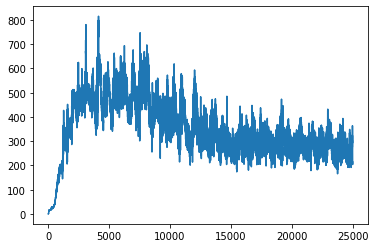

In [18]:
plt.plot(losses);

In [36]:
pt_cl, pt_cl_list = langevin_dynamics(score_net, sigmas, eps=0.00002, num_steps=5000)

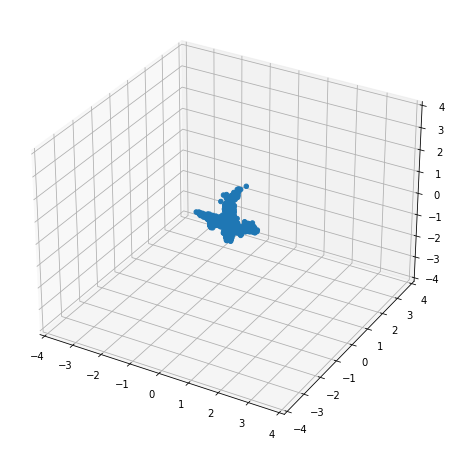

In [37]:
# Visualization
from mpl_toolkits.mplot3d import Axes3D
#for pt_cl_item in pt_cl_list:
#    visualize(pt_cl_item)
#visualize(pt_cl_item)
visualize(pt_cl_list[-1])

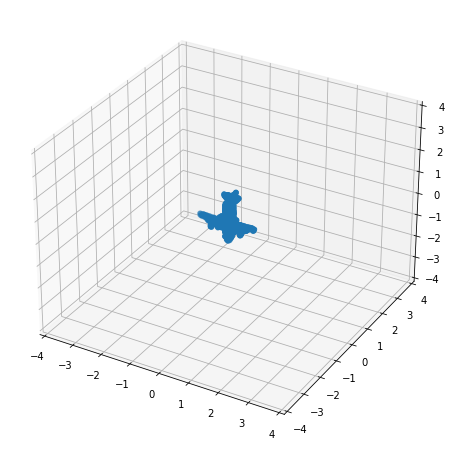

In [25]:
visualize(tr_pts)

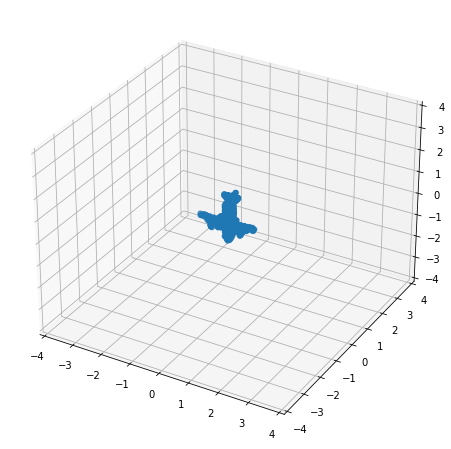

In [22]:
visualize(perturbed_points)